# Exercise 2: AirBnB

#### Initial Questions

1. What are the key factors influencing Airbnb prices in New York City? Specifically, how do the
popularity, proximity, and density of points of interest (POIs) impact pricing?
2. Furthermore, does accessibility to public transportation contribute to variations in Airbnb
prices, and if so, to what extent?
3. Lastly, how do neighborhood crime rates correlate with price fluctuations, and what role do
safety concerns play in determining Airbnb pricing trends?

To approach our research question, we will begin by gathering and preprocessing the relevant data sets,
including Airbnb listings and external factors such as Points of Interest, transportation
hubs and crime related data to ensure it is ready for analysis. Afterwards, we use clustering techniques to segment areas in New York City based on Airbnb prices and popularity. These clusters will be analyzed in relation to external
predictors like nearby amenities, landmarks, and accessibility to uncover patterns and correlations. To predict cluster prices, we developed machine learning models, starting with a simple algorithms and progressing to more advanced techniques. A best model was then chosen and we attempted hyperparameter tuning to further optimize the scores. This model allowed us to quantify the relationship between Airbnb pricing and external factors, while also identifying the most significant predictors. Finally, we visualized some of our findings to provide clear insights into how location-based factors influence Airbnb prices, summarizing these results in a report that addresses our research question and offers potential avenues for further exploration.

# Imports

In [2]:
import glob
import os
import datetime
import pickle
import typing
import re
import requests
import json
import gzip
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

import geopandas as gpd
from shapely.geometry import Point
from shapely.wkt  import loads

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Datasets

## 1 AirBnB Data

**Source:**
- https://data.insideairbnb.com/united-states/ny/new-york-city/2024-02-06/data/listings.csv.gz
- https://data.insideairbnb.com/united-states/ny/new-york-city/2024-02-06/data/reviews.csv.gz

**Additional Description:**
- https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit?gid=1322284596#gid=1322284596

The dataset includes detailed information on Airbnb listings in New York City for the year 2024. It includes information about property descriptions, locations, pricing, availability, and features like room types and amenities. Host details, such as name, response rates and superhost status, are also included. Additionally, the dataset captures guest feedback through reviews and ratings.

### Preprocessing

First we load the data set, then we remove the columns we do not need for our analysis. As shown below, the data set contains multiple columns containing information about the host, which can be retained to help map with the reviews dataset if needed. The `name` and the `description` of the individual listing are needed as well as we ultimately aim to predict the pricing. Furthermore, we  keep the columns `price` and `accomodates` as these will be needed to calculate the price per person. Additionally the columns related to location, like `neighbourhood_cleansed` and the `geolocation` are needed for further analysis. The other columns that are kept either contain critical information to identify the listing (`id`) or provide additional information that might influence the price or the review of a location, without it being dependent on the host.

In [3]:
listings = pd.read_csv("data/airbnblistings_2024.csv")
listings.head()

id                                      listing_url  \
0  977395984065981849  https://www.airbnb.com/rooms/977395984065981849   
1  648033676238017128  https://www.airbnb.com/rooms/648033676238017128   
2  871990853610302281  https://www.airbnb.com/rooms/871990853610302281   
3            15943497            https://www.airbnb.com/rooms/15943497   
4  845596919658541172  https://www.airbnb.com/rooms/845596919658541172   

        scrape_id last_scraped       source  \
0  20240206005441   2024-02-06  city scrape   
1  20240206005441   2024-02-06  city scrape   
2  20240206005441   2024-02-06  city scrape   
3  20240206005441   2024-02-06  city scrape   
4  20240206005441   2024-02-10  city scrape   

                                                name  \
0      Home in Brooklyn · 1 bedroom · 1 bed · 1 bath   
1  Rental unit in Bronx · ★4.89 · 1 bedroom · 1 b...   
2  Rental unit in Queens · ★New · 1 bedroom · Hal...   
3  Home in Brooklyn · ★4.74 · 1 bedroom · 1 bed ·...   
4  Rental unit in Brooklyn · 4 bedrooms · 1 bed ·...   

                                         description  \
0  This unique place has a style all its own. Is ...   
1  Welcome to this beautiful cozy bedroom in a sp...   
2      Kick back and relax in this calm, open space.   
3  Our home is steps away from train, 20 minutes ...   
4  - Huge furnished room, PRIVATE BATHROOM, TWO l...   

                               neighborhood_overview  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  I live in the Bedford Stuyvesant part of Brook...   
4                                                NaN   

                                         picture_url    host_id  ...  \
0  https://a0.muscache.com/pictures/miso/Hosting-...   95344065  ...   
1  https://a0.muscache.com/pictures/85291dc6-1e55...  421601513  ...   
2  https://a0.muscache.com/pictures/hosting/Hosti...  484563208  ...   
3  https://a0.muscache.com/pictures/bcd9135c-fa7d...   88043058  ...   
4  https://a0.muscache.com/pictures/miso/Hosting-...    3223938  ...   

  review_scores_communication review_scores_location review_scores_value  \
0                        4.00                   4.00                3.00   
1                        4.83                   4.94                4.94   
2                         NaN                    NaN                 NaN   
3                        4.94                   4.86                4.75   
4                         NaN                    NaN                 NaN   

  license instant_bookable calculated_host_listings_count  \
0     NaN                f                              7   
1     NaN                f                              3   
2     NaN                f                              2   
3     NaN                f                              3   
4     NaN                f                            600   

  calculated_host_listings_count_entire_homes  \
0                                           1   
1                                           0   
2                                           0   
3                                           0   
4                                           1   

  calculated_host_listings_count_private_rooms  \
0                                            6   
1                                            3   
2                                            2   
3                                            3   
4                                          599   

  calculated_host_listings_count_shared_rooms reviews_per_month  
0                                           0              0.86  
1                                           0              0.95  
2                                           0               NaN  
3                                           0              2.14  
4                                           0               NaN  

[5 rows x 75 columns]

In [106]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [4]:
listings_cleaned = listings[["id", "name", "host_id", "host_listings_count", "neighbourhood_cleansed", "neighbourhood_group_cleansed", "latitude", "longitude", "property_type",
                             "room_type", "accommodates", "bathrooms_text", "bedrooms", "beds", "price","number_of_reviews",
                             "review_scores_rating", "review_scores_location", "reviews_per_month"]]

In the subsequent steps below, let us go over each column and preprocess the values accordingly.

The values in *id* column are as expected hence there is no need of further processing.

In [5]:
listings['id'].value_counts()

id
977395984065981849     10
985398033818297264     10
713538                 10
23271535               10
33394700               10
                       ..
1021889750135971684     1
868068875545148857      1
1111503754114454537     1
1127949962094838814     1
1281465359952960262     1
Name: count, Length: 48266, dtype: int64

In [6]:
len(listings['id'].unique())

48266

At first glance, the data showed that the *bed* and *bedrooms* columns contain many missing values. Since the *name* column includes information about the number of beds and bedrooms, we used regex to extract these values and stored them in respective lists for later use.

After extracting the necessary information, we dropped the *name* column, as it was no longer needed.

In [48]:
listings['name'].value_counts()

name
Rental unit in New York · 1 bedroom · 1 bed · 1 bath                      2185
Rental unit in Brooklyn · 1 bedroom · 1 bed · 1 bath                      1207
Rental unit in Brooklyn · 1 bedroom · 1 bed · 1 shared bath                694
Rental unit in New York · Studio · 1 bed · 1 bath                          596
Rental unit in New York · 1 bedroom · 1 bed · 1 shared bath                562
                                                                          ... 
Rental unit in Brooklyn · ★4.66 · 1 bedroom · 1 bed · 1.5 shared baths       1
Rental unit in Astoria · 1 bedroom · 1 bath                                  1
Rental unit in Queens · ★4.33 · 2 bedrooms · 3 beds · 1 bath                 1
Home in Brooklyn · ★4.45 · 3 bedrooms · 4 beds · 1 bath                      1
1200-2F MedRoom1                                                             1
Name: count, Length: 61577, dtype: int64

In [49]:
bedrooms = listings['name'].apply(lambda x: re.search(r'(\d+)\s+bedroom', str(x)).group(1) if re.search(r'(\d+)\s+bedroom', str(x)) else 1)
beds = listings['name'].apply(lambda x: re.search(r'(\d+)\s+bed(?!room)s?', str(x)).group(1) if re.search(r'(\d+)\s+bed(?!room)s?', str(x)) else 1)

In [107]:
listings.drop('name',axis=1,inplace=True)

The values in *host_listings_count* column are as expected hence there is no need of further processing.

In [108]:
listings['host_listings_count'].value_counts()

host_listings_count
1.0      172017
2.0       49448
3.0       23124
4.0       13905
5.0        8880
          ...  
657.0         1
661.0         1
594.0         1
588.0         1
416.0         1
Name: count, Length: 445, dtype: int64

In [109]:
listings['host_listings_count'].isnull().sum()

51

The values in *neighbourhood_cleansed* column are as expected hence there is no need of further processing.

In [53]:
listings['neighbourhood_cleansed'].value_counts()

neighbourhood_cleansed
Bedford-Stuyvesant            27314
Williamsburg                  22237
Midtown                       20513
Harlem                        17837
Bushwick                      15710
                              ...  
Chelsea, Staten Island           10
Rossville                        10
Bay Terrace, Staten Island       10
Fort Wadsworth                   10
Hollis Hills                      8
Name: count, Length: 225, dtype: int64

In [54]:
listings['neighbourhood_cleansed'].isnull().sum()

0

The values in *neighbourhood_group_cleansed* column are as expected hence there is no need of further processing.

In [55]:
listings['neighbourhood_group_cleansed'].value_counts()

neighbourhood_group_cleansed
Manhattan        167332
Brooklyn         140438
Queens            56627
Bronx             12590
Staten Island      3659
Name: count, dtype: int64

In [56]:
listings['neighbourhood_group_cleansed'].isnull().sum()

0

The values in *property_type* column are as expected hence there is no need of further processing.

In [57]:
listings['property_type'].value_counts()

property_type
Entire rental unit             157346
Private room in rental unit    106051
Private room in home            24684
Entire home                     13354
Room in hotel                   12760
                                ...  
Private room in dorm                6
Private room in treehouse           4
Shared room in hotel                3
Private room in dome                1
Entire cabin                        1
Name: count, Length: 84, dtype: int64

In [58]:
listings['property_type'].isnull().sum()

0

The values in *room_type* column are as expected hence there is no need of further processing.

In [59]:
listings['room_type'].value_counts()

room_type
Entire home/apt    201596
Private room       170150
Shared room          5053
Hotel room           3847
Name: count, dtype: int64

In [60]:
listings['room_type'].isnull().sum()

0

The values in *accommodates* column are as expected hence there is no need of further processing.

In [61]:
listings['accommodates'].value_counts()

accommodates
2     177775
1      68595
4      56048
3      32576
6      17214
5      12854
8       6193
7       3264
10      1645
12      1522
16      1424
9        789
11       241
14       225
15       186
13        95
Name: count, dtype: int64

In [62]:
listings['accommodates'].isnull().sum()

0

We use the *bathrooms_text* column to extract the value of the number of bathrooms similar to how it was done for bedrooms and beds. Using the combine_first method in pandas, we then filled the missing values in the *beds*, *bedrooms* and *bathrooms* columns with the corresponding values extracted earlier. This effectively replaced the nulls with the appropriate data, ensuring that the columns are now free of missing values.

In [63]:
bathrooms = listings['bathrooms_text'].apply(lambda x: re.search(r'(\d+)',str(x)).group(1) if re.search(r'(\d+)',str(x)) else 1)

In [110]:
listings['bedrooms'].value_counts()

bedrooms
1.0     207758
2.0      59302
3.0      21528
0.0      20848
4.0       8428
5.0       2748
6.0        739
7.0        244
9.0         99
8.0         55
10.0        20
15.0        10
14.0        10
16.0        10
11.0         4
21.0         2
26.0         2
Name: count, dtype: int64

In [65]:
listings['bedrooms'].isnull().sum()

58839

In [66]:
listings['bedrooms'] = listings['bedrooms'].combine_first(pd.Series(bedrooms))
listings['beds'] = listings['beds'].combine_first(pd.Series(beds))
listings['bathrooms'] = bathrooms

In [111]:
listings.drop('bathrooms_text',axis=1,inplace=True)

The number of null values for both *review_scores_rating* and *price* are alarmingly high. Upon a look at the website links for the listings, we were able to determine that the missing prices are typically due to listings without a listed price, while the null values for reviews are usually a result of no reviews being available for those listings.

48000 records are observed with no price or reviews mentioned.

In [112]:
listings['price']

0          $30.00
1          $30.00
2          $85.00
3          $50.00
4          $48.00
           ...   
380641     $28.00
380642    $475.00
380643    $162.00
380644    $250.00
380645     $52.00
Name: price, Length: 380646, dtype: object

In [113]:
listings['price'].isnull().sum()

146933

In [70]:
listings['number_of_reviews'].value_counts()

number_of_reviews
0       116289
1        36413
2        22604
3        15631
4        12172
         ...  
515          1
571          1
660          1
895          1
2165         1
Name: count, Length: 769, dtype: int64

In [71]:
listings['number_of_reviews'].isnull().sum()

0

In [72]:
listings['review_scores_rating'].value_counts()

review_scores_rating
5.00    81429
4.00    10117
4.50     9229
4.67     7416
4.75     6288
        ...  
3.99        1
3.61        1
4.01        1
3.45        1
3.39        1
Name: count, Length: 185, dtype: int64

In [73]:
listings['review_scores_rating'].isnull().sum()

116266

In [74]:
listings[listings['review_scores_rating'].isnull() & listings['price'].isnull()].shape

(48051, 73)

The way to treat this is to gather the unique listing ids of all such listings with no reviews or prices mentioned.

In [114]:
missing_listing_ids = listings[listings['review_scores_rating'].isnull() & listings['price'].isnull()]['id'].unique()

In [115]:
missing_listing_ids

array([             766814,             1442450,             1741745, ...,
       1253732238224136520, 1254372592138384859, 1257025240961774482])

In [77]:
len(missing_listing_ids)

7825

This is followed by using the reviews file and extracting any manual reviews left by users for the said listings. Since the reviews file is very large in size, we had to break it down into chunks of 100k records, find the chunks of data where there is a review available for the listings above and filtering them out into a reviews dataframe.

In [116]:
filtered_data = []
for chunk in pd.read_csv("data/airbnbreviews_2024.csv", chunksize=100000):
    filtered_chunk = chunk[chunk['listing_id'].isin(missing_listing_ids)]
    filtered_data.append(filtered_chunk)

reviews = pd.concat(filtered_data, ignore_index=True)

In [117]:
reviews.head()

listing_id         id        date  reviewer_id reviewer_name  \
0    23252265  244418268  2018-03-18    105719199         Brita   
1    23252265  351988678  2018-11-24     26323711     Katherine   
2    23252265  357142886  2018-12-09    136634067       Matthew   
3    23252265  430012819  2019-03-29     22656621        Emilee   
4    23252265  452126197  2019-05-12     22524456         Scott   

                                            comments  
0  Laura's place is incredibly conveniently locat...  
1  The apartment is adorable and extremely conven...  
2  Fantastic value. Awesome location and very cut...  
3  Great location, easy access to trains, up abov...  
4  Great location in the west village, near every...

In [118]:
reviews.shape

(3760, 6)

In [119]:
len(reviews['listing_id'].unique())

348

We can see that 348 out of the initial 7825 odd listings have manual reviews for them so the next step is to use simple sentiment analysis polarity to create ratings based on the text reviews and replace them wherever nulls are present for them.

In [120]:
def rate_review(review):
    polarity = TextBlob(review).sentiment.polarity
    if polarity <= -0.5:
        return 1
    elif -0.5 < polarity <= 0:
        return 2
    elif 0 < polarity <= 0.6:
        return 3
    elif 0.6 < polarity <= 0.9:
        return 4
    else:
        return 5

reviews['rating'] = reviews['comments'].apply(rate_review)
reviews.head()

listing_id         id        date  reviewer_id reviewer_name  \
0    23252265  244418268  2018-03-18    105719199         Brita   
1    23252265  351988678  2018-11-24     26323711     Katherine   
2    23252265  357142886  2018-12-09    136634067       Matthew   
3    23252265  430012819  2019-03-29     22656621        Emilee   
4    23252265  452126197  2019-05-12     22524456         Scott   

                                            comments  rating  
0  Laura's place is incredibly conveniently locat...       3  
1  The apartment is adorable and extremely conven...       3  
2  Fantastic value. Awesome location and very cut...       3  
3  Great location, easy access to trains, up abov...       3  
4  Great location in the west village, near every...       3

This is followed by removing the listings with no price or reviews as they dont contribute to the dataset at all.

In [122]:
missing_listings = set(missing_listing_ids).difference(set(reviews['listing_id'].unique()))
listings = listings[~listings['id'].isin(missing_listings)].reset_index()

In [123]:
listings.drop('index',axis=1,inplace=True)
listings.head()

level_0                  id  \
0        0  977395984065981849   
1        1  648033676238017128   
2        2  871990853610302281   
3        3            15943497   
4        4  845596919658541172   

                                       listing_url       scrape_id  \
0  https://www.airbnb.com/rooms/977395984065981849  20240206005441   
1  https://www.airbnb.com/rooms/648033676238017128  20240206005441   
2  https://www.airbnb.com/rooms/871990853610302281  20240206005441   
3            https://www.airbnb.com/rooms/15943497  20240206005441   
4  https://www.airbnb.com/rooms/845596919658541172  20240206005441   

  last_scraped       source  \
0   2024-02-06  city scrape   
1   2024-02-06  city scrape   
2   2024-02-06  city scrape   
3   2024-02-06  city scrape   
4   2024-02-10  city scrape   

                                         description  \
0  This unique place has a style all its own. Is ...   
1  Welcome to this beautiful cozy bedroom in a sp...   
2      Kick back and relax in this calm, open space.   
3  Our home is steps away from train, 20 minutes ...   
4  - Huge furnished room, PRIVATE BATHROOM, TWO l...   

                               neighborhood_overview  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  I live in the Bedford Stuyvesant part of Brook...   
4                                                NaN   

                                         picture_url    host_id  ...  \
0  https://a0.muscache.com/pictures/miso/Hosting-...   95344065  ...   
1  https://a0.muscache.com/pictures/85291dc6-1e55...  421601513  ...   
2  https://a0.muscache.com/pictures/hosting/Hosti...  484563208  ...   
3  https://a0.muscache.com/pictures/bcd9135c-fa7d...   88043058  ...   
4  https://a0.muscache.com/pictures/miso/Hosting-...    3223938  ...   

  review_scores_communication review_scores_location review_scores_value  \
0                        4.00                   4.00                3.00   
1                        4.83                   4.94                4.94   
2                         NaN                    NaN                 NaN   
3                        4.94                   4.86                4.75   
4                         NaN                    NaN                 NaN   

  license instant_bookable calculated_host_listings_count  \
0     NaN                f                              7   
1     NaN                f                              3   
2     NaN                f                              2   
3     NaN                f                              3   
4     NaN                f                            600   

  calculated_host_listings_count_entire_homes  \
0                                           1   
1                                           0   
2                                           0   
3                                           0   
4                                           1   

  calculated_host_listings_count_private_rooms  \
0                                            6   
1                                            3   
2                                            2   
3                                            3   
4                                          599   

  calculated_host_listings_count_shared_rooms reviews_per_month  
0                                           0              0.86  
1                                           0              0.95  
2                                           0               NaN  
3                                           0              2.14  
4                                           0               NaN  

[5 rows x 74 columns]

Now to fill in the missing values in the *review_scores_rating* column of the listings dataframe we use the average rating from the reviews dataframe using only the reviews for dates of 2024.

In [125]:
reviews = reviews[reviews['date']>'2024-01-01']
ratings_dict = reviews.groupby('listing_id')['rating'].mean().to_dict()

In [126]:
for listing_id in ratings_dict.keys():
    missing_mask = (listings['id'] == listing_id) & (listings['review_scores_rating'].isnull())
    listings.loc[missing_mask, 'review_scores_rating'] = ratings_dict[listing_id]

This is followed by filtering out the relevant columns and creating a listings dataframe only for those columns.

In [9]:
listings = listings[["id", "host_id", "host_listings_count", "neighbourhood_cleansed", "neighbourhood_group_cleansed", "latitude", "longitude", "property_type",
                    "room_type", "accommodates", "bathrooms", "bedrooms", "beds", "price","number_of_reviews",
                    "review_scores_rating"]]

As a next step we filtering out the '$' from the *price* column followed by manually assigning datatypes for different columns for consistency.

In [129]:
listings['price'] = listings['price'].str.extract('(\d+)', expand=False)
listings.astype({
    "id" : int, "neighbourhood_cleansed": 'category', "latitude": float, "longitude": float, "property_type": 'category',
                             "room_type": 'category', "accommodates": int, "number_of_reviews": int,
                             "review_scores_rating": float, 'bathrooms': float, 'bedrooms': float, 'beds': float})

id    host_id  host_listings_count  \
0        977395984065981849   95344065                  8.0   
1        648033676238017128  421601513                  6.0   
2        871990853610302281  484563208                  2.0   
3                  15943497   88043058                  3.0   
4        845596919658541172    3223938                611.0   
...                     ...        ...                  ...   
314251  1281096465598617765    3223938                742.0   
314252  1281230979116575465   43042852                  2.0   
314253  1281263542832791722   23297442                  1.0   
314254  1281431427554747842  530889967                  1.0   
314255  1281465359952960262  267272502                 26.0   

       neighbourhood_cleansed neighbourhood_group_cleansed   latitude  \
0              Sheepshead Bay                     Brooklyn  40.591790   
1                 Kingsbridge                        Bronx  40.863940   
2                Howard Beach                       Queens  40.663586   
3          Bedford-Stuyvesant                     Brooklyn  40.689970   
4                    Flatbush                     Brooklyn  40.652979   
...                       ...                          ...        ...   
314251            Bensonhurst                     Brooklyn  40.612310   
314252     Bedford-Stuyvesant                     Brooklyn  40.684703   
314253     Bedford-Stuyvesant                     Brooklyn  40.686559   
314254            Port Morris                        Bronx  40.806013   
314255             Highbridge                        Bronx  40.836684   

        longitude                property_type        room_type  accommodates  \
0      -73.942850         Private room in home     Private room             1   
1      -73.903120  Private room in rental unit     Private room             2   
2      -73.834532  Private room in rental unit     Private room             1   
3      -73.954700         Private room in home     Private room             1   
4      -73.957686  Private room in rental unit     Private room             1   
...           ...                          ...              ...           ...   
314251 -73.980300  Private room in rental unit     Private room             1   
314252 -73.957000                  Entire home  Entire home/apt             6   
314253 -73.922157           Entire rental unit  Entire home/apt             2   
314254 -73.927053           Entire rental unit  Entire home/apt             3   
314255 -73.924639  Private room in rental unit     Private room             1   

        bathrooms  bedrooms  beds price  number_of_reviews  \
0             1.0       1.0   1.0    30                  1   
1             1.0       1.0   1.0    30                 18   
2             0.5       1.0   0.0    85                  0   
3             1.0       1.0   1.0    50                185   
4             2.0       4.0   1.0    48                  0   
...           ...       ...   ...   ...                ...   
314251        1.5       4.0   1.0    28                  0   
314252        2.5       3.0   3.0   475                  0   
314253        1.0       1.0   1.0   162                  0   
314254        1.0       1.0   1.0   250                  0   
314255        1.0       1.0   1.0    52                  0   

        review_scores_rating  
0                       2.00  
1                       4.89  
2                        NaN  
3                       4.74  
4                        NaN  
...                      ...  
314251                   NaN  
314252                   NaN  
314253                   NaN  
314254                   NaN  
314255                   NaN  

[314256 rows x 16 columns]

Now let's have a look at the missing values for each column.

In [128]:
listings.isnull().sum()

id                                   0
host_id                              0
host_listings_count                 11
neighbourhood_cleansed               0
neighbourhood_group_cleansed         0
latitude                             0
longitude                            0
property_type                        0
room_type                            0
accommodates                         0
bathrooms                        99390
bedrooms                         40960
beds                            100602
price                            99533
number_of_reviews                    0
review_scores_rating             48229
dtype: int64

We can observe that all instances of *review_scores_rating* are missing because these listings have no available reviews. Since we need the data with reviews, we can drop these instances.

In [130]:
listings.loc[(listings['number_of_reviews']==0) & (listings['review_scores_rating'].isnull())]

id    host_id  host_listings_count  \
2        871990853610302281  484563208                  2.0   
4        845596919658541172    3223938                611.0   
13       842978126440326634  470005375                  2.0   
16       871200484656283015  451461851                  1.0   
19      1007898112628596835  481526228                  1.0   
...                     ...        ...                  ...   
314251  1281096465598617765    3223938                742.0   
314252  1281230979116575465   43042852                  2.0   
314253  1281263542832791722   23297442                  1.0   
314254  1281431427554747842  530889967                  1.0   
314255  1281465359952960262  267272502                 26.0   

       neighbourhood_cleansed neighbourhood_group_cleansed   latitude  \
2                Howard Beach                       Queens  40.663586   
4                    Flatbush                     Brooklyn  40.652979   
13                    Fordham                        Bronx  40.854192   
16            Windsor Terrace                     Brooklyn  40.659010   
19         Westchester Square                        Bronx  40.842244   
...                       ...                          ...        ...   
314251            Bensonhurst                     Brooklyn  40.612310   
314252     Bedford-Stuyvesant                     Brooklyn  40.684703   
314253     Bedford-Stuyvesant                     Brooklyn  40.686559   
314254            Port Morris                        Bronx  40.806013   
314255             Highbridge                        Bronx  40.836684   

        longitude                property_type        room_type  accommodates  \
2      -73.834532  Private room in rental unit     Private room             1   
4      -73.957686  Private room in rental unit     Private room             1   
13     -73.900078                 Entire place  Entire home/apt             4   
16     -73.975963           Entire rental unit  Entire home/apt             3   
19     -73.853097           Entire rental unit  Entire home/apt             4   
...           ...                          ...              ...           ...   
314251 -73.980300  Private room in rental unit     Private room             1   
314252 -73.957000                  Entire home  Entire home/apt             6   
314253 -73.922157           Entire rental unit  Entire home/apt             2   
314254 -73.927053           Entire rental unit  Entire home/apt             3   
314255 -73.924639  Private room in rental unit     Private room             1   

        bathrooms  bedrooms  beds price  number_of_reviews  \
2             0.5       1.0   0.0    85                  0   
4             2.0       4.0   1.0    48                  0   
13            1.0       0.0   2.0   170                  0   
16            1.0       2.0   2.0   109                  0   
19            1.0       2.0   0.0   319                  0   
...           ...       ...   ...   ...                ...   
314251        1.5       4.0   1.0    28                  0   
314252        2.5       3.0   3.0   475                  0   
314253        1.0       1.0   1.0   162                  0   
314254        1.0       1.0   1.0   250                  0   
314255        1.0       1.0   1.0    52                  0   

        review_scores_rating  
2                        NaN  
4                        NaN  
13                       NaN  
16                       NaN  
19                       NaN  
...                      ...  
314251                   NaN  
314252                   NaN  
314253                   NaN  
314254                   NaN  
314255                   NaN  

[48229 rows x 16 columns]

In [131]:
listings.dropna(subset='review_scores_rating',inplace=True)
listings.isnull().sum()

id                                   0
host_id                              0
host_listings_count                 11
neighbourhood_cleansed               0
neighbourhood_group_cleansed         0
latitude                             0
longitude                            0
property_type                        0
room_type                            0
accommodates                         0
bathrooms                        99357
bedrooms                         40730
beds                            100222
price                            99528
number_of_reviews                    0
review_scores_rating                 0
dtype: int64

In [132]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 266027 entries, 0 to 314101
Data columns (total 16 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            266027 non-null  int64  
 1   host_id                       266027 non-null  int64  
 2   host_listings_count           266016 non-null  float64
 3   neighbourhood_cleansed        266027 non-null  object 
 4   neighbourhood_group_cleansed  266027 non-null  object 
 5   latitude                      266027 non-null  float64
 6   longitude                     266027 non-null  float64
 7   property_type                 266027 non-null  object 
 8   room_type                     266027 non-null  object 
 9   accommodates                  266027 non-null  int64  
 10  bathrooms                     166670 non-null  float64
 11  bedrooms                      225297 non-null  float64
 12  beds                          165805 non-null  fl

The final step is to consider all the records with missing prices to be the test dataset that we could use for predictions once we are done analyzing and improving on the train/cleaned dataset.

Finally, the dataframe is split into two datasets and theyre respectively stored in the data folder accordingly.

In [133]:
## test_listings = listings.loc[listings['price'].isnull()].reset_index(drop=True)
clean_listings = listings.loc[listings['price'].notnull()].reset_index(drop=True)

In [134]:
## test_listings.to_csv('data/airbnb/airbnb_testdata.csv')
clean_listings.to_csv('data/exports/airbnb_data_processed.csv')

## 2 Points of Interest

**Source:**
- https://data.cityofnewyork.us/City-Government/Points-of-Interest/rxuy-2muj

**Additional Description:**
- https://data.cityofnewyork.us/api/views/t95h-5fsr/files/ebabcf1d-c6e7-43ca-a031-5168036b2fbb?download=true&filename=PointOfInterest.pdf

This dataset contains information about various points of interest (POIs) in New York City, such as schools, cultural centers, recreational areas and more, including their geographic coordinates.

### Preprocessing

Again, after loading the data, we drop the columns that are not needed. The focus should be on the essential informations required for aggregating points into community districts and performing analysis within New York City on borough-level. Therefore the ones we keep are: `the_geom` (Geometric Coordinates) because it provides the latitude and longitude of the points, which are necessary for spatial operations such as determining if a point lies within a community district or borough. The `BOROUGH` (Borough Identifier) column helps filter out data points outside New York City. Essential for borough-level aggregation and validation. Furthermore `FACILITY_T` (Facility Type) is useful for understanding what kind of facility each point of interest represents, which adds contextual information that can enhance analysis or visualization.  Finally, `NAME` (Point Name) adds a descriptive label for each point, making it easier to interpret and display the data during analysis or visualization.


In [99]:
data = pd.read_csv('data/POI.csv')
data.head()

the_geom  SEGMENTID  COMPLEXID  \
0  POINT (-74.00701717096757 40.724634757833414)      31895          0   
1  POINT (-73.82661642130311 40.797182526598505)     306303       3378   
2   POINT (-73.99395441100663 40.70384707235758)     144842       3960   
3    POINT (-73.9919414213091 40.70960010711745)     162664          0   
4    POINT (-73.9526609766105 40.73906602249743)     157362          0   

  SAFTYPE  SOS  PLACEID  FACI_DOM  BIN  BOROUGH                 CREATED  \
0       N  1.0      567         9    0      1.0  05/14/2009 12:00:00 AM   
1       N  2.0      568         8    0      4.0  05/14/2009 12:00:00 AM   
2       N  2.0      576         8    0      3.0  05/14/2009 12:00:00 AM   
3       N  1.0      580         8    0      1.0  05/14/2009 12:00:00 AM   
4       N  1.0      582         8    0      3.0  05/14/2009 12:00:00 AM   

                 MODIFIED  FACILITY_T SOURCE        B7SC  PRI_ADD        NAME  
0  11/18/2011 12:00:00 AM           6  DoITT  19743001.0        0     HOLLAND  
1  01/09/2017 12:00:00 AM           6  DoITT  49731001.0        0  WHITESTONE  
2  01/22/2018 12:00:00 AM           6  DoITT  39734001.0        0    BROOKLYN  
3  05/11/2011 12:00:00 AM           6  DoITT  19795001.0        0   MANHATTAN  
4  03/03/2017 12:00:00 AM           6  DoITT  39740001.0        0     PULASKI

In [101]:
df = data[['the_geom', 'BOROUGH', 'FACILITY_T',  'NAME']]
df.shape

(20596, 4)

As a next step, we filter out boroughs that are not part of New York City and map the remaining ones to their corresponding names. The encoding of the boroughs is provided in the additional description, where boroughs numbered 1 through 5 are the ones located within New York City.

In [102]:
df['BOROUGH'].unique()

array([ 1.,  4.,  3.,  2.,  5., nan,  8.])

In [103]:
df = df.dropna(subset=['the_geom']).copy()
print(df.shape)

(20596, 4)


In [103]:
df = df.loc[df['BOROUGH'] <= 5]
print(df['BOROUGH'].unique())  


[1. 4. 3. 2. 5.]


In [104]:
print(df.describe)

<bound method NDFrame.describe of                                             the_geom  BOROUGH  FACILITY_T  \
0      POINT (-74.00701717096757 40.724634757833414)      1.0           6   
1      POINT (-73.82661642130311 40.797182526598505)      4.0           6   
2       POINT (-73.99395441100663 40.70384707235758)      3.0           6   
3        POINT (-73.9919414213091 40.70960010711745)      1.0           6   
4        POINT (-73.9526609766105 40.73906602249743)      3.0           6   
...                                              ...      ...         ...   
20571  POINT (-73.91125345633935 40.776969338770535)      4.0           9   
20572   POINT (-73.93874332465784 40.59206990676358)      3.0           3   
20573  POINT (-73.95498698976225 40.622455918912394)      3.0           2   
20574      POINT (-73.955370475949 40.6223263507244)      3.0           9   
20575   POINT (-73.94519728674484 40.61507393637472)      3.0           9   

                                       NA

In [105]:
borough_names = {
    1: 'Manhattan',
    2: 'Bronx',
    3: 'Brooklyn',
    4: 'Queens',
    5: 'Staten Island',
}
df['BOROUGH'] = df['BOROUGH'].map(borough_names)

df.head()

the_geom    BOROUGH  FACILITY_T  \
0  POINT (-74.00701717096757 40.724634757833414)  Manhattan           6   
1  POINT (-73.82661642130311 40.797182526598505)     Queens           6   
2   POINT (-73.99395441100663 40.70384707235758)   Brooklyn           6   
3    POINT (-73.9919414213091 40.70960010711745)  Manhattan           6   
4    POINT (-73.9526609766105 40.73906602249743)   Brooklyn           6   

         NAME  
0     HOLLAND  
1  WHITESTONE  
2    BROOKLYN  
3   MANHATTAN  
4     PULASKI

Next we extract the longitude and latitude from the column *the_geom* using regex.

In [106]:
df['longitude'] = df['the_geom'].str.extract(r'POINT \((-?\d+\.\d+)')[0].astype(float)
df['latitude'] = df['the_geom'].str.extract(r' (-?\d+\.\d+)\)').astype(float)

df.head()

the_geom    BOROUGH  FACILITY_T  \
0  POINT (-74.00701717096757 40.724634757833414)  Manhattan           6   
1  POINT (-73.82661642130311 40.797182526598505)     Queens           6   
2   POINT (-73.99395441100663 40.70384707235758)   Brooklyn           6   
3    POINT (-73.9919414213091 40.70960010711745)  Manhattan           6   
4    POINT (-73.9526609766105 40.73906602249743)   Brooklyn           6   

         NAME  longitude   latitude  
0     HOLLAND -74.007017  40.724635  
1  WHITESTONE -73.826616  40.797183  
2    BROOKLYN -73.993954  40.703847  
3   MANHATTAN -73.991941  40.709600  
4     PULASKI -73.952661  40.739066

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20361 entries, 0 to 20575
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   the_geom    20361 non-null  object 
 1   BOROUGH     20361 non-null  object 
 2   FACILITY_T  20361 non-null  int64  
 3   NAME        20361 non-null  object 
 4   longitude   20361 non-null  float64
 5   latitude    20361 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 1.1+ MB


Afterwards, we create binary columns for each facility type in the dataset, where each column indicates whether the point of interest belongs to that specific facility type. The facility types are detailed in the additional description.

In [108]:
facility_types = [
    'Residential', 'Education Facility', 'Cultural Facility', 'Recreational Facility', 
    'Social Services', 'Transportation Facility', 'Commercial', 
    'Government Facility (non public safety)', 'Religious Institution', 
    'Health Services', 'Public Safety', 'Water', 'Miscellaneous'
]

for i in range(1, 14):  # Facility types range from 1 to 13
    df[f'Facility_Type_{i}'] = (df['FACILITY_T'] == i).astype(int)

facility_names = {
    1: 'Residential',
    2: 'Education Facility',
    3: 'Cultural Facility',
    4: 'Recreational Facility',
    5: 'Social Services',
    6: 'Transportation Facility',
    7: 'Commercial',
    8: 'Government Facility',
    9: 'Religious Institution',
    10: 'Health Services',
    11: 'Public Safety',
    12: 'Water',
    13: 'Miscellaneous'
}

for i in range(1, 14):
    df.rename(columns={f'Facility_Type_{i}': facility_names[i]}, inplace=True)

df.head()

the_geom    BOROUGH  FACILITY_T  \
0  POINT (-74.00701717096757 40.724634757833414)  Manhattan           6   
1  POINT (-73.82661642130311 40.797182526598505)     Queens           6   
2   POINT (-73.99395441100663 40.70384707235758)   Brooklyn           6   
3    POINT (-73.9919414213091 40.70960010711745)  Manhattan           6   
4    POINT (-73.9526609766105 40.73906602249743)   Brooklyn           6   

         NAME  longitude   latitude  Residential  Education Facility  \
0     HOLLAND -74.007017  40.724635            0                   0   
1  WHITESTONE -73.826616  40.797183            0                   0   
2    BROOKLYN -73.993954  40.703847            0                   0   
3   MANHATTAN -73.991941  40.709600            0                   0   
4     PULASKI -73.952661  40.739066            0                   0   

   Cultural Facility  Recreational Facility  Social Services  \
0                  0                      0                0   
1                  0                      0                0   
2                  0                      0                0   
3                  0                      0                0   
4                  0                      0                0   

   Transportation Facility  Commercial  Government Facility  \
0                        1           0                    0   
1                        1           0                    0   
2                        1           0                    0   
3                        1           0                    0   
4                        1           0                    0   

   Religious Institution  Health Services  Public Safety  Water  Miscellaneous  
0                      0                0              0      0              0  
1                      0                0              0      0              0  
2                      0                0              0      0              0  
3                      0                0              0      0              0  
4                      0                0              0      0              0

Now we can drop the columns *FACILITY_T*, *Name* and *the_geom* as they are not of use anymore.

In [109]:
df = df.drop(columns=['FACILITY_T', 'NAME','the_geom'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20361 entries, 0 to 20575
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   BOROUGH                  20361 non-null  object 
 1   longitude                20361 non-null  float64
 2   latitude                 20361 non-null  float64
 3   Residential              20361 non-null  int32  
 4   Education Facility       20361 non-null  int32  
 5   Cultural Facility        20361 non-null  int32  
 6   Recreational Facility    20361 non-null  int32  
 7   Social Services          20361 non-null  int32  
 8   Transportation Facility  20361 non-null  int32  
 9   Commercial               20361 non-null  int32  
 10  Government Facility      20361 non-null  int32  
 11  Religious Institution    20361 non-null  int32  
 12  Health Services          20361 non-null  int32  
 13  Public Safety            20361 non-null  int32  
 14  Water                 

Finally,the resulting dataframe is stored in the data folder accordingly.

In [110]:
df.to_csv('data/exports/POI.csv', index=False)

## 3 Transportation

We initially gathered and preprocessed public transport data in a separate dataset. However, since this information was already included in the Points of Interest dataset, we decided to omit this step to save space, as it was not utilized in the subsequent analysis.

## 4 Crime and Shooting Data

**Source:**
- Crime: https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Current-Year-To-Date-/5uac-w243/about_data
- Shootings: https://data.cityofnewyork.us/Public-Safety/NYPD-Shooting-Incident-Data-Year-To-Date-/5ucz-vwe8/about_data

### Crime Data Set 
First we eliminate unnecessary columns from the data for the crime dataset. The columns `X_COORD_CD`, `Y_COORD_CD`, `HADEVELOPT`, `BORO_NM`, `ADDR_PCT_CD`, `STATION_NAME` and `TRANSIT_DISTRICT` are unnecessary as we use Latitude and Longitude coordinates for the location data. `LOC_OF_OCCUR_DESC` is removed because it is not relevant for us if crime happened on the outside/inside. `JURIS_DESC`and `JURISDICTION_CODE` indicates the which police department handles the incident and is therefore not relevant for us. The `CMPLNT_NUM` id is needed for our purposes. Furthermore the type of premise `PREM_TYP_DESC` is not relevant. Also the park name `PARKS_NM` are not relevant since coordinates are used for locations. `CMPLNT_FR_TM` and `CMPLNT_TO_TM` are removed since the date is enough for our purposes. `HOUSING_PSA`, `PATROL_BORO`, `SUSP_AGE_GROUP`, `SUSP_SEX`, `SUSP_RACE`,`VIC_AGE_GROUP`, `VIC_RACE`, `VIC_SEX` are not relevant. The columns `RPT_DT` and `CMPLNT_TO_DT` are dropped as we are only interested on when the crime was taken place not when it was reported/finished. Lastly the column `KY_CD` is not used as no description provided and no decent mapping was found.

In [24]:
df = pd.read_csv('data/NYPD_Complaint_Data_Current__Year_To_Date__20241223.csv')
df = df.drop(columns= ['X_COORD_CD', 'Y_COORD_CD', 'LOC_OF_OCCUR_DESC', 'JURIS_DESC', 'HADEVELOPT',
                      'CMPLNT_NUM', 'PREM_TYP_DESC', 'BORO_NM', 'PARKS_NM', 'CMPLNT_TO_TM', 'CMPLNT_FR_TM',
                      'ADDR_PCT_CD', 'HOUSING_PSA','JURISDICTION_CODE', 'PATROL_BORO', 'STATION_NAME',
                      'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'TRANSIT_DISTRICT', 'VIC_AGE_GROUP', 'VIC_RACE',
                      'VIC_SEX', 'RPT_DT', 'CMPLNT_TO_DT', 'KY_CD', 'PD_CD'])
print(df.head())

  CMPLNT_FR_DT CRM_ATPT_CPTD_CD   LAW_CAT_CD                        OFNS_DESC  \
0   07/02/2024        COMPLETED       FELONY                       SEX CRIMES   
1   06/01/2024        COMPLETED       FELONY  MURDER & NON-NEGL. MANSLAUGHTER   
2   03/08/2024        COMPLETED    VIOLATION                    HARRASSMENT 2   
3   04/04/2024        COMPLETED       FELONY                          ROBBERY   
4   06/05/2024        COMPLETED  MISDEMEANOR     ASSAULT 3 & RELATED OFFENSES   

                        PD_DESC   Latitude  Longitude  \
0                      SODOMY 3  40.887314 -73.847272   
1                        (null)        NaN        NaN   
2         HARASSMENT,SUBD 3,4,5  40.559481 -74.178539   
3  ROBBERY,BEGIN AS SHOPLIFTING  40.634036 -74.123607   
4                     ASSAULT 3  40.536852 -74.213994   

                                 Lat_Lon  \
0  (40.8873136344706, -73.8472717577564)   
1                                    NaN   
2                (40.559481, -74.17853

Next we check for NAs.

In [25]:
missing_values = df.isnull().sum()
print(missing_values)

CMPLNT_FR_DT                0
CRM_ATPT_CPTD_CD            0
LAW_CAT_CD                  0
OFNS_DESC                   0
PD_DESC                     0
Latitude                    6
Longitude                   6
Lat_Lon                     6
New Georeferenced Column    6
dtype: int64


All the missing values are related to the location which is very important for our analysis, so we drop these rows.

In [26]:
df = df.dropna(axis = 0, how = 'any')
print(df.isnull().sum())

CMPLNT_FR_DT                0
CRM_ATPT_CPTD_CD            0
LAW_CAT_CD                  0
OFNS_DESC                   0
PD_DESC                     0
Latitude                    0
Longitude                   0
Lat_Lon                     0
New Georeferenced Column    0
dtype: int64


Next we check the data types.

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 433275 entries, 0 to 433280
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   CMPLNT_FR_DT              433275 non-null  object 
 1   CRM_ATPT_CPTD_CD          433275 non-null  object 
 2   LAW_CAT_CD                433275 non-null  object 
 3   OFNS_DESC                 433275 non-null  object 
 4   PD_DESC                   433275 non-null  object 
 5   Latitude                  433275 non-null  float64
 6   Longitude                 433275 non-null  float64
 7   Lat_Lon                   433275 non-null  object 
 8   New Georeferenced Column  433275 non-null  object 
dtypes: float64(2), object(7)
memory usage: 33.1+ MB


The types of the varialbes seem to be fine only the column *CMPLNT_FR_DT* should be converted to type date.

In [28]:
df['CMPLNT_FR_DT'] = pd.to_datetime(df['CMPLNT_FR_DT'], errors='coerce', format='%m/%d/%Y')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 433275 entries, 0 to 433280
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   CMPLNT_FR_DT              433259 non-null  datetime64[ns]
 1   CRM_ATPT_CPTD_CD          433275 non-null  object        
 2   LAW_CAT_CD                433275 non-null  object        
 3   OFNS_DESC                 433275 non-null  object        
 4   PD_DESC                   433275 non-null  object        
 5   Latitude                  433275 non-null  float64       
 6   Longitude                 433275 non-null  float64       
 7   Lat_Lon                   433275 non-null  object        
 8   New Georeferenced Column  433275 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 33.1+ MB


As we are only interested in recent years, we need to filter dates before a certain year.

In [29]:
df = df[df['CMPLNT_FR_DT'].dt.year >= 2022]
print(df.head())

  CMPLNT_FR_DT CRM_ATPT_CPTD_CD   LAW_CAT_CD                     OFNS_DESC  \
0   2024-07-02        COMPLETED       FELONY                    SEX CRIMES   
2   2024-03-08        COMPLETED    VIOLATION                 HARRASSMENT 2   
3   2024-04-04        COMPLETED       FELONY                       ROBBERY   
4   2024-06-05        COMPLETED  MISDEMEANOR  ASSAULT 3 & RELATED OFFENSES   
5   2024-08-09        COMPLETED       FELONY                 GRAND LARCENY   

                                             PD_DESC   Latitude  Longitude  \
0                                           SODOMY 3  40.887314 -73.847272   
2                              HARASSMENT,SUBD 3,4,5  40.559481 -74.178539   
3                       ROBBERY,BEGIN AS SHOPLIFTING  40.634036 -74.123607   
4                                          ASSAULT 3  40.536852 -74.213994   
5  LARCENY,GRAND BY FALSE PROMISE-NOT IN PERSON C...  40.542560 -74.216738   

                                 Lat_Lon  \
0  (40.88731363447

Finally we save the crime data in the data folder.

In [ ]:
df.to_csv('data/exports/NYPD_Complaint_Data_Current__Year_To_Date__20241223_preprocessed.csv', index=False)

### Shootings Dataset

For the shootings dataset we perform the same steps as before. First we drop the unnecessary columns. `INCIDENT_KEY` and `OCCUR_TIME` are not relevant. `BORO`, `LOC_OF_OCCUR_DESC`, `PRECINCT`, `JURISDICTION_CODE`, `LOC_CLASSFCTN_DESC`, `LOCATION_DESC`, `x_coord_cd` and `y_coord_cd` can all be dropped since we only retain the location via coordinates.
`PERP_AGE_GROUP`, `PERP_SEX`, `PERP_RACE`, `VIC_AGE_GROUP`, `VIC_SEX` and`VIC_RACE` are not relevant as we will be aggregating the number of shootings later.

In [30]:
file_path = 'https://data.cityofnewyork.us/resource/5ucz-vwe8.csv'
df = pd.read_csv(file_path)
print(df.head())
df.info()

   incident_key               occur_date occur_time      boro  \
0     290852778  2024-07-30T00:00:00.000   00:20:00  BROOKLYN   
1     287671763  2024-05-29T00:00:00.000   23:13:00     BRONX   
2     289287083  2024-06-28T00:00:00.000   20:55:00    QUEENS   
3     292648950  2024-09-02T00:00:00.000   14:30:00  BROOKLYN   
4     289349079  2024-06-29T00:00:00.000   02:00:00     BRONX   

  loc_of_occur_desc  precinct  jurisdiction_code loc_classfctn_desc  \
0           OUTSIDE        70                  0             STREET   
1           OUTSIDE        52                  0             STREET   
2           OUTSIDE       107                  2            HOUSING   
3           OUTSIDE        77                  0             STREET   
4           OUTSIDE        44                  0             STREET   

               location_desc statistical_murder_flag  ... perp_sex perp_race  \
0                     (null)                       N  ...   (null)    (null)   
1                     

In [31]:
df = df.drop(columns= ['occur_time', 'incident_key', 'loc_of_occur_desc', 'boro', 'location_desc', 'loc_classfctn_desc',
                  'jurisdiction_code', 'precinct', 'perp_age_group', 'perp_sex', 'perp_race', 'vic_age_group', 'vic_race','vic_sex',
                  'x_coord_cd', 'y_coord_cd'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905 entries, 0 to 904
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   occur_date               905 non-null    object 
 1   statistical_murder_flag  905 non-null    object 
 2   latitude                 881 non-null    float64
 3   longitude                881 non-null    float64
 4   geocoded_column          881 non-null    object 
dtypes: float64(2), object(3)
memory usage: 35.5+ KB


Convert to date column and check for NAs.

In [32]:
df['occur_date'] = pd.to_datetime(df['occur_date'])
df = df.dropna(axis = 0, how = 'any')
print(df.isnull().sum())

occur_date                 0
statistical_murder_flag    0
latitude                   0
longitude                  0
geocoded_column            0
dtype: int64


Delete data before a certain threshold in time.

In [33]:
df = df[df['occur_date'] >= pd.to_datetime(2022)]
print(df.head())
df.info()

  occur_date statistical_murder_flag   latitude  longitude  \
2 2024-06-28                       N  40.735693 -73.814705   
3 2024-09-02                       Y  40.671008 -73.959655   
4 2024-06-29                       N  40.828466 -73.918981   
5 2024-07-12                       Y  40.726054 -73.983534   
6 2024-06-17                       N  40.677631 -73.874505   

                                 geocoded_column  
2                   POINT (-73.814705 40.735693)  
3                   POINT (-73.959655 40.671008)  
4                   POINT (-73.918981 40.828466)  
5  POINT (-73.98353371783699 40.726053914581264)  
6                   POINT (-73.874505 40.677631)  
<class 'pandas.core.frame.DataFrame'>
Index: 881 entries, 2 to 904
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   occur_date               881 non-null    datetime64[ns]
 1   statistical_murder_flag  881 non-n

Finally we save the shooting data in the data folder.

In [ ]:
df.to_csv('data/exports/shootings_preprocessed.csv', index=False)

----

# Clustering

The objective of this part is to extract relevant statistics and spatial features within a defined radius around each Airbnb location and merge these features into a unified dataset. The key steps involved are:

**1. Feature Extraction:**

AirBnb:
   - Retain only the latest record for each Airbnb ID to ensure uniqueness.
   - Aggregate review scores and prices for each listing.

Crime & Shooting:
- Retain only useful features

**2. Buffer Creation:**
   - Generate buffer zones (e.g., 3000 meters) around each Airbnb location to define the area of interest for feature aggregation.

**3. Spatial Joins and Aggregations:**
   - **Crime Data:** Aggregate the counts of felonies, misdemeanors, and violations within the buffer.
   - **Shooting Data:** Count the total number of shootings and murders within the buffer.
   - **Points of Interest:** Calculate the number of nearby facilities for categories such as schools, transportation hubs, cultural centers and recreational areas.

**4. Final Merging:**
   - Combine all aggregated features from the datasets into a single unified dataframe.
   - Ensure each Airbnb listing is enriched with:
     - Crime statistics.
     - Shooting statistics.
     - Counts of nearby points of interest.
       
### Output
The final enriched dataset is saved as a CSV file for further analysis or predictive modeling. It provides a geospatially enriched feature set for Airbnb listings, enabling advanced spatial analysis, predictive modeling, or data-driven decision-making.

First, we read in the datasets from the previous steps.

In [ ]:
poi_df = pd.read_csv('exports/POI.csv')
airbnb_df = pd.read_csv('exports/airbnb_data_processed.csv')
complaint_df = pd.read_csv('exports/NYPD_Complaint_Data_Current__Year_To_Date__20241223_preprocessed.csv')
shooting_df = pd.read_csv('exports/shootings_preprocessed.csv')

## Feature Extraction

### AirBnB Data

The Airbnb dataset contains multiple entries for some IDs because the review count, rating and price change over time. For our final model, it is crucial to ensure that we do not include duplicate Airbnb data, as this could introduce bias. To ensure unique IDs in the final dataset, we retain only the latest entry based on the maximum review count. Additionally, we calculate the mean review score and the mean price for each ID.

In [3]:
# airbnb_df = airbnb_df[['id','latitude', 'longitude', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'number_of_reviews', 'review_scores_rating']].copy()
airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187559 entries, 0 to 187558
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Unnamed: 0                    187559 non-null  int64  
 1   id                            187559 non-null  int64  
 2   host_id                       187559 non-null  int64  
 3   host_listings_count           187558 non-null  float64
 4   neighbourhood_cleansed        187559 non-null  object 
 5   neighbourhood_group_cleansed  187559 non-null  object 
 6   latitude                      187559 non-null  float64
 7   longitude                     187559 non-null  float64
 8   property_type                 187559 non-null  object 
 9   room_type                     187559 non-null  object 
 10  accommodates                  187559 non-null  int64  
 11  bathrooms                     187559 non-null  int64  
 12  bedrooms                      187559 non-nul

In [28]:
uniqueID_airbnb = airbnb_df.groupby('id', as_index=False).agg({
    'room_type': 'first',              # Take the first room_type value
    'accommodates': 'first',          # Take the first accommodates value
    'bathrooms': 'first',             # Take the first bathrooms value
    'bedrooms': 'first',              # Take the first bedrooms value
    'beds': 'first',                  # Take the first beds value
    'price': 'mean',                  # Take the average price
    'number_of_reviews': 'max',       # Take the maximum number_of_reviews
    'review_scores_rating': 'mean',   # Take the average review_scores_rating
    'latitude': 'first',              # Keep the first geometry value              
    'longitude': 'first',              # Keep the first geometry value              
})
uniqueID_airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26270 entries, 0 to 26269
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    26270 non-null  int64  
 1   room_type             26270 non-null  object 
 2   accommodates          26270 non-null  int64  
 3   bathrooms             26270 non-null  int64  
 4   bedrooms              26270 non-null  float64
 5   beds                  26270 non-null  float64
 6   price                 26270 non-null  float64
 7   number_of_reviews     26270 non-null  int64  
 8   review_scores_rating  26270 non-null  float64
 9   latitude              26270 non-null  float64
 10  longitude             26270 non-null  float64
dtypes: float64(6), int64(4), object(1)
memory usage: 2.2+ MB


In the end, we obtain a unique Airbnb dataset containing **26,270** entries.

### Crime Data

For the Crime Data, we use only the *Law_CAT_CD* as a feature because *OFNS_DESC* is likely to be highly correlated with it, which could unnecessarily increase the feature dimensions. To keep things simple, we focus solely on the Law Category, which divides the crime into three distinct categories: Felony, Violation and Misdemeanor. As a result we only retain the column *LAW_CAT_CD* as well as the geolocation in *New Georeferenced Column*.

In [5]:
complaint_df.head()

Unnamed: 0 CMPLNT_FR_DT CRM_ATPT_CPTD_CD   LAW_CAT_CD  \
0           0   2024-07-02        COMPLETED       FELONY   
1           2   2024-03-08        COMPLETED    VIOLATION   
2           3   2024-04-04        COMPLETED       FELONY   
3           4   2024-06-05        COMPLETED  MISDEMEANOR   
4           5   2024-08-09        COMPLETED       FELONY   

                      OFNS_DESC  \
0                    SEX CRIMES   
1                 HARRASSMENT 2   
2                       ROBBERY   
3  ASSAULT 3 & RELATED OFFENSES   
4                 GRAND LARCENY   

                                             PD_DESC   Latitude  Longitude  \
0                                           SODOMY 3  40.887314 -73.847272   
1                              HARASSMENT,SUBD 3,4,5  40.559481 -74.178539   
2                       ROBBERY,BEGIN AS SHOPLIFTING  40.634036 -74.123607   
3                                          ASSAULT 3  40.536852 -74.213994   
4  LARCENY,GRAND BY FALSE PROMISE-NOT IN PERSON C...  40.542560 -74.216738   

                                 Lat_Lon  \
0  (40.8873136344706, -73.8472717577564)   
1                (40.559481, -74.178539)   
2                (40.634036, -74.123607)   
3                (40.536852, -74.213994)   
4                 (40.54256, -74.216738)   

                     New Georeferenced Column  
0  POINT (-73.8472717577564 40.8873136344706)  
1                POINT (-74.178539 40.559481)  
2                POINT (-74.123607 40.634036)  
3                POINT (-74.213994 40.536852)  
4                 POINT (-74.216738 40.54256)

In [6]:
complaint_df['LAW_CAT_CD'].unique()

array(['FELONY', 'VIOLATION', 'MISDEMEANOR'], dtype=object)

In [7]:
complaint_df = complaint_df[['LAW_CAT_CD', 'New Georeferenced Column']]
complaint_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431793 entries, 0 to 431792
Data columns (total 2 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   LAW_CAT_CD                431793 non-null  object
 1   New Georeferenced Column  431793 non-null  object
dtypes: object(2)
memory usage: 6.6+ MB


### Shooting Data

For the Shooting data, we are only interested in the *statistical_murder_flag column*, which indicates whether the shooting resulted in death, and the location in the *geocoded_column*. The other columns are not relevant and can be dropped.

In [8]:
shooting_df.head()

Unnamed: 0  occur_date statistical_murder_flag   latitude  longitude  \
0           1  2024-07-06                       N  40.599224 -73.764932   
1           4  2024-06-28                       N  40.735693 -73.814705   
2           5  2024-09-02                       Y  40.671008 -73.959655   
3           6  2024-06-29                       N  40.828466 -73.918981   
4           7  2024-07-12                       Y  40.726054 -73.983534   

                                 geocoded_column  
0                   POINT (-73.764932 40.599224)  
1                   POINT (-73.814705 40.735693)  
2                   POINT (-73.959655 40.671008)  
3                   POINT (-73.918981 40.828466)  
4  POINT (-73.98353371783699 40.726053914581264)

In [9]:
shooting_df = shooting_df[['statistical_murder_flag', 'geocoded_column']]
shooting_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   statistical_murder_flag  881 non-null    object
 1   geocoded_column          881 non-null    object
dtypes: object(2)
memory usage: 13.9+ KB


## Transforming DataFrames into a GeoDataFrame

### Geospatial Data

To showcase the use of geospatial data, we visualize a map of New York City (NYC) with its community districts divided by boroughs. This provides an overview of how the data is distributed geographically.

For reading and handling geospatial data we use the package geopandas. First we read in a GeoJSON file containing the geometry of NYC's community districts into a GeoDataFrame, map them to boroughs, and then visualizes the districts on a map, with each district labeled by its code. 

In [10]:
districts_gdf = gpd.read_file('geo/Community Districts.geojson')

In [ ]:
boro_cd_to_borough = {
    '1': 'Manhattan',
    '2': 'Bronx',
    '3': 'Brooklyn',
    '4': 'Queens',
    '5': 'Staten Island'
}

districts_gdf['BOROUGH'] = districts_gdf['boro_cd'].str[0].map(boro_cd_to_borough)

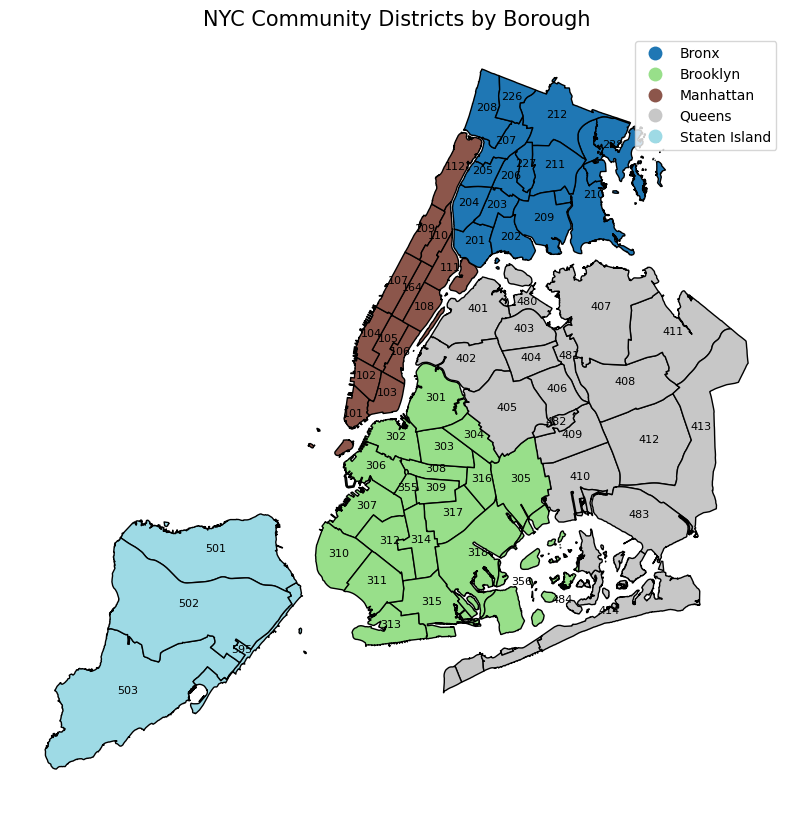

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))

districts_gdf.plot(ax=ax, column='BOROUGH', legend=True, cmap='tab20', edgecolor='black')

for idx, row in districts_gdf.iterrows():
    plt.text(row.geometry.centroid.x, row.geometry.centroid.y,
             row['boro_cd'], fontsize=8, ha='center', color='black')

ax.set_title('NYC Community Districts by Borough', fontsize=15)
ax.axis('off')

plt.show()

In the following steps we will transform the datasets used into GeoDataFrames with geospatial capabilities.
 
By doing this:
  - The dataset can now handle geospatial operations like spatial joins, distance calculations, or plotting on maps.
  - The geometry of each record is correctly formatted and accessible for GIS-related analysis.

The following code chunks transform the datasets into GeoDataFrames by converting the geocoded locations into geometries using the Point object and setting the coordinate reference system (CRS) to EPSG:4326, which defines the first axis as latitude and the second as longitude. It then performs a spatial join with the NYC community districts, mapping each shooting, crime or POI to the appropriate community district based on its geographic location. This adds relevant borough and district information to the dataset for further analysis.

### Shooting

In [11]:
shooting_df['geometry'] = shooting_df['geocoded_column'].apply(loads)

shooting_gdf = gpd.GeoDataFrame(
    shooting_df,
    geometry='geometry',
    crs="EPSG:4326"  # Assuming WGS84 latitude/longitude
)

shooting_gdf = gpd.sjoin(shooting_gdf, districts_gdf[['geometry', 'boro_cd']], how='left', predicate='within')
shooting_gdf = shooting_gdf[['statistical_murder_flag', 'geometry', 'boro_cd']]
shooting_gdf.head()

statistical_murder_flag                    geometry boro_cd
0                       N  POINT (-73.76493 40.59922)     414
1                       N   POINT (-73.8147 40.73569)     408
2                       Y  POINT (-73.95966 40.67101)     309
3                       N  POINT (-73.91898 40.82847)     204
4                       Y  POINT (-73.98353 40.72605)     103

### Crime

In [12]:
complaint_df['geometry'] = complaint_df['New Georeferenced Column'].apply(loads)

crime_gdf = gpd.GeoDataFrame(
    complaint_df,
    geometry='geometry',
    crs="EPSG:4326"  # Assuming WGS84 latitude/longitude
)

crime_gdf = gpd.sjoin(crime_gdf, districts_gdf[['geometry', 'boro_cd']], how='left', predicate='within')
crime_gdf = crime_gdf[['LAW_CAT_CD', 'geometry', 'boro_cd']]
crime_gdf.head()

LAW_CAT_CD                    geometry boro_cd
0       FELONY  POINT (-73.84727 40.88731)     212
1    VIOLATION  POINT (-74.17854 40.55948)     503
2       FELONY  POINT (-74.12361 40.63404)     501
3  MISDEMEANOR  POINT (-74.21399 40.53685)     503
4       FELONY  POINT (-74.21674 40.54256)     503

### POI

In [13]:
poi_df['geometry'] = poi_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

poi_gdf = gpd.GeoDataFrame(
    poi_df,
    geometry='geometry',
    crs="EPSG:4326"  # Assuming WGS84 latitude/longitude
)

columns_to_keep = [
    'boro_cd',
    'Residential',
    'Education Facility',
    'Cultural Facility',
    'Recreational Facility',
    'Social Services',
    'Transportation Facility',
    'Commercial',
    'Government Facility',
    'Religious Institution',
    'Health Services',
    'Public Safety',
    'Water',
    'Miscellaneous',
    'geometry'
]

poi_gdf = gpd.sjoin(poi_gdf, districts_gdf[['geometry', 'boro_cd']], how='left', predicate='within')
poi_gdf = poi_gdf[columns_to_keep]
poi_gdf.head()

boro_cd  Residential  Education Facility  Cultural Facility  \
0     102            0                   0                  0   
1     407            0                   0                  0   
2     302            0                   0                  0   
3     103            0                   0                  0   
4     NaN            0                   0                  0   

   Recreational Facility  Social Services  Transportation Facility  \
0                      0                0                        1   
1                      0                0                        1   
2                      0                0                        1   
3                      0                0                        1   
4                      0                0                        1   

   Commercial  Government Facility  Religious Institution  Health Services  \
0           0                    0                      0                0   
1           0                    0                      0                0   
2           0                    0                      0                0   
3           0                    0                      0                0   
4           0                    0                      0                0   

   Public Safety  Water  Miscellaneous                    geometry  
0              0      0              0  POINT (-74.00702 40.72463)  
1              0      0              0  POINT (-73.82662 40.79718)  
2              0      0              0  POINT (-73.99395 40.70385)  
3              0      0              0   POINT (-73.99194 40.7096)  
4              0      0              0  POINT (-73.95266 40.73907)

### AirBnB

In [30]:
uniqueID_airbnb['geometry'] = airbnb_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

uniqueID_airbnb = gpd.GeoDataFrame(
    uniqueID_airbnb,
    geometry='geometry',
    crs="EPSG:4326"  # Assuming WGS84 latitude/longitude
)

columns_to_keep = ['id','room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'number_of_reviews', 'review_scores_rating','geometry']

uniqueID_airbnb = uniqueID_airbnb[columns_to_keep]

## Creating Binary Indicator Features

For further analyis we create binary indicator features to simplify the aggregation and analysis process. By converting categorical data (e.g., crime types or shooting outcomes) into numeric columns, we can:

- Easily count the occurrences of specific categories (e.g., felonies, violations, fatal shootings) during spatial joins or group-by operations.
- Generate meaningful and distinct statistics for each Airbnb location based on the surrounding data.
- Streamline the feature extraction process for further analysis or modeling.

This approach ensures a structured and efficient way to handle categorical information in geospatial datasets.


### Crime:
To gain a quick overview of the numbers and distributions in the dataset, we visualize key statistics. In the following we categorize crimes by law type, aggregates them by community district, and visualizes the counts of each crime category per district in a stacked bar chart.

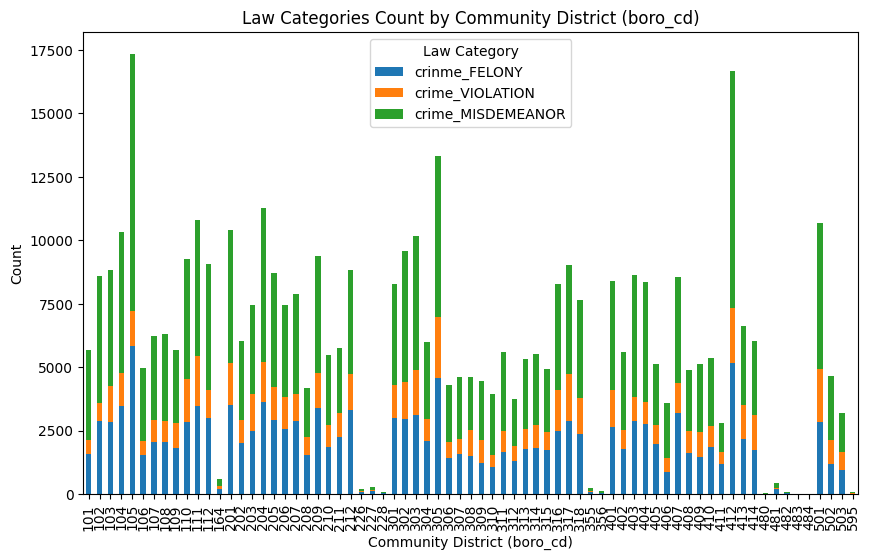

In [15]:
crime_gdf['crinme_FELONY'] = (crime_gdf['LAW_CAT_CD'] == 'FELONY').astype(int)
crime_gdf['crime_VIOLATION'] = (crime_gdf['LAW_CAT_CD'] == 'VIOLATION').astype(int)
crime_gdf['crime_MISDEMEANOR'] = (crime_gdf['LAW_CAT_CD'] == 'MISDEMEANOR').astype(int)

aggregated_crime = crime_gdf.groupby('boro_cd')[['crinme_FELONY', 'crime_VIOLATION', 'crime_MISDEMEANOR']].sum().reset_index()
aggregated_crime.set_index('boro_cd').plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Law Categories Count by Community District (boro_cd)')
plt.xlabel('Community District (boro_cd)')
plt.ylabel('Count')
plt.legend(title='Law Category')
plt.show()

It is evident that some districts have experienced very few crimes compared to others with the range spanning from 0 to 17.500. Additionally, the 'Violation' crime category is the least represented across the districts.

### Shooting:
To gain a quick overview of the numbers and distributions in the dataset, we visualize key statistics. The following code creates binary indicators for deathly and non-deathly shootings, aggregates the counts by district, and visualizes the results in a stacked bar chart to compare the distribution of shooting outcomes across community districts.

<Axes: xlabel='boro_cd'>

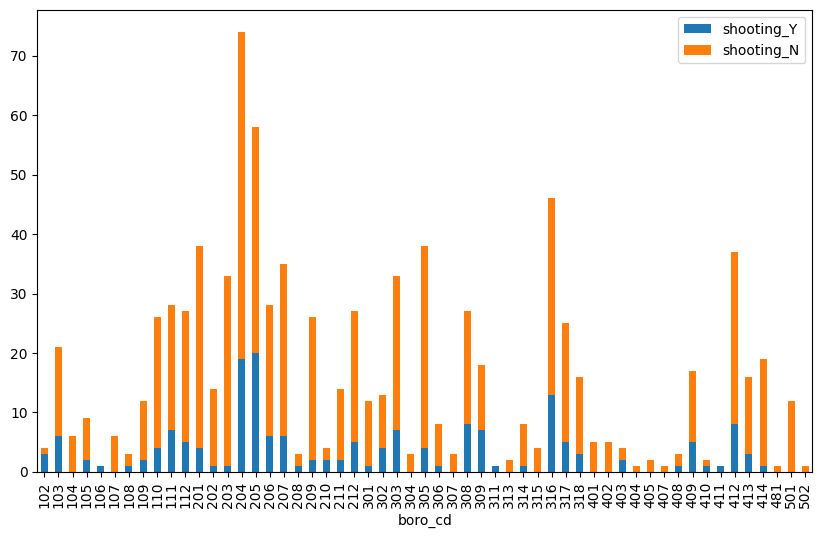

In [ ]:
shooting_gdf['shooting_Y'] = (shooting_gdf['statistical_murder_flag'] == 'Y').astype(int)
shooting_gdf['shooting_N'] = (shooting_gdf['statistical_murder_flag'] == 'N').astype(int)

aggregated_shooting = shooting_gdf.groupby('boro_cd')[['shooting_Y', 'shooting_N']].sum().reset_index()
aggregated_shooting.set_index('boro_cd').plot(kind='bar', stacked=True, figsize=(10, 6))

It can be seen that some districts have very few shootings compared to others, with the range spanning from just 1 to over 70 shootings. Additionally, the majority of shootings are non-fatal.

## Aggregation Approach

Now we will adopt a buffer-based aggregation method that creates a geospatially enrichted dataset that better reflects the diversity and complexity fo NYC's neighborhoods and their impact on AirBnB listings.

- **Why Not Aggregate by Boroughs?**  
  Aggregating Airbnb data by boroughs would result in all AirBnB entries within the same borough having identical feature sets. This limits the granularity of the analysis and the ability to capture localized variations within the city.

- **Our Solution: Buffer-Based Aggregation**  
Instead of aggregating by borough or community district, we create **buffer zones** around each Airbnb location and aggregate the data from all features that fall within that zone. This approach allows us to capture the specific characteristics of the area surrounding each listing, ensuring that each AirBnB entry has unique, localized statistics. This method enables us to preserve spatial nuances and avoids over-generalization.

In [31]:
uniqueID_airbnb.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 26270 entries, 0 to 26269
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   id                    26270 non-null  int64   
 1   room_type             26270 non-null  object  
 2   accommodates          26270 non-null  int64   
 3   bathrooms             26270 non-null  int64   
 4   bedrooms              26270 non-null  float64 
 5   beds                  26270 non-null  float64 
 6   price                 26270 non-null  float64 
 7   number_of_reviews     26270 non-null  int64   
 8   review_scores_rating  26270 non-null  float64 
 9   geometry              26270 non-null  geometry
dtypes: float64(4), geometry(1), int64(4), object(1)
memory usage: 2.0+ MB


In the following code chunks: 

 1. All datasets are transformed to the same coordinate reference system: EPSG:3857 (Web Mercator)
      -  This ensures consistency for geospatial operations like spatial joins or buffering, as differing CRS's can cause errors.
 2. The geometry of features (e.g., shapes, polygons) are simplified to reduce computational complexity without losing essential spatial information.
    - This is useful for faster processing during spatial joins and visualizations
 3. Buffer zone of 3000 meters around each AirBnB location are created. The buffer defines the area of interest for aggregating nearby features (e.g., crimes, POIs).
      - Updates the geometry column to use the buffer for subsequent spatial operations.

In [32]:
uniqueID_airbnb = uniqueID_airbnb.to_crs(epsg=3857)
shooting_gdf = shooting_gdf.to_crs(epsg=3857)
crime_gdf = crime_gdf.to_crs(epsg=3857)
poi_gdf = poi_gdf.to_crs(epsg=3857)

shooting_gdf = shooting_gdf[['statistical_murder_flag', 'geometry']]
crime_gdf = crime_gdf[['LAW_CAT_CD', 'geometry']]
poi_gdf = poi_gdf.drop(columns=['boro_cd'], errors='ignore')  # Keep all necessary POI columns

In [33]:
crime_gdf['geometry'] = crime_gdf.geometry.simplify(tolerance=10)
uniqueID_airbnb['geometry'] = uniqueID_airbnb.geometry.simplify(tolerance=10)

In [34]:
uniqueID_airbnb['buffer'] = uniqueID_airbnb.geometry.buffer(3000)
uniqueID_airbnb = uniqueID_airbnb.set_geometry('buffer')

### Perform spatial join with shootings

Now let's performs a spatial join between the shooting data and the AirBnB listings data to identify shootings that occurred within the proximity of each listing. It then aggregates the data by each AirBnB listing ID, counting the total number of shootings and the number of deathly shootings (where *statistical_murder_flag* is 'Y') that occurred within the buffer zone of each listing. The result is a DataFrame with aggregated shooting counts for each Airbnb listing.

In [35]:
shooting_nearby = gpd.sjoin(shooting_gdf, uniqueID_airbnb, predicate='within')

shooting_agg = shooting_nearby.groupby('id', as_index=False).agg(
    shooting_count=('statistical_murder_flag', 'count'),
    murder_count=('statistical_murder_flag', lambda x: (x == 'Y').sum())
)

In [36]:
shooting_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25719 entries, 0 to 25718
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              25719 non-null  int64
 1   shooting_count  25719 non-null  int64
 2   murder_count    25719 non-null  int64
dtypes: int64(3)
memory usage: 602.9 KB


### Performing Spatial Join with the Crime Dataset

Now we want to do the same with the Crime Dataset. However, given the computational expense of spatial joins and the large size of the datasets (over 26,000 Airbnb entries and more than 430,000 crime entries), the process is streamlined by dividing the data into chunks. This approach ensures efficient memory usage and prevents buffer overflow by processing smaller subsets of data and clearing memory after each iteration.
The process will be saved in an extern csv file.

In [127]:
# import gc  # For garbage collection

# chunk_size = 5000
# crime_chunks = [crime_gdf.iloc[i:i + chunk_size] for i in range(0, len(crime_gdf), chunk_size)]

# # Open a file to write results incrementally
# with open('crime_aggregated_resultsUNIQUE.csv', 'w') as result_file:
#     # Process each chunk
#     for i, chunk in enumerate(crime_chunks):
#         print(f"Processing chunk {i + 1} of {len(crime_chunks)}")
        
#         # Perform spatial join
#         crime_nearby = gpd.sjoin(chunk, uniqueID_airbnb, predicate='within')
        
#         # Ensure 'id' column is available
#         if 'id' not in crime_nearby.columns:
#             crime_nearby = crime_nearby.merge(uniqueID_airbnb[['id']], left_index=True, right_index=True, how='left')
        
#         # Aggregate crime data
#         crime_agg = crime_nearby.groupby('id').agg(
#             felony_count=('LAW_CAT_CD', lambda x: (x == 'FELONY').sum()),
#             misdemeanor_count=('LAW_CAT_CD', lambda x: (x == 'MISDEMEANOR').sum()),
#             violation_count=('LAW_CAT_CD', lambda x: (x == 'VIOLATION').sum())
#         )
        
#         # Save the chunk to the CSV incrementally
#         crime_agg.to_csv(result_file, header=(i == 0), mode='a')  # Write header only for the first chunk
        
#         # Clean up memory
#         del crime_nearby, crime_agg
#         gc.collect()  # Trigger garbage collection explicitly


Processing chunk 1 of 87
Processing chunk 2 of 87
Processing chunk 3 of 87
Processing chunk 4 of 87
Processing chunk 5 of 87
Processing chunk 6 of 87
Processing chunk 7 of 87
Processing chunk 8 of 87
Processing chunk 9 of 87
Processing chunk 10 of 87
Processing chunk 11 of 87
Processing chunk 12 of 87
Processing chunk 13 of 87
Processing chunk 14 of 87
Processing chunk 15 of 87
Processing chunk 16 of 87
Processing chunk 17 of 87
Processing chunk 18 of 87
Processing chunk 19 of 87
Processing chunk 20 of 87
Processing chunk 21 of 87
Processing chunk 22 of 87
Processing chunk 23 of 87
Processing chunk 24 of 87
Processing chunk 25 of 87
Processing chunk 26 of 87
Processing chunk 27 of 87
Processing chunk 28 of 87
Processing chunk 29 of 87
Processing chunk 30 of 87
Processing chunk 31 of 87
Processing chunk 32 of 87
Processing chunk 33 of 87
Processing chunk 34 of 87
Processing chunk 35 of 87
Processing chunk 36 of 87
Processing chunk 37 of 87
Processing chunk 38 of 87
Processing chunk 39 o

### Performing Spatial Join with the POI Dataset

The same is done here for the Points of Interest.

In [128]:

# columns_to_keep = [
    
#     'Residential',
#     'Education Facility',
#     'Cultural Facility',
#     'Recreational Facility',
#     'Social Services',
#     'Transportation Facility',
#     'Commercial',
#     'Government Facility',
#     'Religious Institution',
#     'Health Services',
#     'Public Safety',
#     'Water',
#     'Miscellaneous',
#     'geometry'
# ]

# # Filter the dataset to keep only the specified columns
# poi_gdf = poi_gdf[columns_to_keep]
# poi_gdf['geometry'] = poi_gdf.geometry.simplify(tolerance=10)

# chunk_size = 400
# poi_chunks = [poi_gdf.iloc[i:i + chunk_size] for i in range(0, len(poi_gdf), chunk_size)]

# # Open a file to write results incrementally
# with open('poi_aggregated_resultsUNIQUE.csv', 'w') as result_file:
#     # Process each chunk
#     for i, chunk in enumerate(poi_chunks):
#         print(f"Processing chunk {i + 1} of {len(poi_chunks)}")
        
#         # Perform spatial join with airbnb dataset (within a 3000-meter radius)
#         # Use buffer(3000) to create a radius around the Airbnb geometry
#         uniqueID_airbnb['buffered_geometry'] = uniqueID_airbnb.geometry.buffer(3000)
#         crime_nearby = gpd.sjoin(
#             chunk,
#             uniqueID_airbnb.set_geometry('buffered_geometry'),  # Use buffered geometry
#             predicate='within'
#         )
        
#         # Ensure 'id' column is available
#         if 'id' not in crime_nearby.columns:
#             crime_nearby = crime_nearby.merge(
#                 uniqueID_airbnb[['id']], left_index=True, right_index=True, how='left'
#             )
        
#         # Aggregate POI features within the radius
#         poi_agg = crime_nearby.groupby('id').agg({
#             'Residential': 'sum',
#             'Education Facility': 'sum',
#             'Cultural Facility': 'sum',
#             'Recreational Facility': 'sum',
#             'Social Services': 'sum',
#             'Transportation Facility': 'sum',
#             'Commercial': 'sum',
#             'Government Facility': 'sum',
#             'Religious Institution': 'sum',
#             'Health Services': 'sum',
#             'Public Safety': 'sum',
#             'Water': 'sum',
#             'Miscellaneous': 'sum',
#         })
        
#         # Save the chunk to the CSV incrementally
#         poi_agg.to_csv(result_file, header=(i == 0), mode='a')  # Write header only for the first chunk
        
#         # Clean up memory
#         del crime_nearby, poi_agg
#         gc.collect()  # Trigger garbage collection explicitly

# print("Processing completed.")


Processing chunk 1 of 51
Processing chunk 2 of 51
Processing chunk 3 of 51
Processing chunk 4 of 51
Processing chunk 5 of 51
Processing chunk 6 of 51
Processing chunk 7 of 51
Processing chunk 8 of 51
Processing chunk 9 of 51
Processing chunk 10 of 51
Processing chunk 11 of 51
Processing chunk 12 of 51
Processing chunk 13 of 51
Processing chunk 14 of 51
Processing chunk 15 of 51
Processing chunk 16 of 51
Processing chunk 17 of 51
Processing chunk 18 of 51
Processing chunk 19 of 51
Processing chunk 20 of 51
Processing chunk 21 of 51
Processing chunk 22 of 51
Processing chunk 23 of 51
Processing chunk 24 of 51
Processing chunk 25 of 51
Processing chunk 26 of 51
Processing chunk 27 of 51
Processing chunk 28 of 51
Processing chunk 29 of 51
Processing chunk 30 of 51
Processing chunk 31 of 51
Processing chunk 32 of 51
Processing chunk 33 of 51
Processing chunk 34 of 51
Processing chunk 35 of 51
Processing chunk 36 of 51
Processing chunk 37 of 51
Processing chunk 38 of 51
Processing chunk 39 o

Now we load the aggregated csv files we have just created.

In [112]:
df_crime_aggreggated = pd.read_csv('crime_aggregated_resultsUNIQUE.csv')
df_crime_aggreggated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 635060 entries, 0 to 635059
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   id                 635060 non-null  int64
 1   felony_count       635060 non-null  int64
 2   misdemeanor_count  635060 non-null  int64
 3   violation_count    635060 non-null  int64
dtypes: int64(4)
memory usage: 19.4 MB


In [113]:
df_poi_aggreggated = pd.read_csv('poi_aggregated_resultsUNIQUE.csv')
df_poi_aggreggated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1335043 entries, 0 to 1335042
Data columns (total 14 columns):
 #   Column                   Non-Null Count    Dtype
---  ------                   --------------    -----
 0   id                       1335043 non-null  int64
 1   Residential              1335043 non-null  int64
 2   Education Facility       1335043 non-null  int64
 3   Cultural Facility        1335043 non-null  int64
 4   Recreational Facility    1335043 non-null  int64
 5   Social Services          1335043 non-null  int64
 6   Transportation Facility  1335043 non-null  int64
 7   Commercial               1335043 non-null  int64
 8   Government Facility      1335043 non-null  int64
 9   Religious Institution    1335043 non-null  int64
 10  Health Services          1335043 non-null  int64
 11  Public Safety            1335043 non-null  int64
 12  Water                    1335043 non-null  int64
 13  Miscellaneous            1335043 non-null  int64
dtypes: int64(14)
memor

### Merging

Finally for further analysis we merge the aggregated datasets. The crime and shooting datasets are merged using an outer join on the *id* column. This ensures that all AirBnB entries are retained, even if some do not have corresponding shooting statistics.

In [135]:
merged_cime_shooting_airbnb = df_crime_aggreggated.merge(shooting_agg, on='id', how='outer')
merged_cime_shooting_airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26270 entries, 0 to 26269
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 26270 non-null  int64  
 1   felony_count       26270 non-null  int64  
 2   misdemeanor_count  26270 non-null  int64  
 3   violation_count    26270 non-null  int64  
 4   shooting_count     25668 non-null  float64
 5   murder_count       25668 non-null  float64
dtypes: float64(2), int64(4)
memory usage: 1.2 MB


Now this dataset is further merged with the POI dataset also using an outerjoin on the *id* column.

In [136]:
final = merged_cime_shooting_airbnb.merge(df_poi_aggreggated, on='id', how='outer')
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26270 entries, 0 to 26269
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       26270 non-null  int64  
 1   felony_count             26270 non-null  int64  
 2   misdemeanor_count        26270 non-null  int64  
 3   violation_count          26270 non-null  int64  
 4   shooting_count           25668 non-null  float64
 5   murder_count             25668 non-null  float64
 6   Residential              26270 non-null  int64  
 7   Education Facility       26270 non-null  int64  
 8   Cultural Facility        26270 non-null  int64  
 9   Recreational Facility    26270 non-null  int64  
 10  Social Services          26270 non-null  int64  
 11  Transportation Facility  26270 non-null  int64  
 12  Commercial               26270 non-null  int64  
 13  Government Facility      26270 non-null  int64  
 14  Religious Institution 

Finally, all aggregated features (crime, shooting, and points of interest) are merged with the AirBnB dataset. This final merge ensures that each Airbnb listing has a complete set of geospatially enriched features for analysis.

In [137]:
final = final.merge(uniqueID_airbnb, on='id', how='outer')
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26270 entries, 0 to 26269
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   id                       26270 non-null  int64   
 1   felony_count             26270 non-null  int64   
 2   misdemeanor_count        26270 non-null  int64   
 3   violation_count          26270 non-null  int64   
 4   shooting_count           25668 non-null  float64 
 5   murder_count             25668 non-null  float64 
 6   Residential              26270 non-null  int64   
 7   Education Facility       26270 non-null  int64   
 8   Cultural Facility        26270 non-null  int64   
 9   Recreational Facility    26270 non-null  int64   
 10  Social Services          26270 non-null  int64   
 11  Transportation Facility  26270 non-null  int64   
 12  Commercial               26270 non-null  int64   
 13  Government Facility      26270 non-null  int64   
 14  Religi

The final dataset is saved as CSV file in the data folder.

In [138]:
final.to_csv('exports/final.csv', index=False)

## Result

To gain deeper insights into the clustering process, we visualized some samples of the final cluster to better comprehend the underlying patterns and relationships.


C:\Users\1\AppData\Local\Temp\ipykernel_876\797257190.py:44: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper left')


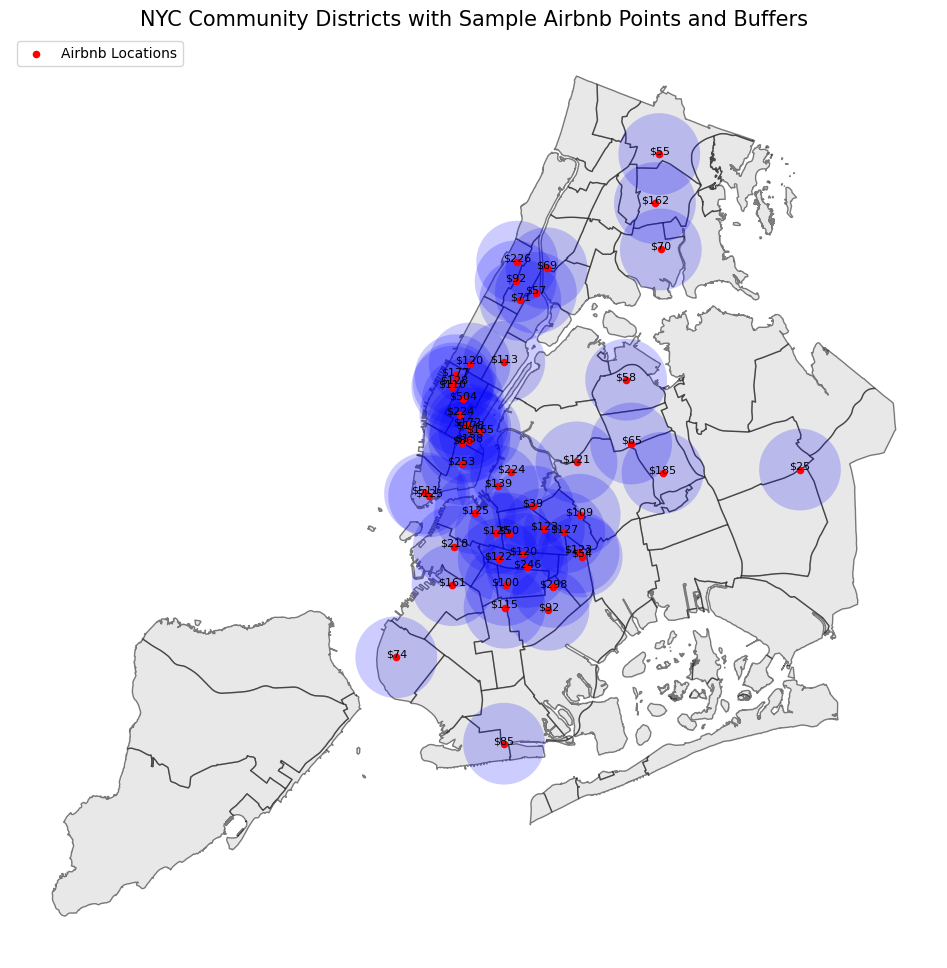

In [ ]:
clustered_df =  pd.read_csv('exports/final.csv')
clustered_df['geometry'] = clustered_df['geometry'].apply(loads)
clustered_df['buffer'] = clustered_df['buffer'].apply(loads)

airbnb_gdf = gpd.GeoDataFrame(clustered_df, geometry='geometry', crs="EPSG:3857")

districts_gdf = gpd.read_file('../../geo/Community Districts.geojson')

districts_gdf = districts_gdf.to_crs(airbnb_gdf.crs)
airbnb_gdf = airbnb_gdf[airbnb_gdf.geometry.notnull() & airbnb_gdf.geometry.is_valid]

sample_airbnb_gdf = airbnb_gdf.sample(50, random_state=450)

fig, ax = plt.subplots(figsize=(12, 12))

districts_gdf.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)

sample_airbnb_gdf.set_geometry('buffer').plot(ax=ax, color='blue', alpha=0.2, label='Buffer Radius')

sample_airbnb_gdf.set_geometry('geometry').plot(ax=ax, color='red', markersize=20, label='Airbnb Locations')

for idx, row in sample_airbnb_gdf.iterrows():
    ax.text(
        row.geometry.x, row.geometry.y,
        f"${row['price']:.0f}", fontsize=8, ha='center', color='black'
    )

ax.set_title('NYC Community Districts with Sample Airbnb Points and Buffers', fontsize=15)
ax.legend(loc='upper left')
ax.axis('off')

plt.show()



By observing the samples, we can already identify emerging patterns and potential hotspots. To gain more confidence in these observations, we will construct a heatmap using a significantly larger sample size.


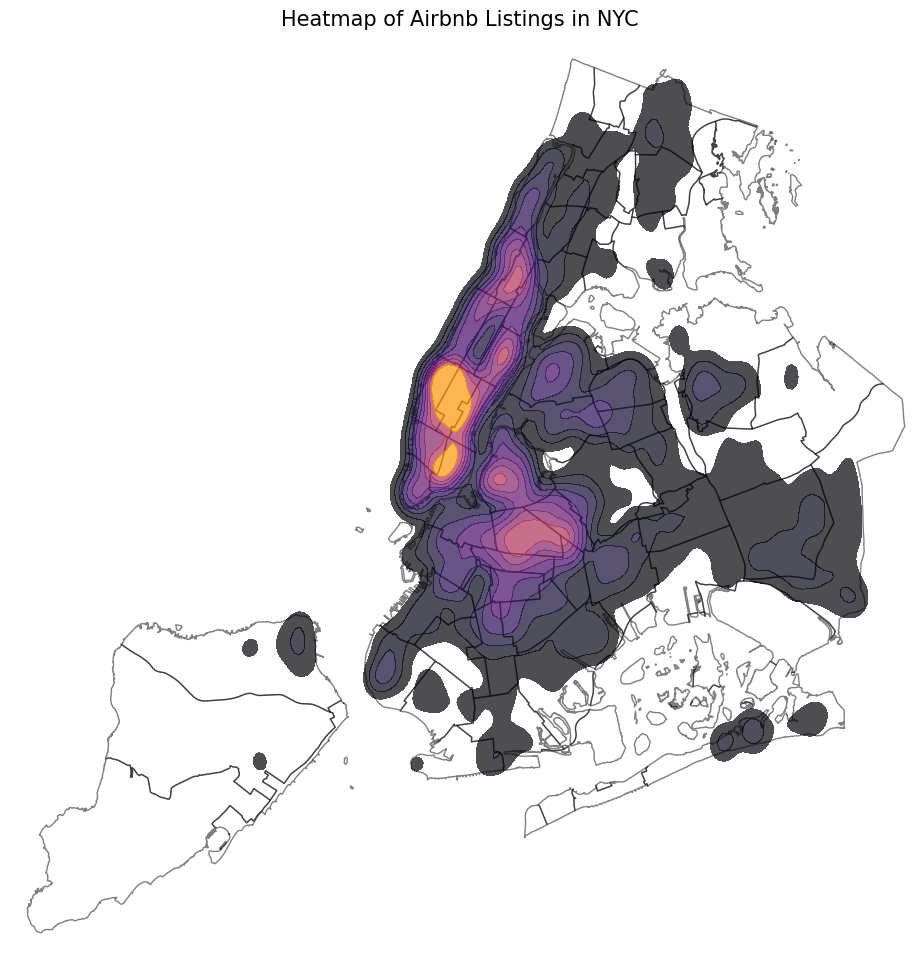

In [ ]:
airbnb_gdf = gpd.GeoDataFrame(clustered_df, geometry='geometry', crs="EPSG:3857")

districts_gdf = gpd.read_file('geo/Community Districts.geojson')

districts_gdf = districts_gdf.to_crs(airbnb_gdf.crs)

x_coords = airbnb_gdf.geometry.x
y_coords = airbnb_gdf.geometry.y

coords_df = pd.DataFrame({'x': x_coords, 'y': y_coords})

fig, ax = plt.subplots(figsize=(12, 12))

districts_gdf.plot(ax=ax, color='none', edgecolor='black', alpha=0.5)

sns.kdeplot(data=coords_df, x='x', y='y', fill=True, cmap='inferno', bw_adjust=0.5, alpha=0.7, ax=ax)

ax.set_title('Heatmap of Airbnb Listings in NYC', fontsize=15)
ax.axis('off')

plt.show()

**KDE Heatmap of Airbnb Listings in NYC**

This KDE heatmap visualizes the density of Airbnb listings in NYC, overlaid with district boundaries. 

- **Hotspots**: Bright yellow areas indicate high concentrations, primarily in Manhattan.
- **Cooler Regions**: Purple areas show lower densities, with minimal activity in Staten Island.
- **Context**: District boundaries provide spatial reference for the density distribution.

----

# Modelling the merged Dataset

## Preprocessing
### Read and Preview

Before building a model on our merged dataset, we need to preprocess the data and perform Exploratory Data Analysis (EDA) to gain valuable insights. To start, we will load the data generated from the clustering process.

In [32]:
file_path = "exports/final.csv"
df = pd.read_csv(file_path)
print(df.head())  
df.info()  

     id  felony_count  misdemeanor_count  violation_count  shooting_count  \
0  2595         11440              19575             3509            18.0   
1  5121          5451               9022             3259            65.0   
2  5136          1965               3083              861             7.0   
3  6848          4299               6385             2098            26.0   
4  6872          8594              13479             4685            68.0   

   murder_count  Residential  Education Facility  Cultural Facility  \
0           3.0          437                 600                254   
1          19.0          678                 588                 61   
2           1.0          129                 451                 45   
3           8.0          634                 665                115   
4          10.0          765                 655                 77   

   Recreational Facility  ...        room_type  accommodates  bathrooms  \
0                    474  ...  Enti

### Create Index

We set an index on the column *id* to ensures efficient data retrieval and faster lookups.

In [33]:
df.set_index(df['id'], drop = True, inplace = True)
df.drop(['id'], axis = 1, inplace = True)
print(df.head())
df.info()

      felony_count  misdemeanor_count  violation_count  shooting_count  \
id                                                                       
2595         11440              19575             3509            18.0   
5121          5451               9022             3259            65.0   
5136          1965               3083              861             7.0   
6848          4299               6385             2098            26.0   
6872          8594              13479             4685            68.0   

      murder_count  Residential  Education Facility  Cultural Facility  \
id                                                                       
2595           3.0          437                 600                254   
5121          19.0          678                 588                 61   
5136           1.0          129                 451                 45   
6848           8.0          634                 665                115   
6872          10.0          765      

As the columns *buffer* and *geometry* were only needed for clustering we can drop them now.

In [34]:
df = df.drop(['buffer', 'geometry'], axis=1)
print(df.head())

      felony_count  misdemeanor_count  violation_count  shooting_count  \
id                                                                       
2595         11440              19575             3509            18.0   
5121          5451               9022             3259            65.0   
5136          1965               3083              861             7.0   
6848          4299               6385             2098            26.0   
6872          8594              13479             4685            68.0   

      murder_count  Residential  Education Facility  Cultural Facility  \
id                                                                       
2595           3.0          437                 600                254   
5121          19.0          678                 588                 61   
5136           1.0          129                 451                 45   
6848           8.0          634                 665                115   
6872          10.0          765      

### Handle Missing Values

Now let's have a look at the missing values for each column.

In [35]:
missing_values = df.isnull().sum()
print(missing_values)

felony_count                 0
misdemeanor_count            0
violation_count              0
shooting_count             602
murder_count               602
Residential                  0
Education Facility           0
Cultural Facility            0
Recreational Facility        0
Social Services              0
Transportation Facility      0
Commercial                   0
Government Facility          0
Religious Institution        0
Health Services              0
Public Safety                0
Water                        0
Miscellaneous                0
room_type                    0
accommodates                 0
bathrooms                    0
bedrooms                     0
beds                         0
price                        0
number_of_reviews            0
review_scores_rating         0
dtype: int64


And the same for the rows:

In [36]:
null_data = df[df.isnull().any(axis=1)]
print(null_data.head())

        felony_count  misdemeanor_count  violation_count  shooting_count  \
id                                                                         
53477           1869               3821              707             NaN   
214917           493               1124              484             NaN   
503460           310                784              262             NaN   
639199           123                291              101             NaN   
765563           793                792              361             NaN   

        murder_count  Residential  Education Facility  Cultural Facility  \
id                                                                         
53477            NaN           45                 198                 29   
214917           NaN           93                 121                  8   
503460           NaN           31                  78                  7   
639199           NaN            0                  12                  4   
765563     

The missing columns are the result of some areas of New York that where not covered in the shooting data set. It would not make sense to replace this NaNs with mean/median values, as the areas in New York vary quite a lot when it comes to shootings. Furthermore, this is only a very small amount of data compared to the whole data set (2.3%). Therefore, we can simply delete the rows with NA values.  

In [37]:
df = df.dropna(axis = 0, how = 'any')
print(df.isnull().sum())

felony_count               0
misdemeanor_count          0
violation_count            0
shooting_count             0
murder_count               0
Residential                0
Education Facility         0
Cultural Facility          0
Recreational Facility      0
Social Services            0
Transportation Facility    0
Commercial                 0
Government Facility        0
Religious Institution      0
Health Services            0
Public Safety              0
Water                      0
Miscellaneous              0
room_type                  0
accommodates               0
bathrooms                  0
bedrooms                   0
beds                       0
price                      0
number_of_reviews          0
review_scores_rating       0
dtype: int64


### Data Types

The columns are already correctly typed, so there is no work to be done there. The only thing we want to analyse now if *room_type* can be turned into a categorical value.

In [38]:
print(df['room_type'].value_counts())
df['room_type'] = df['room_type'].astype('category')
print(df['room_type'].dtype) 

room_type
Entire home/apt    14208
Private room       10941
Shared room          352
Hotel room           167
Name: count, dtype: int64
category


### Visualization: Boxplots

We drop duplicated entries and create boxplots for all numerical columns (excluding *id*) to visualize the distribution and detect outliers for each column.

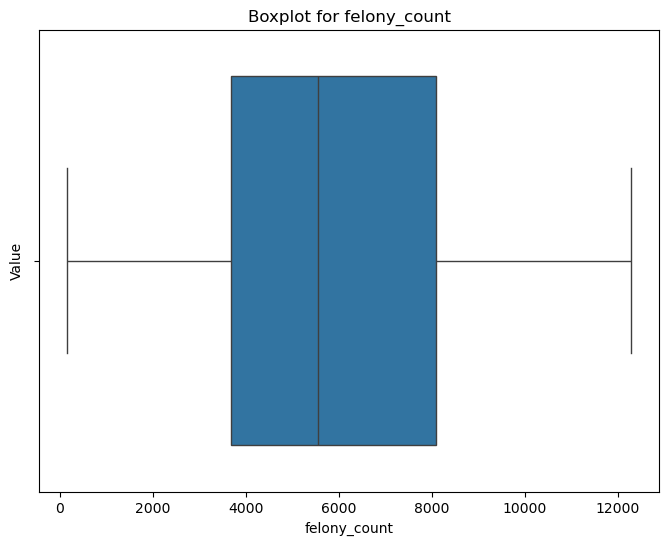

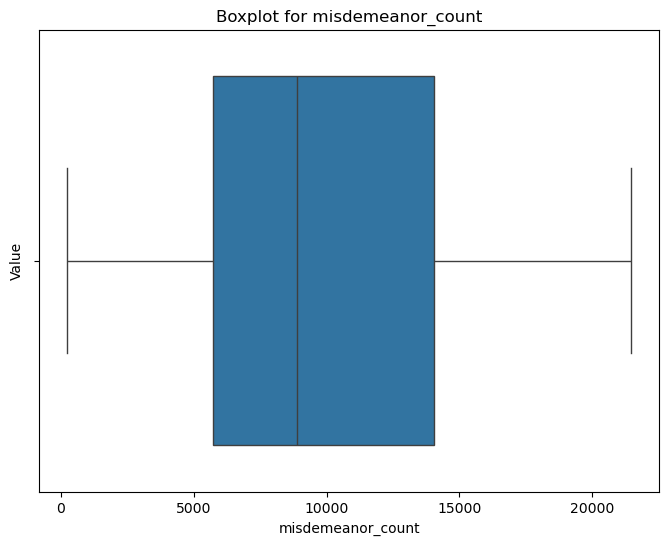

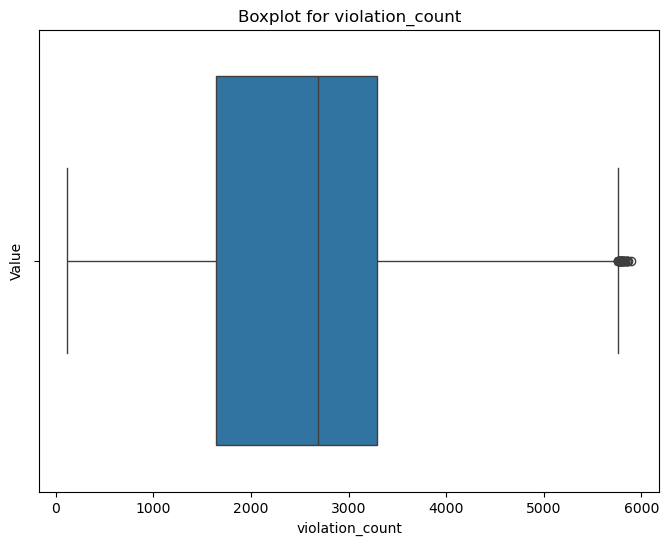

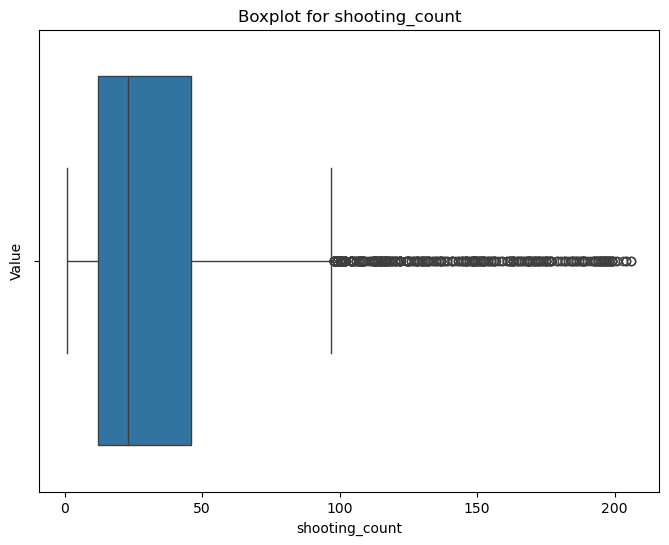

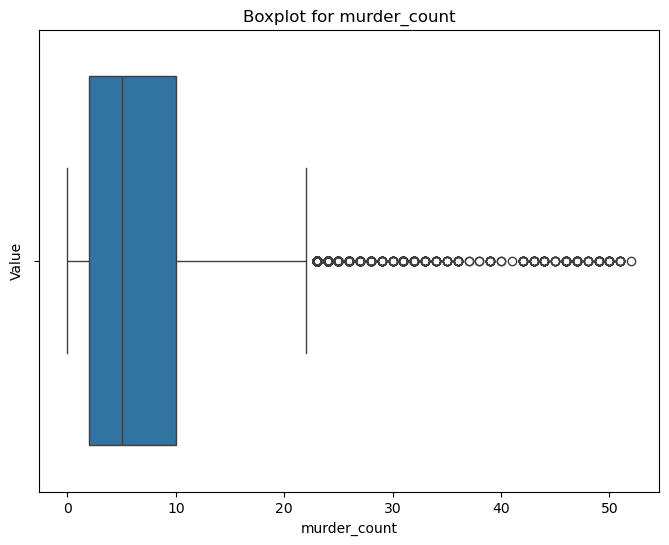

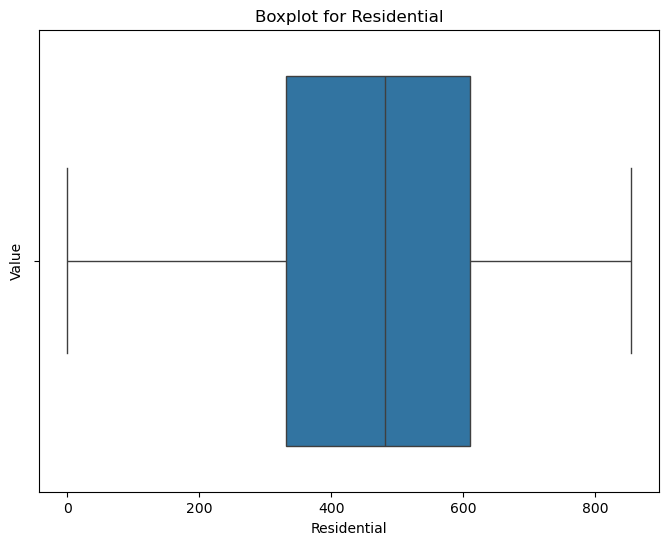

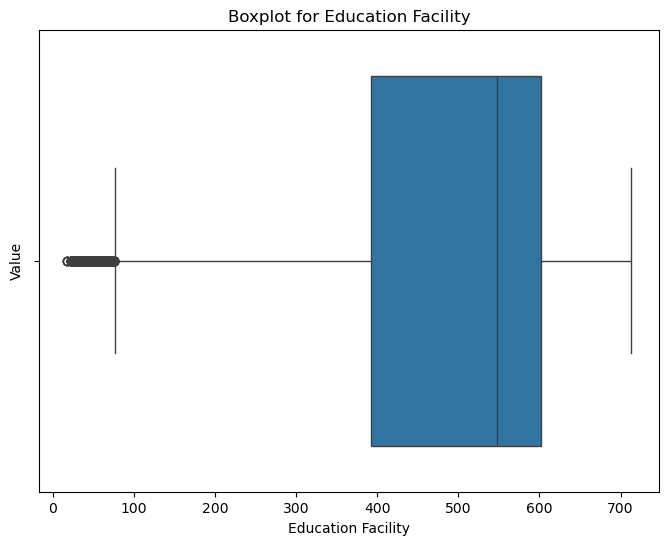

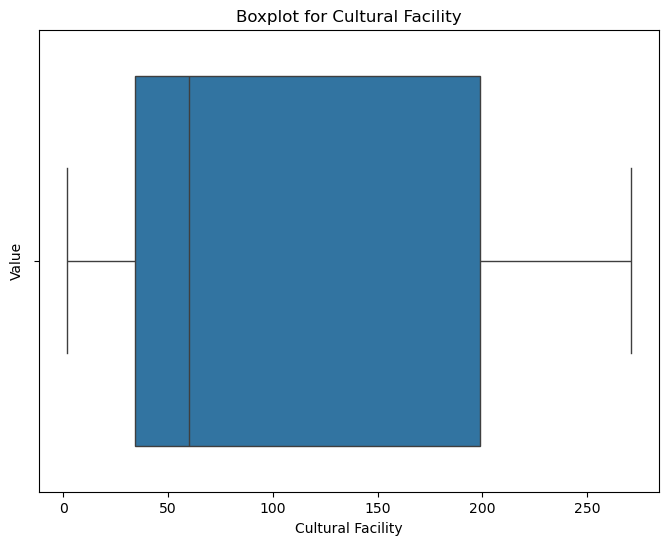

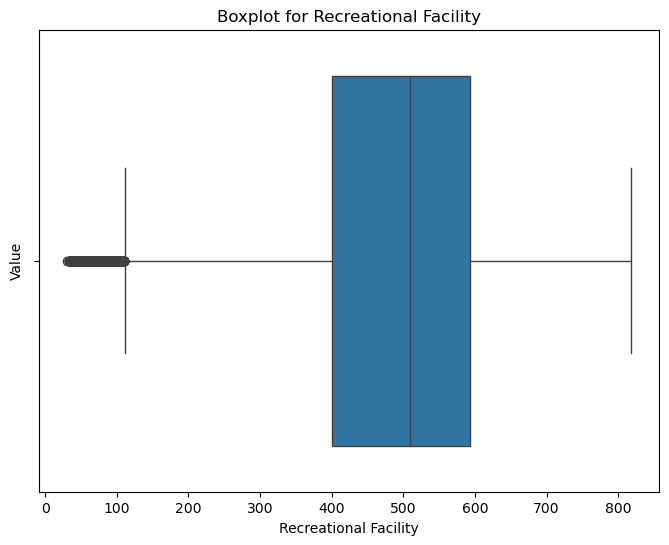

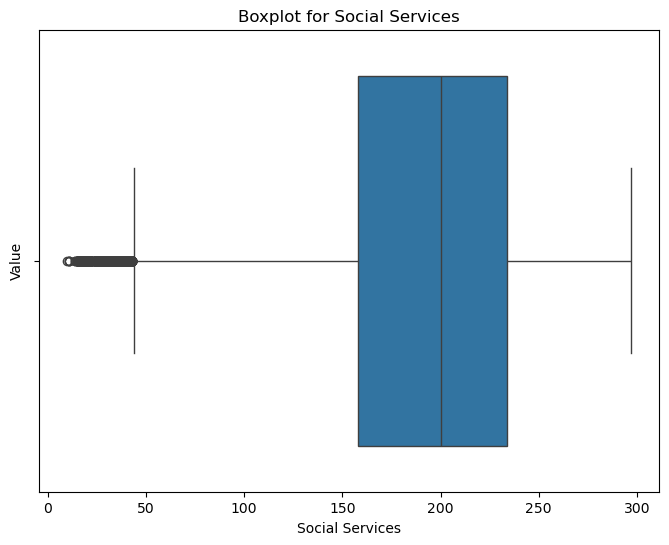

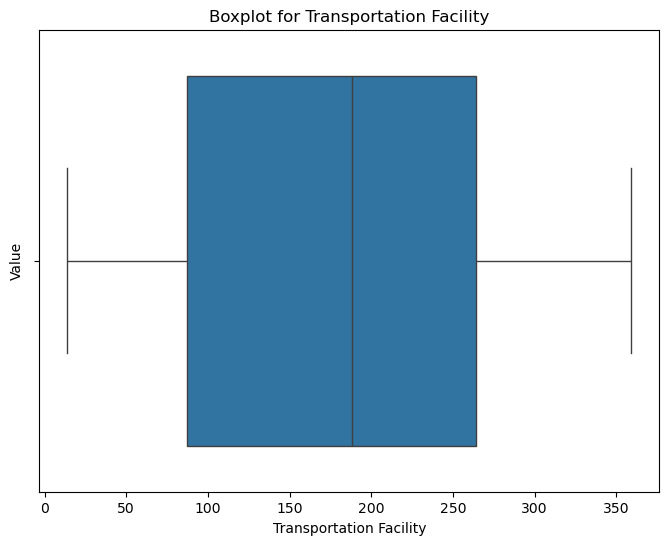

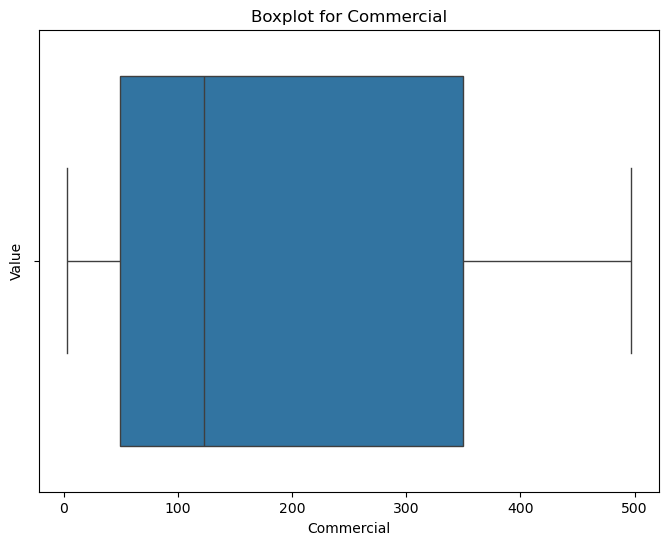

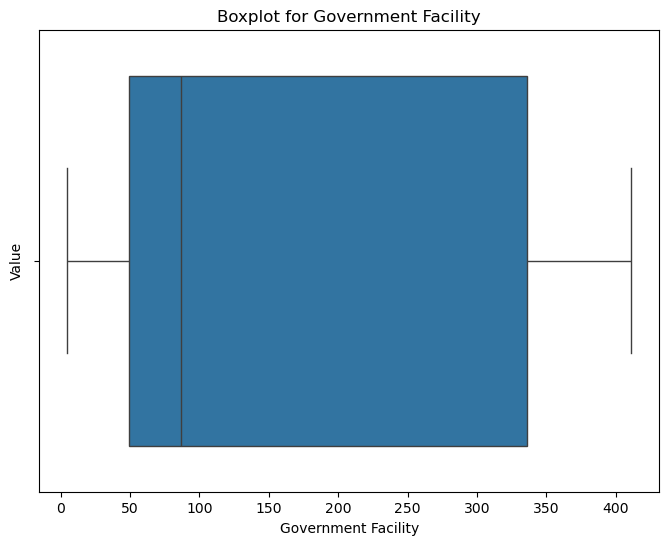

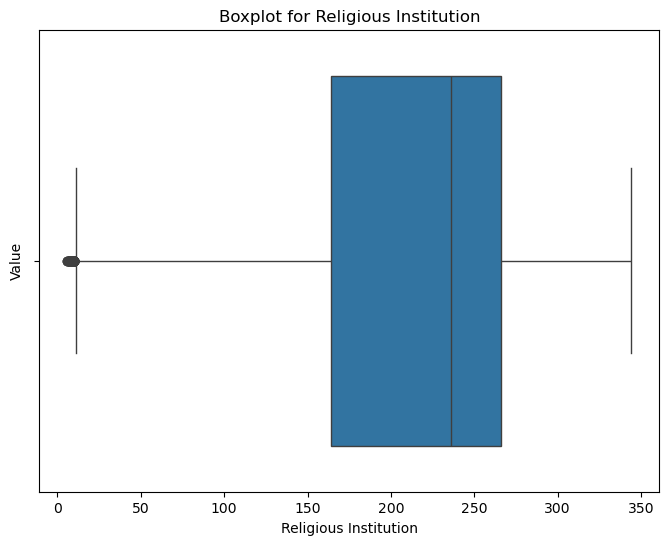

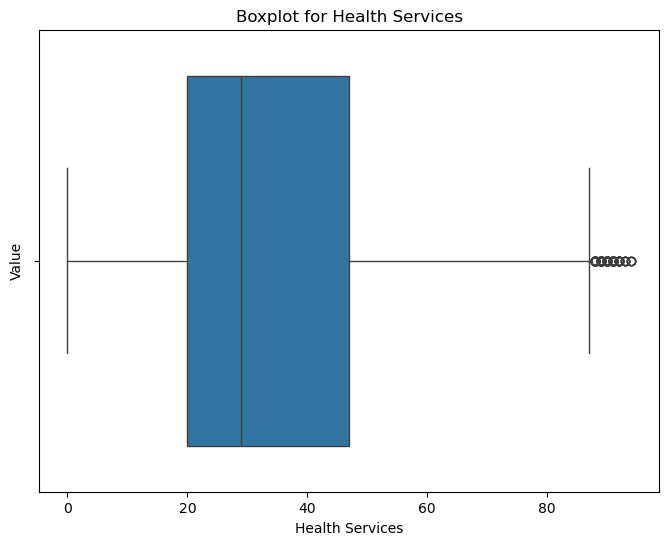

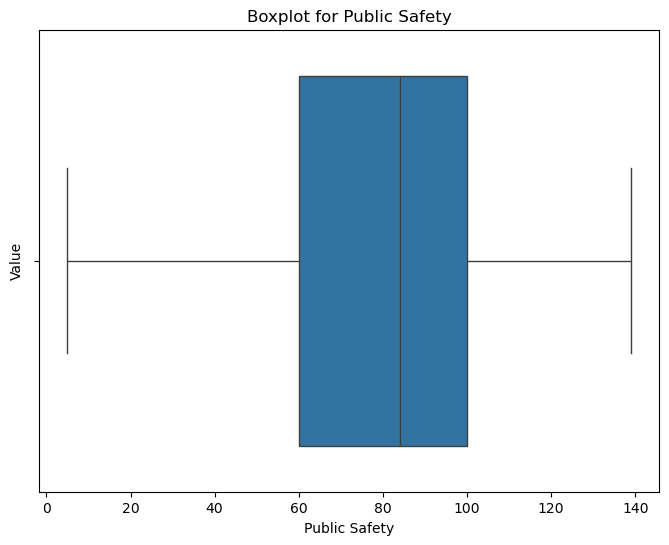

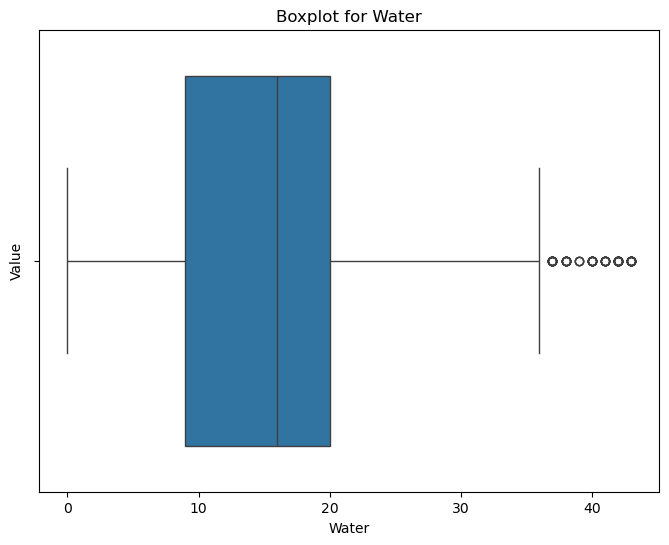

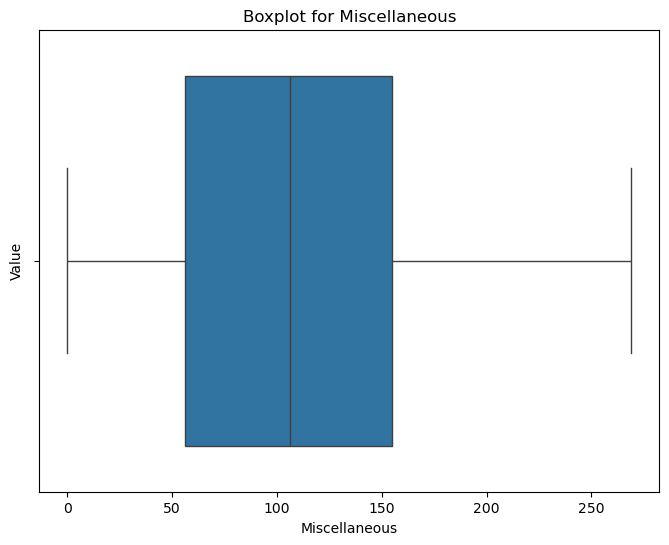

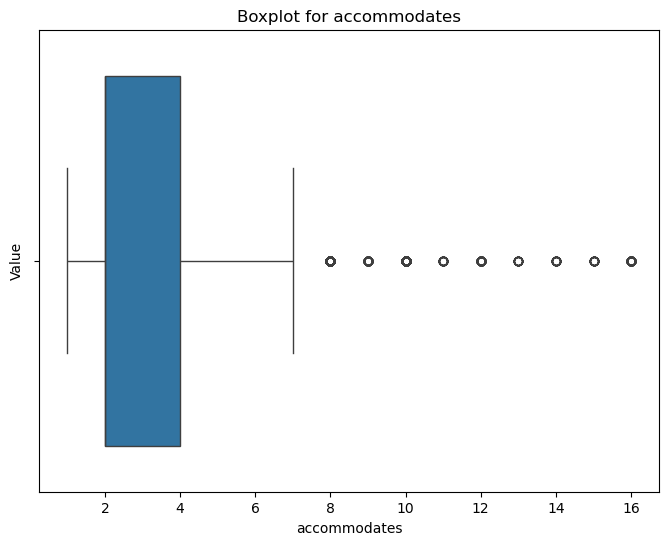

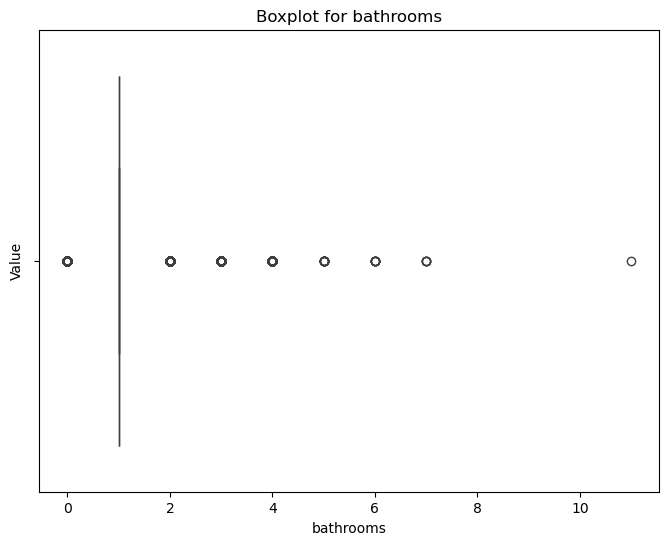

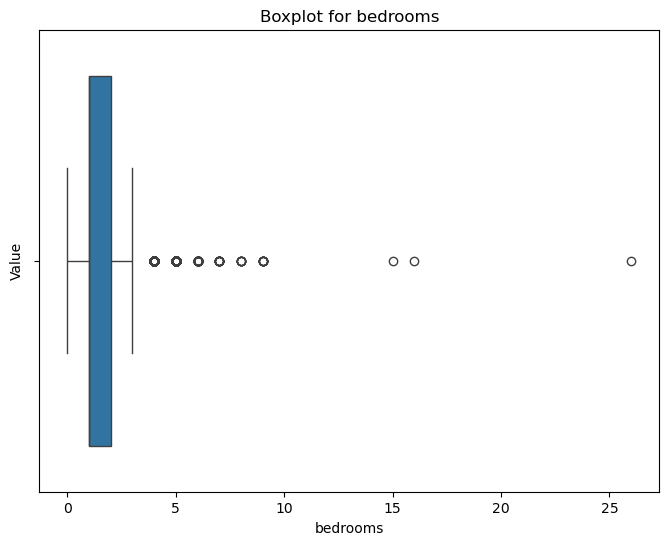

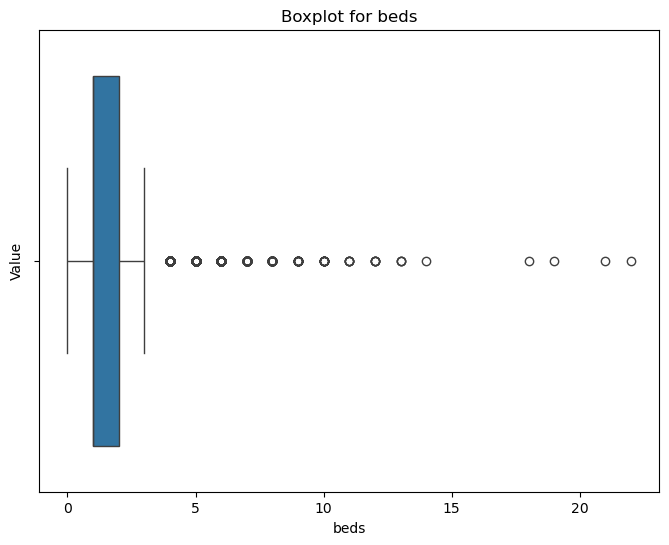

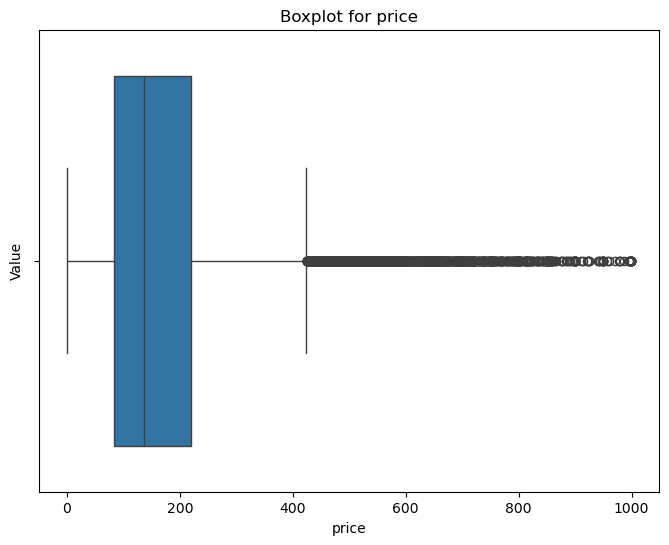

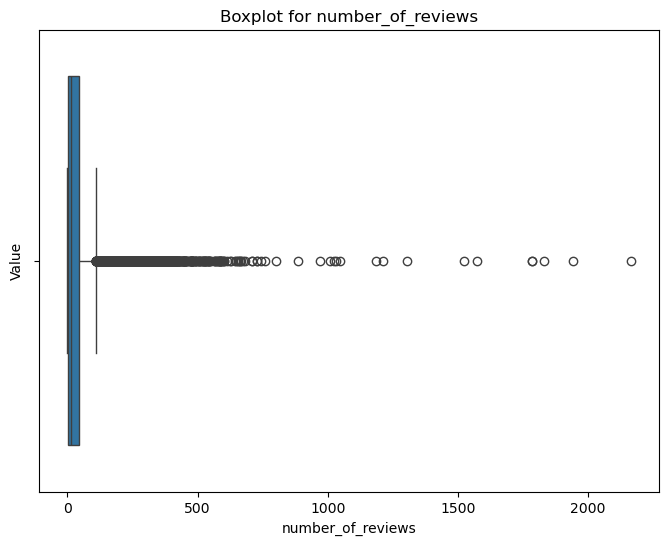

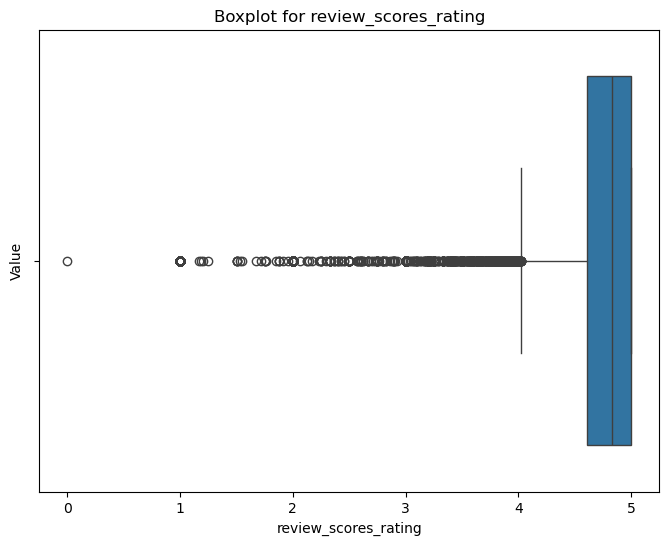

In [39]:
df = df.drop_duplicates() # Check for duplicates

# Boxplot for numerical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
for column in numerical_columns:
    if column != "id":
        plt.figure(figsize=(8, 6))
        sns.boxplot(data=df, x=column)
        plt.title(f'Boxplot for {column}')
        plt.xlabel(column)
        plt.ylabel('Value')
        plt.show()


Let's summarize the insights gained from this plots:

- **violation_count:** there are some outliers, which should be kept as they are valid data points and removing them would reduce the dataset's real-world applicability. As the data distribution is barely skewed, transformations are not necessary.
- **shooting_count:** very skewed and loads of (valid) outlier; initial approach log transform the variable and plot again.
- **murder_count:** very skewed and loads of (valid) outlier; initial approach log transform the variable and plot again.
- **Education Facility:** very skewed and loads of (valid) outlier; initial approach log transform the variable and plot again.
- **Recreational Facility:** loads of (valid) outlier; initial approach log transform the variable and plot again.
- **Social Services:** loads of (valid) outlier; initial approach log transform the variable and plot again.
- **Religious Institution:** there are some outliers, which should be kept as they are valid data points and removing them would reduce the dataset's real-world applicability. As the data distribution is barely skewed, transformations are not necessary.
- **Health Services:** there are some outliers, which should be kept as they are valid data points and removing them would reduce the dataset's real-world applicability. As the data distribution is barely skewed, transformations are not necessary.
- **Water:** there are some outliers, which should be kept as they are valid data points and removing them would reduce the dataset's real-world applicability. As the data distribution is barely skewed, transformations are not necessary.
- **accommodates:** loads of (valid) outlier; initial approach log transform the variable and plot again.
- **bathrooms/bedrooms/beds:** more analyzation necessary => more plots.
- **price:** very skewed loads of (valid) outlier; initial approach log transform the variable and plot again.
- **number_of_reviews:** loads of (valid) outlier; initial approach log transform the variable and plot again.
- **review_scores_rating:** more analyzation necessary => more plots.

Lets have a closer look at the *review_scores_rating*, *bedrooms*, *bathrooms* and *beds* columns by plotting the distribution of the columns using histograms with KDE to visualize their spread and trends.

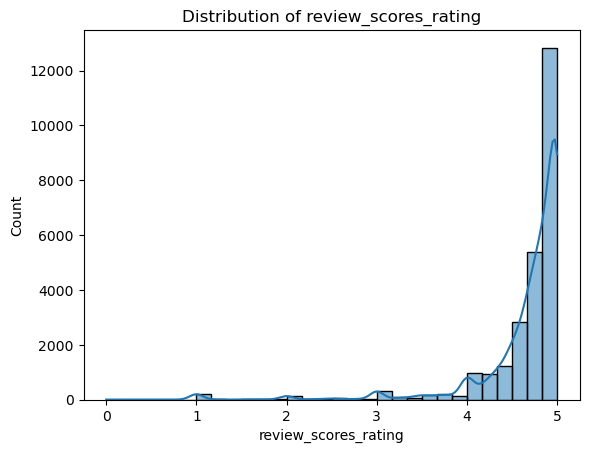

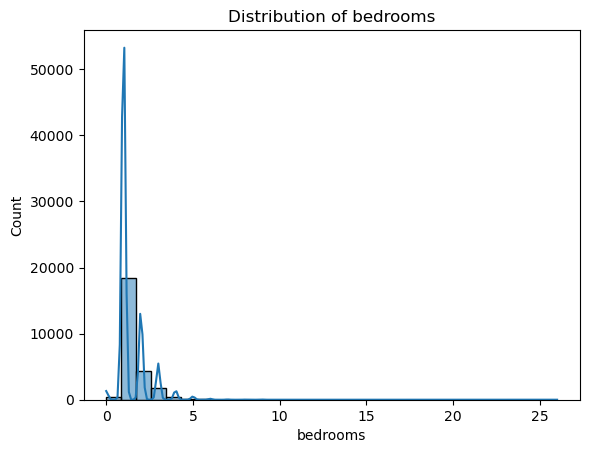

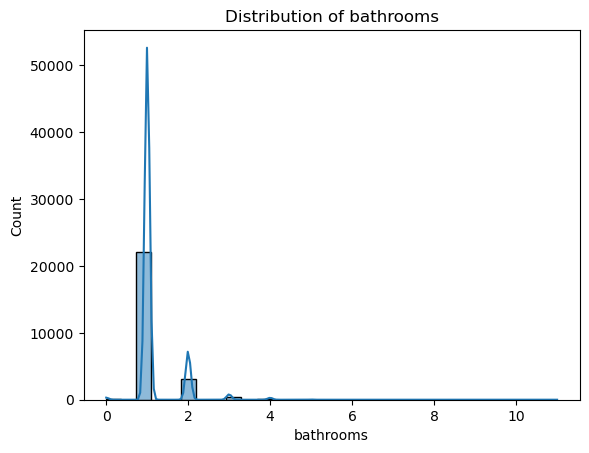

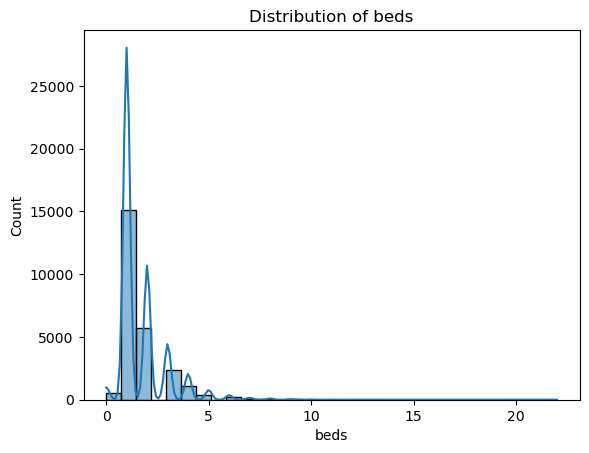

In [40]:
columns = ['review_scores_rating', 'bedrooms', 'bathrooms', 'beds']
for column in columns:
    sns.histplot(df[column], kde=True, bins = 30)
    plt.title(f'Distribution of {column}')
    plt.show()

The distribution for the *review_scores_rating* is highly right-skewed and heavily concentrated near the upper limit (close to 5). This suggests that most properties have high ratings, which is to be expected. Since the data is bounded (0-5) and skewed, we should normalize the range by using Min-Max Scaling.

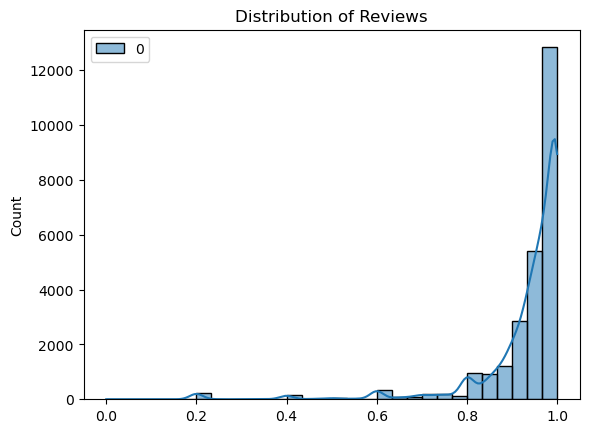

In [41]:
scaler = MinMaxScaler()
test = scaler.fit_transform(df[['review_scores_rating']])
sns.histplot(test, kde=True, bins = 30)
plt.title('Distribution of Reviews')
plt.show()

As this is not really helpfull we keep the column as it is. We could think of changing this column to a category (bucketization) but the issues would be the same.


For the *bedrooms* column we will do a log transformation to keep the relative distances but get rid of the long tail.

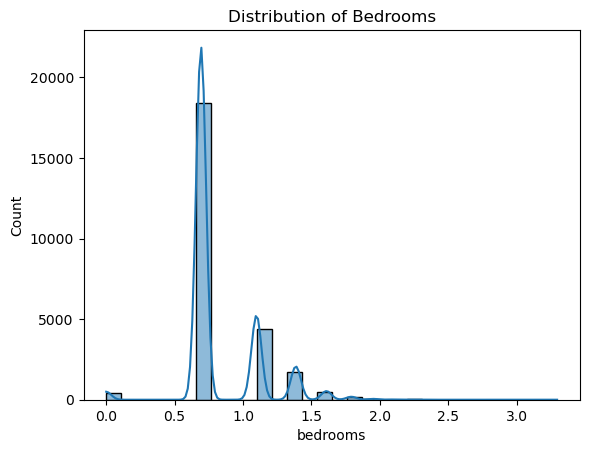

In [42]:
test = np.log1p(df['bedrooms'])  # Use log(1+x) to handle zeros
sns.histplot(test, kde=True, bins = 30)
plt.title('Distribution of Bedrooms')
plt.show()

The tail was reduced the data is less skewed therefore we can overwrite the existing column with the logged data. Furthermore, we will do the same for *beds* and *bathrooms*.

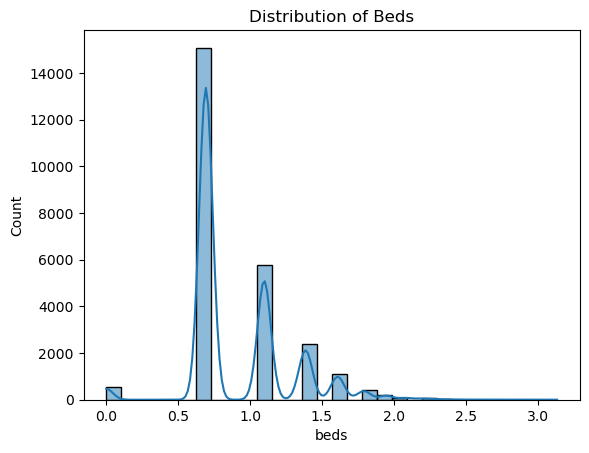

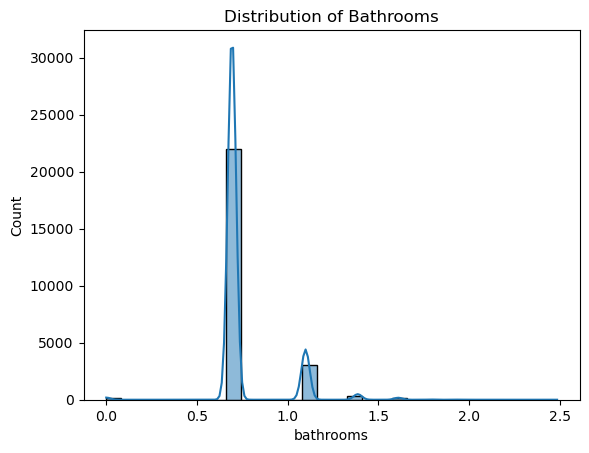

In [43]:
df['bedrooms'] = test
df['beds'] = np.log1p(df['beds'])
df['bathrooms'] = np.log1p(df['bathrooms'])
sns.histplot(df['beds'], kde=True, bins = 30)
plt.title('Distribution of Beds')
plt.show()
sns.histplot(df['bathrooms'], kde=True, bins = 30)
plt.title('Distribution of Bathrooms')
plt.show()

As we can see we did reduce the skewdness quite significantly. 
Now we can do the above described tasks for the rest of the columns. 

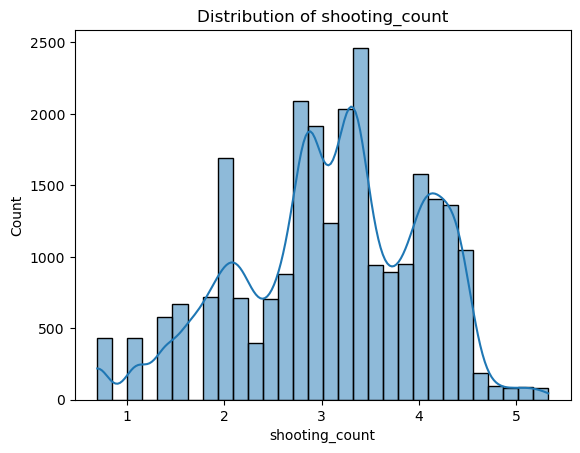

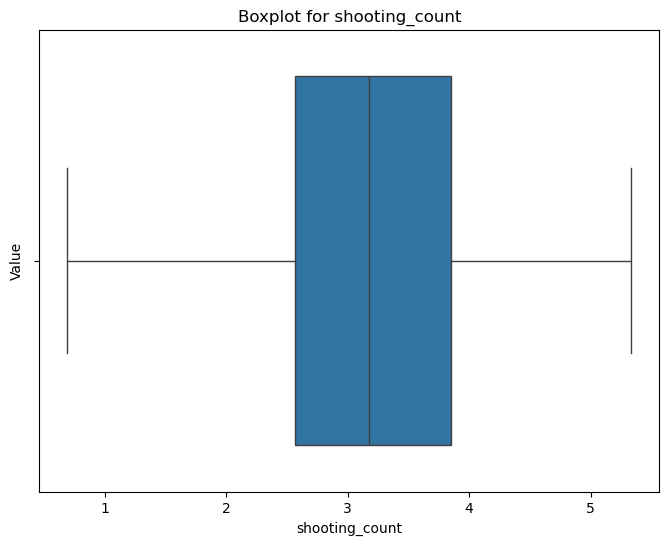

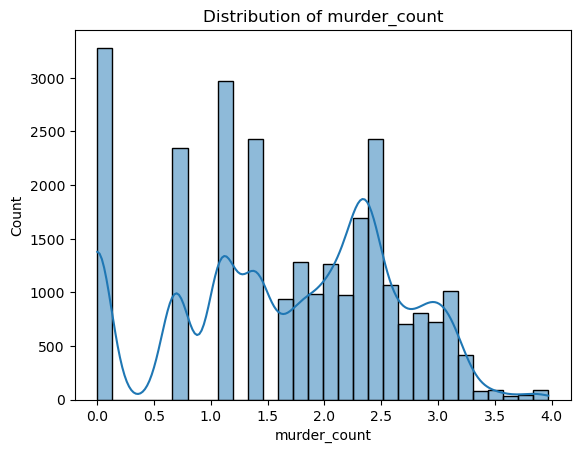

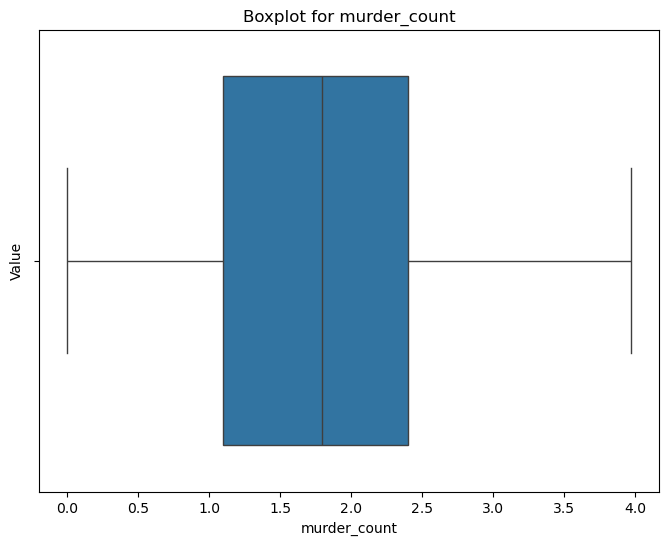

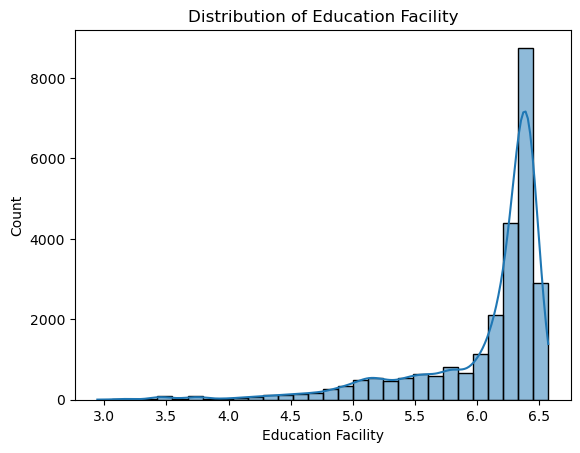

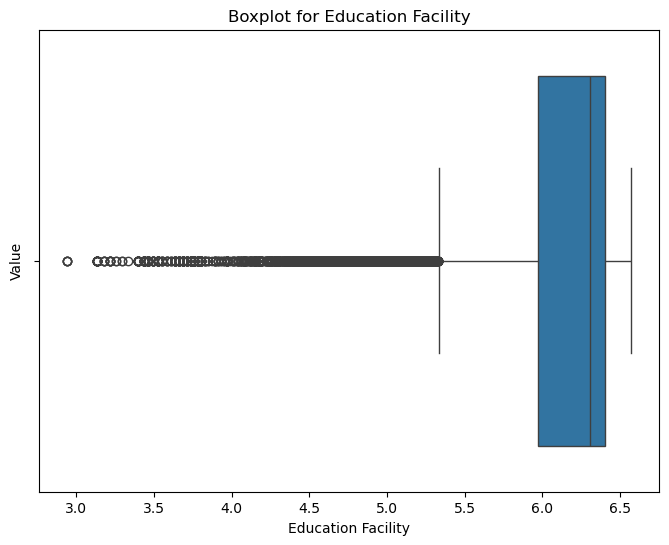

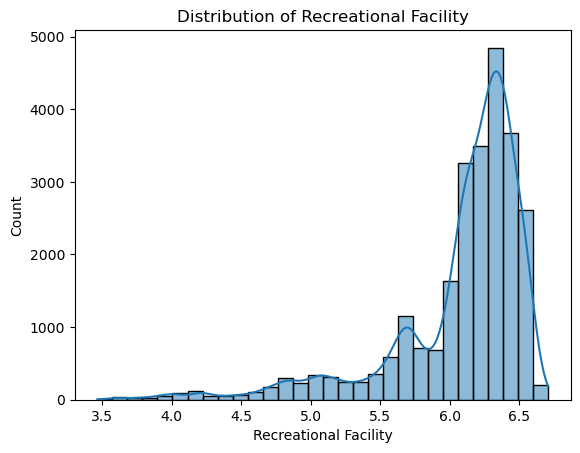

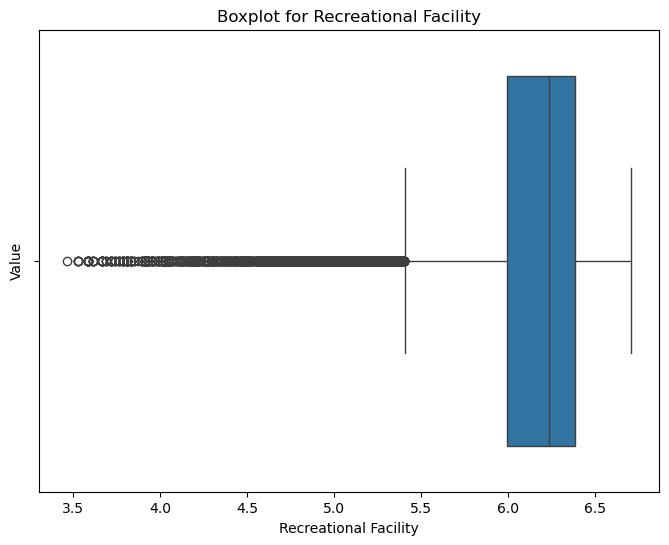

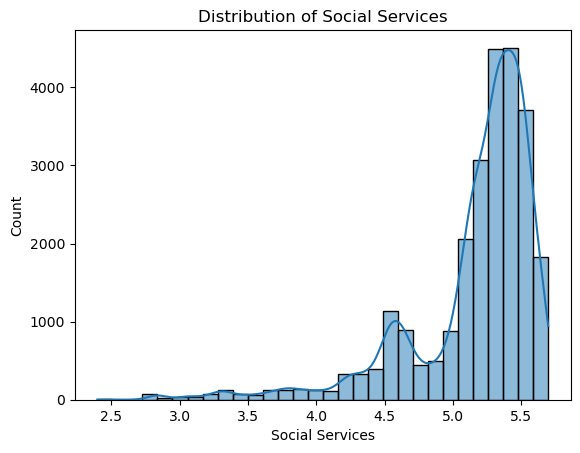

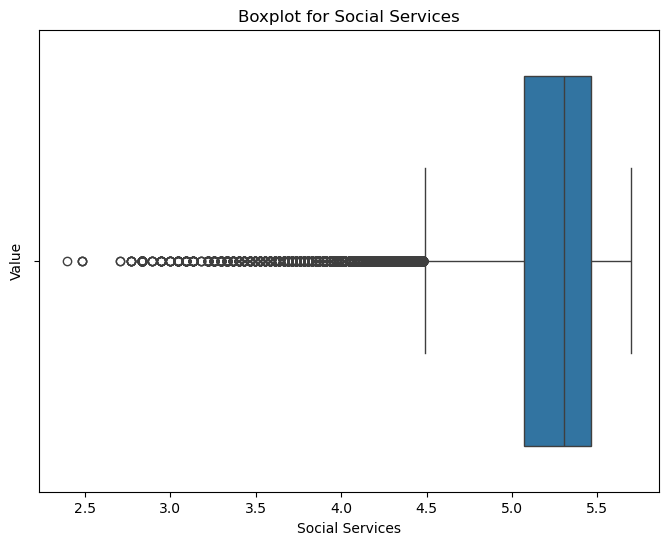

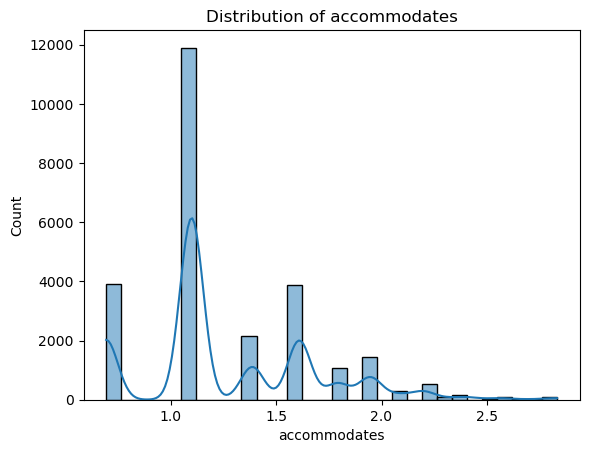

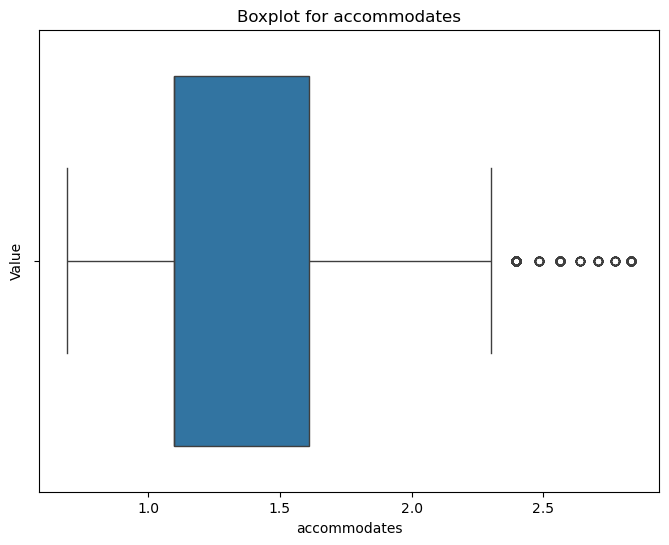

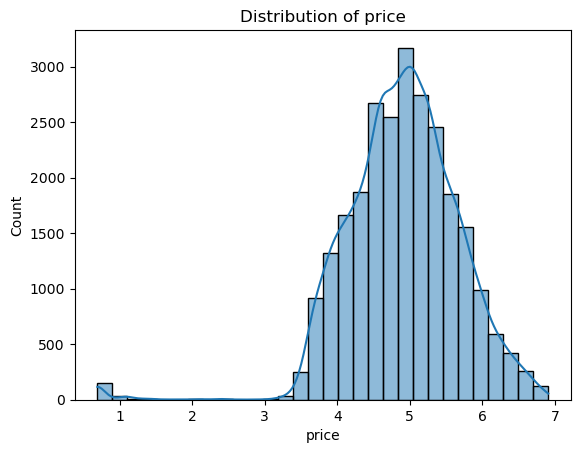

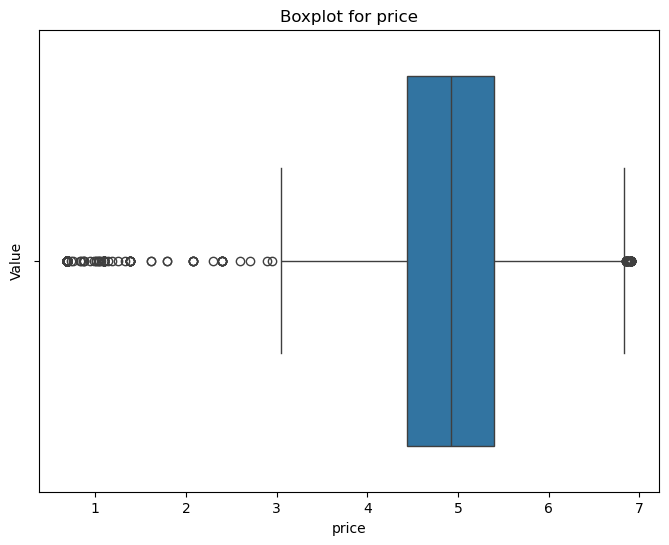

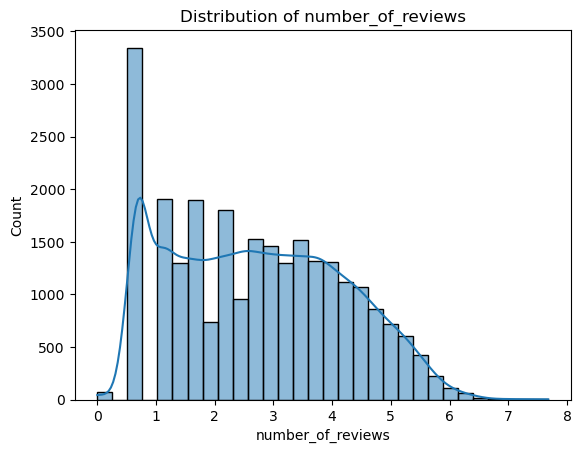

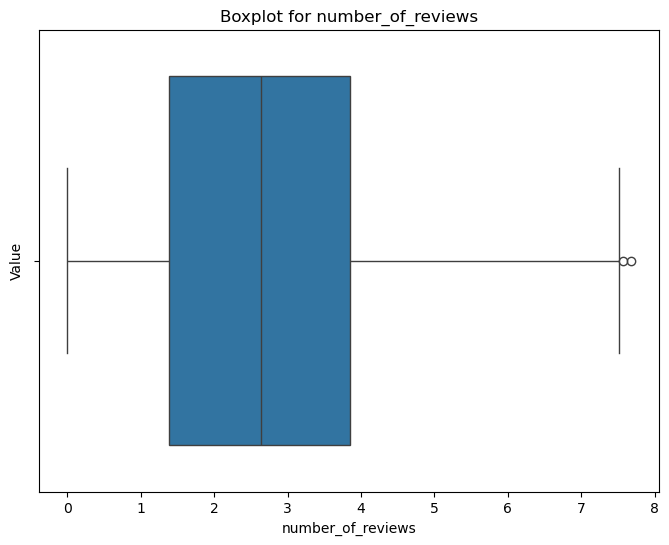

In [44]:
log_columns = ['shooting_count', 'murder_count', 'Education Facility', 'Recreational Facility', 'Social Services', 'accommodates', 'price', 'number_of_reviews']
for column in log_columns:
    df[column] = np.log1p(df[column])
    sns.histplot(df[column], kde=True, bins = 30)
    plt.title(f'Distribution of {column}')
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df, x=column)
    plt.title(f'Boxplot for {column}')
    plt.xlabel(column)
    plt.ylabel('Value')
    plt.show()


As we can see this worked fine, as we reduced the skewness as well as the number of outliers.

### Encode Categorical Variables
Finally, we use a LabelEncoder to convert the categorical values in the *room_type* column of the dataset into numerical labels, making it suitable as feature for machine learning models.

In [45]:
le = LabelEncoder()
df['room_type'] = le.fit_transform(df['room_type'])

----

## Exploratory Data Analysis (EDA)
After the preprocessing we will start with some exploratory analyis in order
After completing the preprocessing steps, we will proceed with exploratory data analysis. By doing so we want to understanding the dataset, identify patterns and trends and uncover relationships between variables, which will help guide our approach to building and optimizing the model.

### Categorical Variables

For the categorical variable *room_type* we use a bar plot to visualize the frequency distribution of the different room types within the dataset.

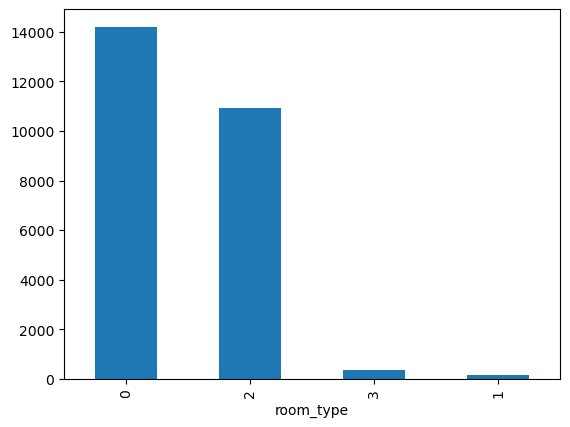

In [46]:
df['room_type'].value_counts().plot(kind='bar')
plt.show()

### Numerical Variables

For the numerical variables we first explore the relationships between them. For this we calculate the correlation matrix of the dataset and visualizes it as a heatmap.

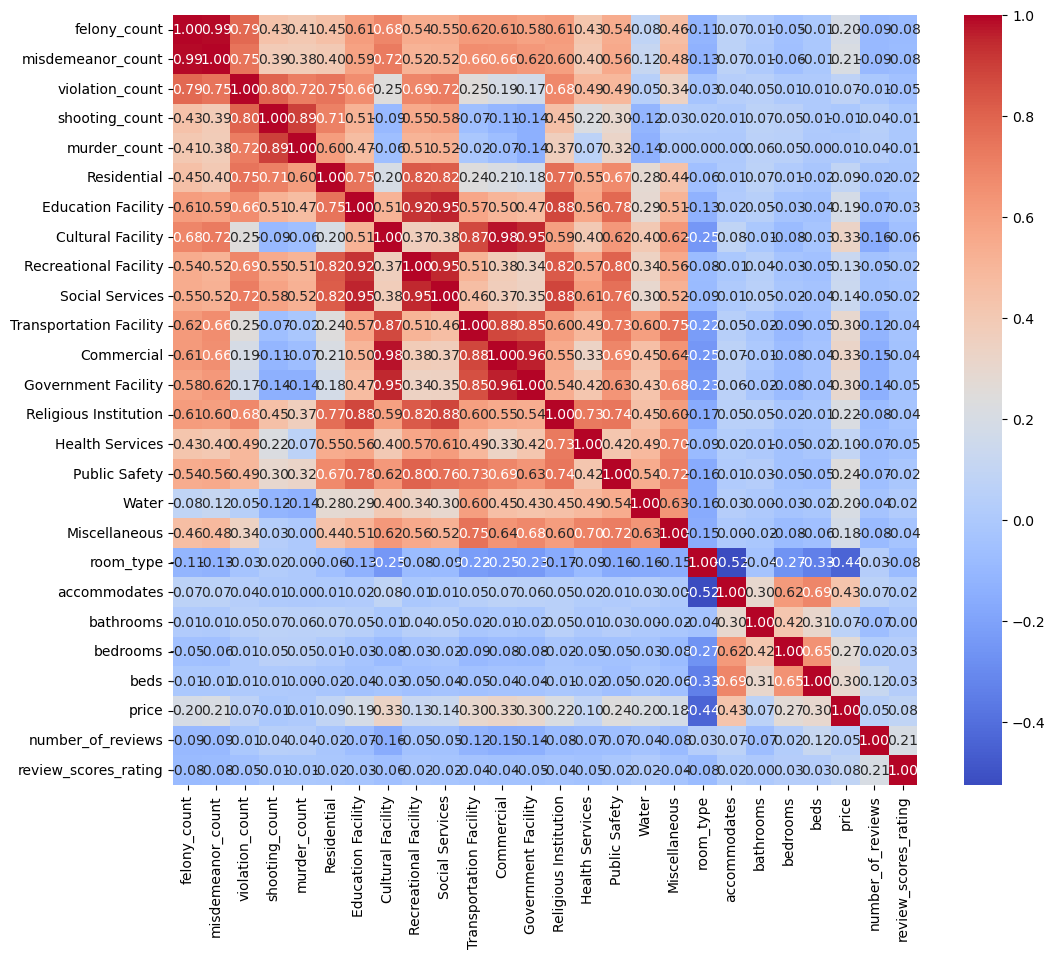

In [47]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

As this is messy, we only show highly correlated variables above a certain treshhold. We set the threshold to 0.8.

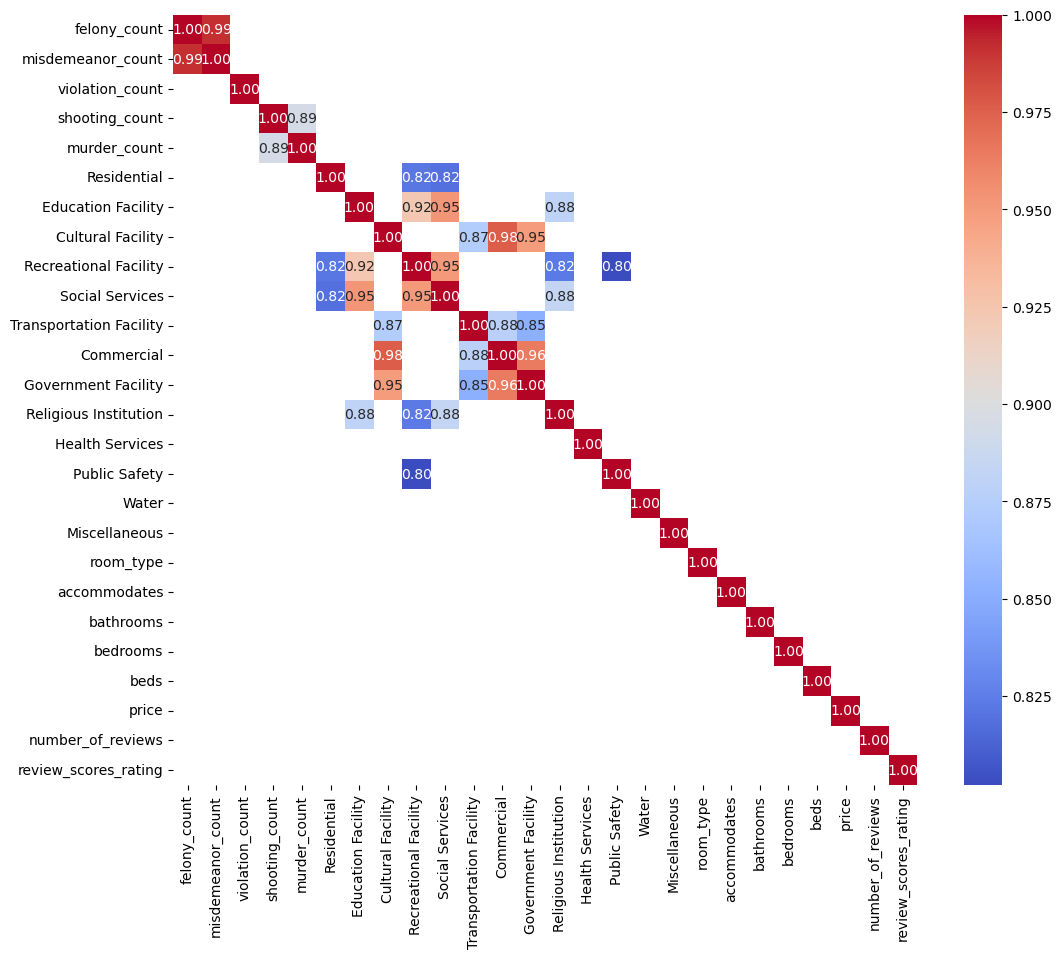

In [48]:
threshold = 0.8
strong_corr = correlation_matrix[(correlation_matrix > threshold) | (correlation_matrix < -threshold)]
plt.figure(figsize=(12, 10))
sns.heatmap(strong_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.show()

As we have a lot of correlating variables we automatically drop one of two variables if they have a correlation of more than 0.8.

Columns dropped: {'Public Safety', 'Social Services', 'murder_count', 'Commercial', 'Recreational Facility', 'Transportation Facility', 'Government Facility', 'Religious Institution', 'misdemeanor_count'}
Remaining columns: ['felony_count', 'violation_count', 'shooting_count', 'Residential', 'Education Facility', 'Cultural Facility', 'Health Services', 'Water', 'Miscellaneous', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'number_of_reviews', 'review_scores_rating']


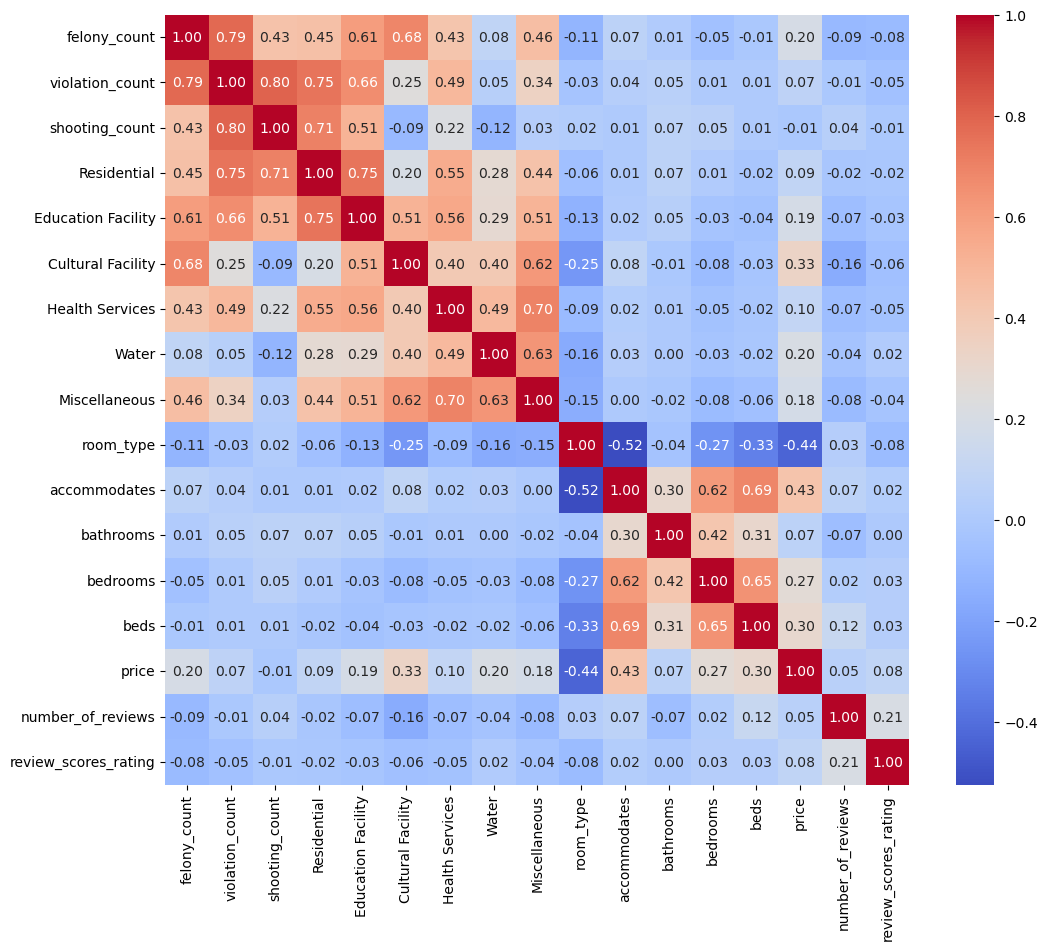

In [49]:
columns_to_drop = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:  
            colname = correlation_matrix.columns[i]  
            columns_to_drop.add(colname)  

df = df.drop(columns=columns_to_drop)

print(f"Columns dropped: {columns_to_drop}")
print(f"Remaining columns: {df.columns.tolist()}")
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

Next, we calculate and display the Variance Inflation Factor (VIF) for each numerical feature to check for multicollinearity. High VIF values show that some features are strongly correlated, which can affect the model and may need to be adjusted. By analyzing the VIF, we can identify and address potential multicollinearity issues before proceeding with the modeling process.

In [50]:
X = df.drop(columns=['price']).select_dtypes(include=['float64', 'int64'])

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                 feature         VIF
0           felony_count   72.036970
1        violation_count  106.255218
2         shooting_count   59.801313
3            Residential   23.984313
4     Education Facility  127.117297
5      Cultural Facility   16.429138
6        Health Services    8.587174
7                  Water   10.525741
8          Miscellaneous   13.391571
9           accommodates   22.287063
10             bathrooms   23.943378
11              bedrooms   20.407461
12                  beds   17.039355
13     number_of_reviews    5.031987
14  review_scores_rating   62.776197


**High VIF Values:**
Education Facility (136.54),
violation_count (106.54),
felony_count (72.79),
review_scores_rating (62.80),
shooting_count (59.83).
These variables are highly correlated with other variables, indicating significant multicollinearity. These features will be handled first.


**Moderately High VIF Values:**
Residential (24.10),
accommodates (26.60),
bathrooms (24.68),
bedrooms (20.42). 
Also exhibit multicollinearity but to a lesser extent. They may still contribute to redundancy in the dataset.

**Acceptable VIF Values:**
Health Services (8.59),
Water (10.53),
Miscellaneous (13.39),
room_type (2.67),
number_of_reviews (5.06)
Are in an acceptable range. 

First we handle the high VIF features by excluding all but one variables with high VIF values:

In [51]:
X = df.drop(columns=['price','felony_count', 'Education Facility', 'review_scores_rating', 'shooting_count']).select_dtypes(include=['float64', 'int64'])

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

              feature        VIF
0     violation_count  16.613438
1         Residential  15.367873
2   Cultural Facility   4.485061
3     Health Services   8.029011
4               Water   9.324809
5       Miscellaneous  13.012456
6        accommodates  21.866576
7           bathrooms  16.596630
8            bedrooms  20.202004
9                beds  17.016690
10  number_of_reviews   4.225421


These correlations results are acceptable, therefore we drop the columns excluded from df. 

In [52]:
df = df.drop(['felony_count', 'Education Facility', 'review_scores_rating', 'shooting_count'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25660 entries, 2595 to 1272803789903111695
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   violation_count    25660 non-null  int64  
 1   Residential        25660 non-null  int64  
 2   Cultural Facility  25660 non-null  int64  
 3   Health Services    25660 non-null  int64  
 4   Water              25660 non-null  int64  
 5   Miscellaneous      25660 non-null  int64  
 6   room_type          25660 non-null  int32  
 7   accommodates       25660 non-null  float64
 8   bathrooms          25660 non-null  float64
 9   bedrooms           25660 non-null  float64
 10  beds               25660 non-null  float64
 11  price              25660 non-null  float64
 12  number_of_reviews  25660 non-null  float64
dtypes: float64(6), int32(1), int64(6)
memory usage: 2.6 MB


### Visualization

Finally we create a boxplot and a histogram (with kernel density estimate) for each column in the dataset to visualize the distribution of the data.

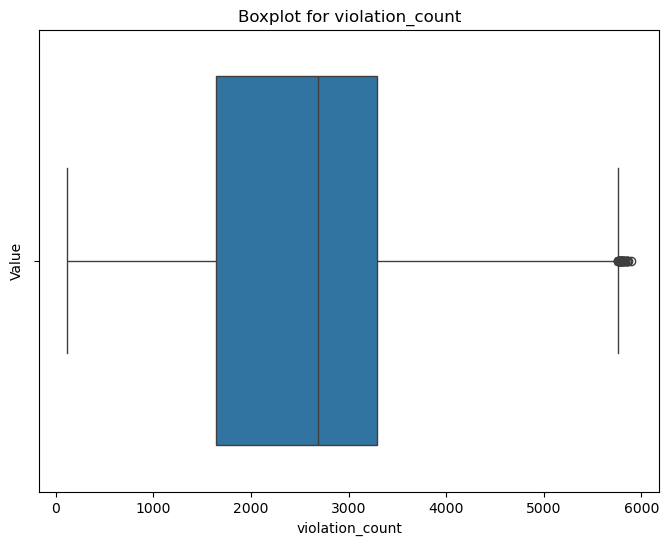

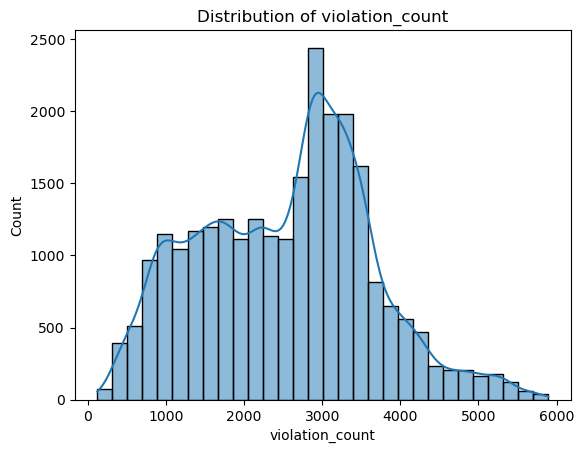

<Figure size 800x600 with 0 Axes>

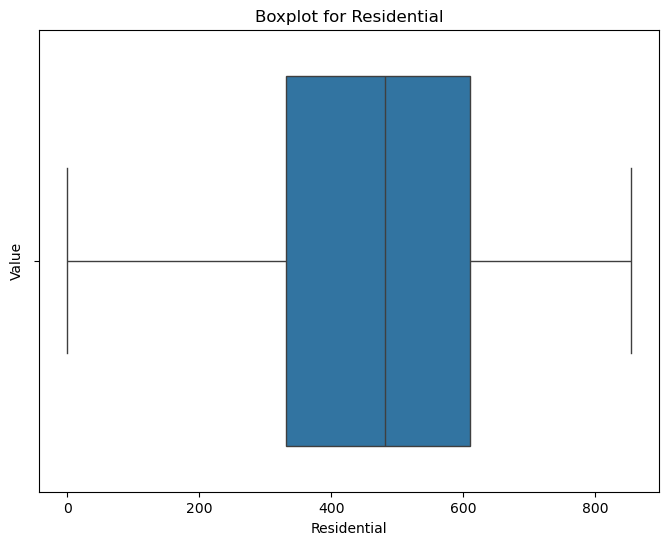

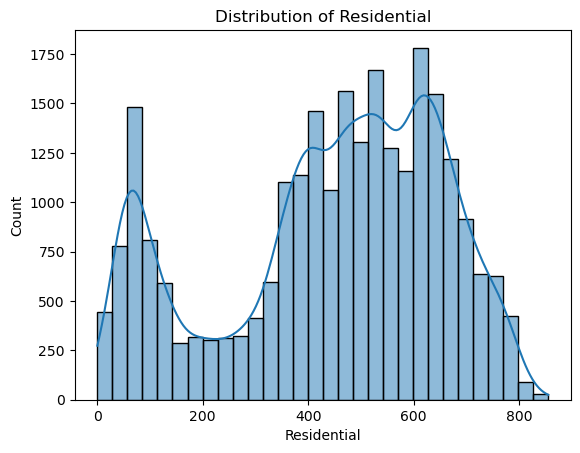

<Figure size 800x600 with 0 Axes>

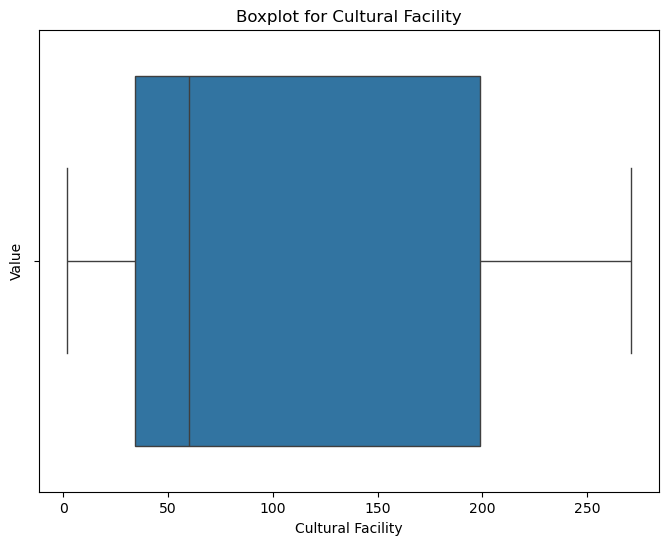

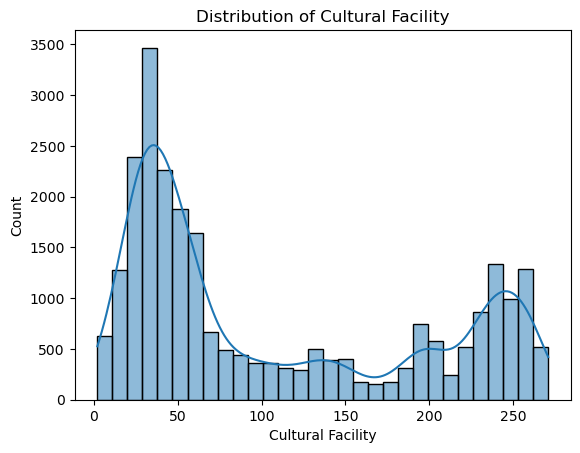

<Figure size 800x600 with 0 Axes>

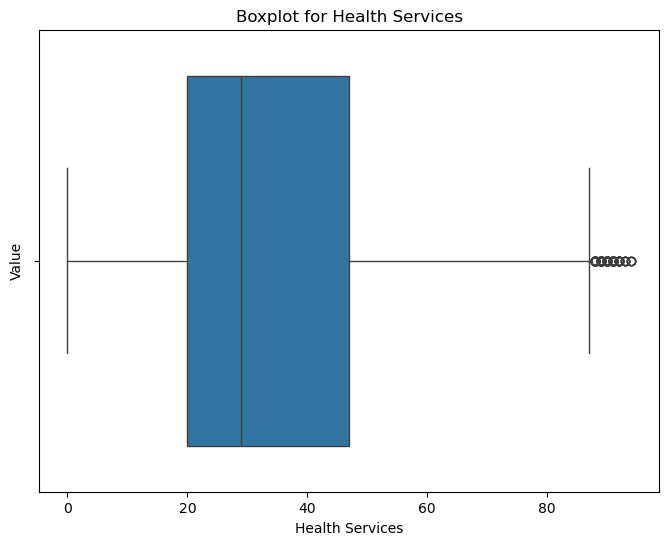

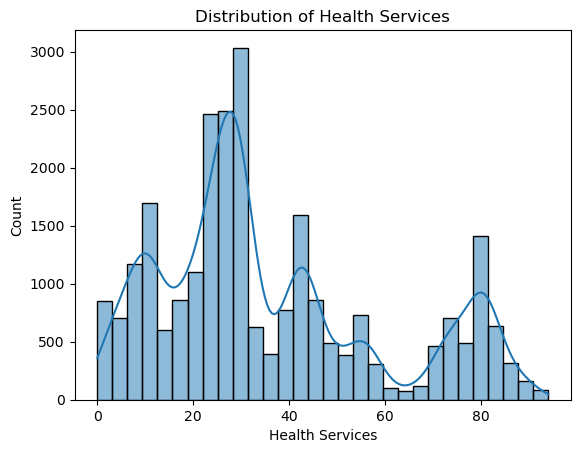

<Figure size 800x600 with 0 Axes>

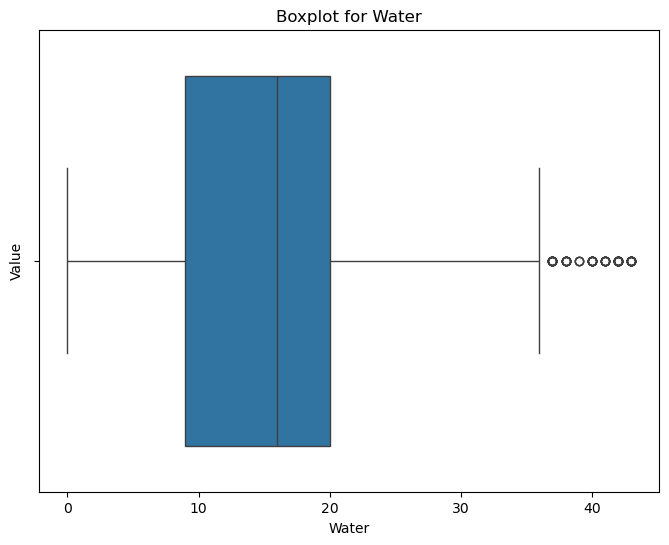

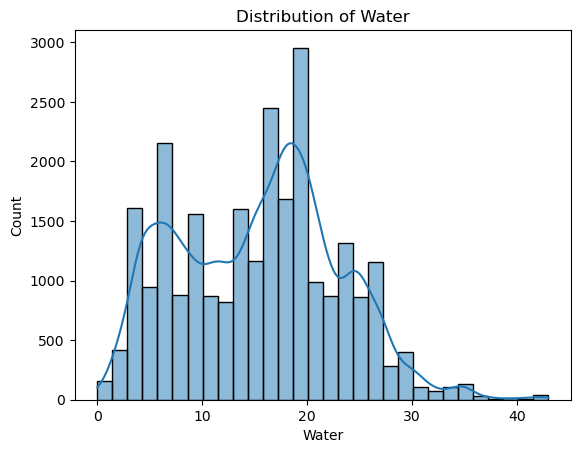

<Figure size 800x600 with 0 Axes>

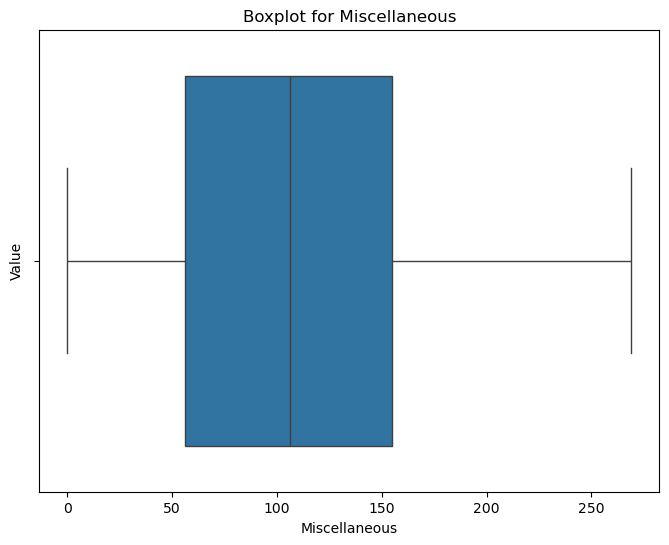

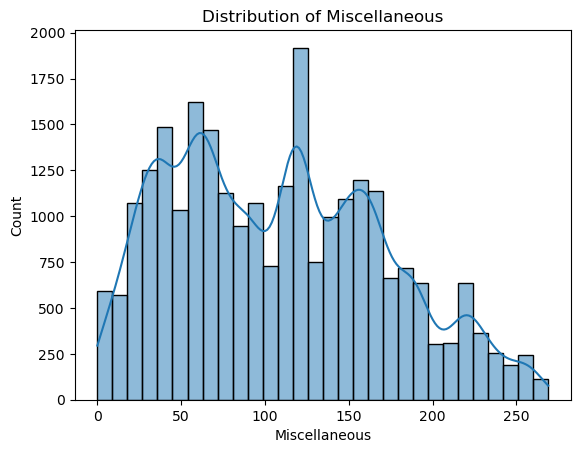

<Figure size 800x600 with 0 Axes>

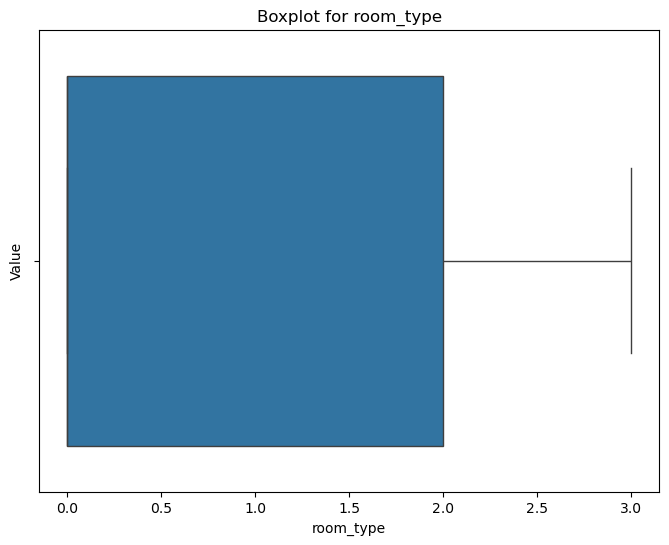

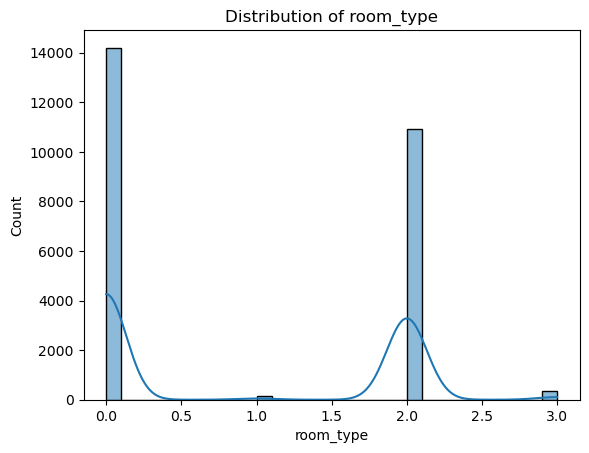

<Figure size 800x600 with 0 Axes>

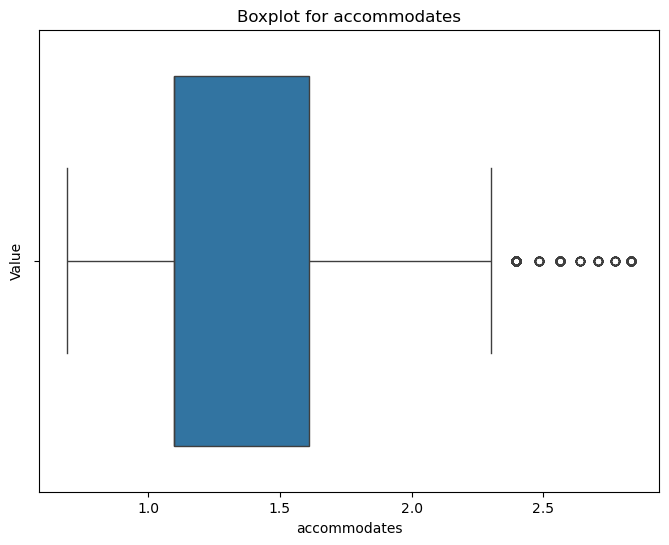

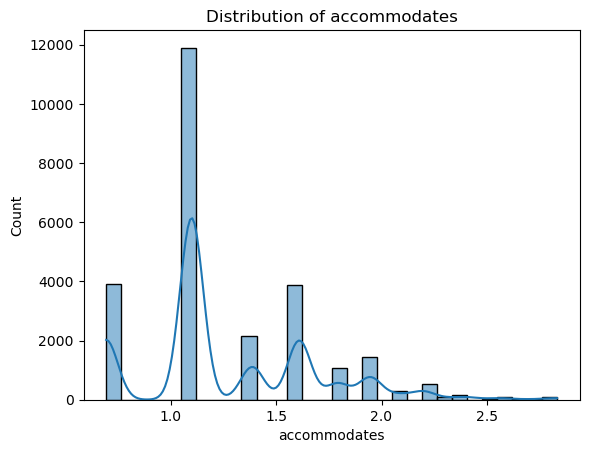

<Figure size 800x600 with 0 Axes>

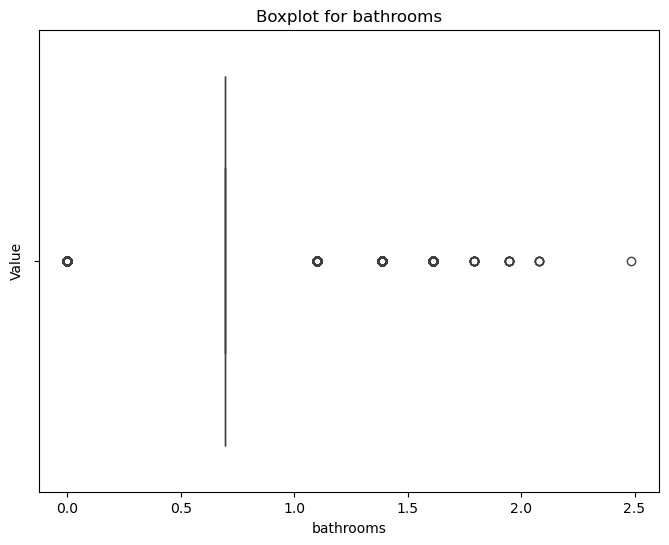

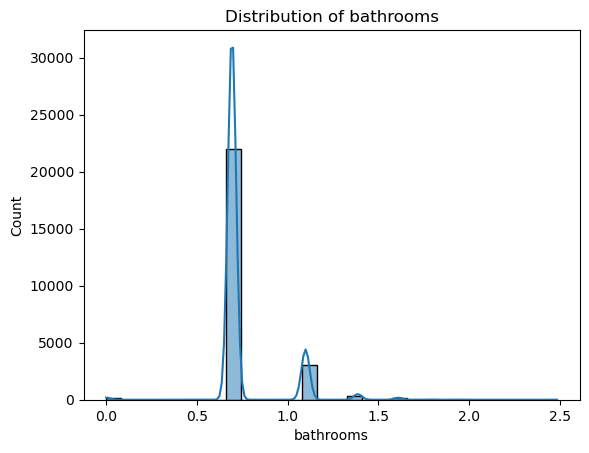

<Figure size 800x600 with 0 Axes>

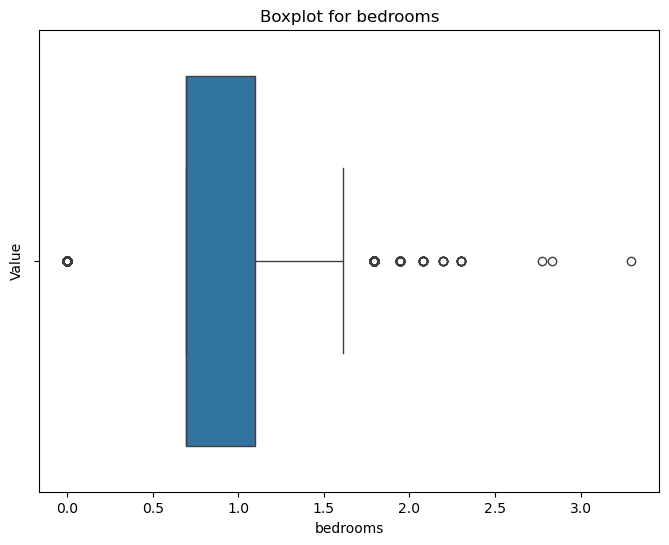

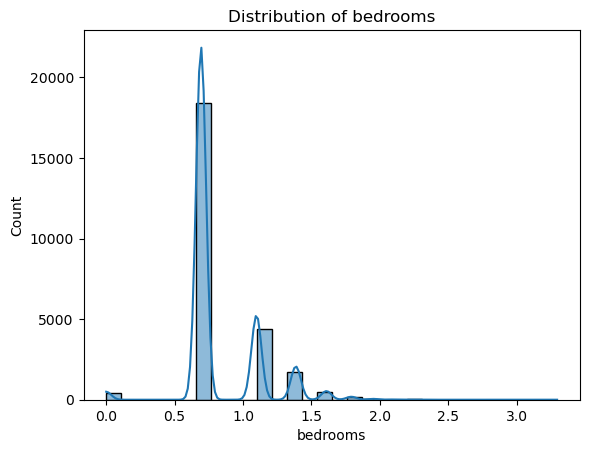

<Figure size 800x600 with 0 Axes>

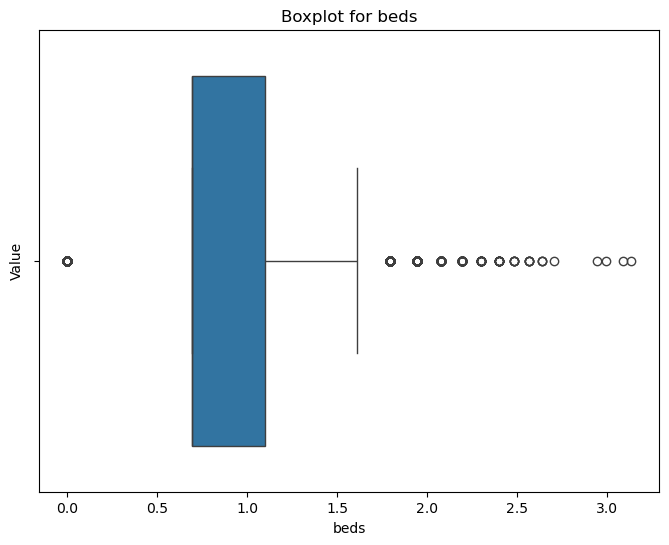

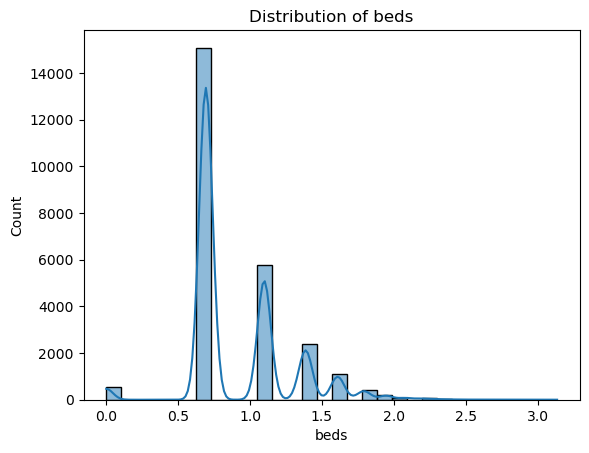

<Figure size 800x600 with 0 Axes>

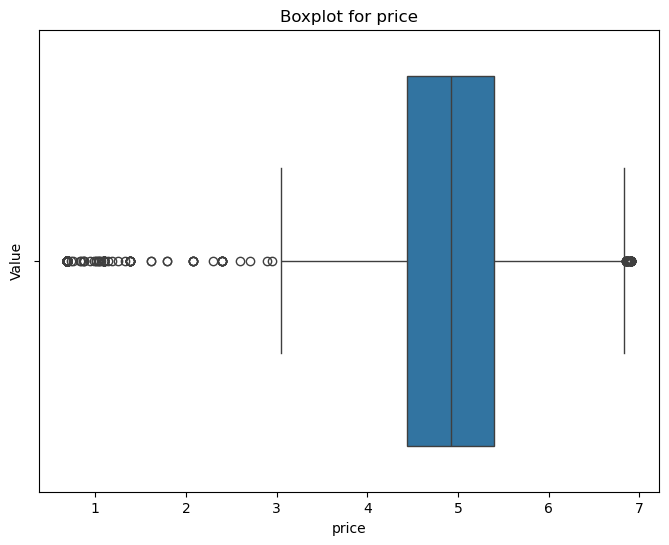

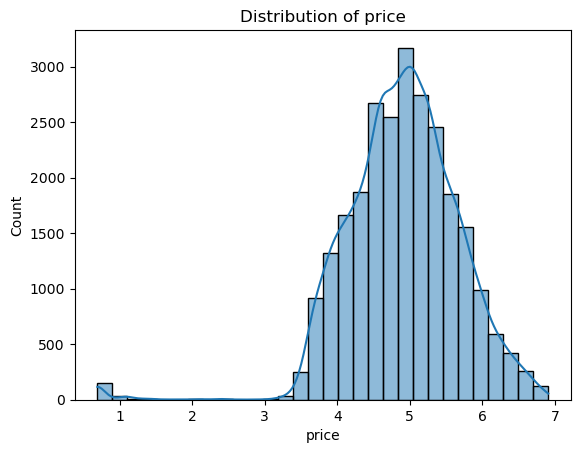

<Figure size 800x600 with 0 Axes>

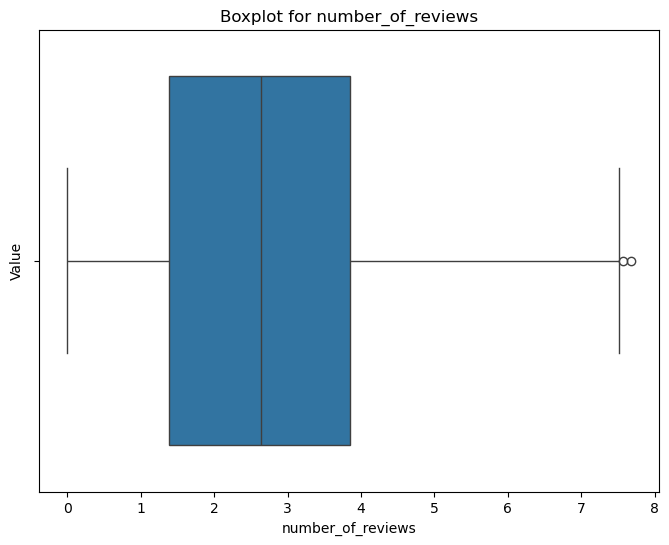

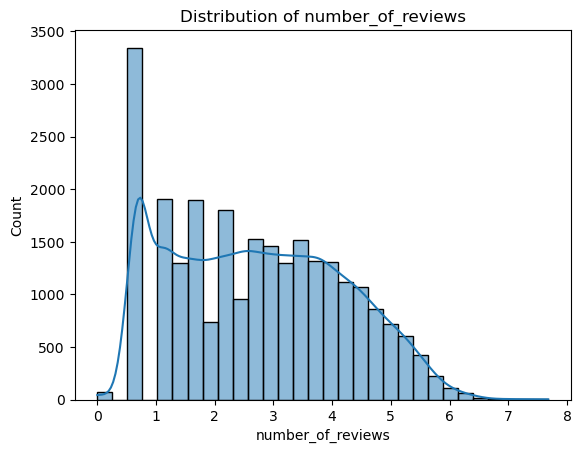

<Figure size 800x600 with 0 Axes>

In [53]:
for column in df:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df, x=column)
    plt.title(f'Boxplot for {column}')
    plt.xlabel(column)
    plt.ylabel('Value')
    plt.show()
    sns.histplot(df[column], kde=True, bins = 30)
    plt.title(f'Distribution of {column}')
    plt.figure(figsize=(8, 6))
    plt.show()

As visible, we managed to normalize the distributions and got rid of most outliers.

----

## Model Building

This section focuses on building a machine learning model to predict the *price* of AirBnB listings using the predictive variables derived from the clustering process. The goal is to analyze how factors such as points of interest, transportation, and crime influence the price of AirBnB listings, and whether they can be used to make accurate predictions. The process begins by splitting the data into training and test sets, sing 20% of the data for testing. Next, we train four different machine learning models as baselines on the training set. The best-performing model will then be fine-tuned for improved performance, and its accuracy will be evaluated on the test set using relevant metrics.

In [54]:
df.head()

violation_count  Residential  Cultural Facility  Health Services  Water  \
id                                                                              
2595             3509          437                254               42     18   
5121             3259          678                 61               29     19   
5136              861          129                 45               20     21   
6848             2098          634                115               28     18   
6872             4685          765                 77               91     25   

      Miscellaneous  room_type  accommodates  bathrooms  bedrooms      beds  \
id                                                                            
2595            126          0      0.693147   0.693147  0.693147  0.693147   
5121             64          2      1.098612   0.693147  0.693147  0.693147   
5136             35          0      1.609438   0.693147  1.098612  1.098612   
6848            125          0      1.386294   0.693147  1.098612  0.693147   
6872            222          2      0.693147   0.693147  0.693147  0.693147   

         price  number_of_reviews  
id                                 
2595  5.484797           3.912023  
5121  4.262680           3.931826  
5136  5.373425           1.609438  
6848  4.408934           5.278115  
6872  4.189655           0.693147

In [55]:
X = df.drop(columns=['price'])
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

independent_columns = df.drop(columns=['price']).columns
scaler = StandardScaler()

# Scale the independent variables only
X_train[independent_columns] = scaler.fit_transform(X_train[independent_columns])
X_test[independent_columns] = scaler.transform(X_test[independent_columns])

Let us try the dataset on multiple algorithms and finetune the algorithm which gives the best baseline performance. We are choosing the following algorithms.

1. Linear Regression – A simple model that assumes a linear relationship between the features and the target variable, making it a good starting point for comparison.
   
3. Decision Trees - A non-linear model that splits the data into branches based on feature values, useful for capturing more complex relationships in the data.
4. Random Forests – An ensemble method that combines multiple decision trees to improve accuracy and reduce overfitting by averaging their predictions.
5. XGBoost – A gradient boosting technique that builds decision trees sequentially, focusing on correcting errors made by previous trees.

For evaluation we use the following metrics:
1. RMSE -  – Measures the average magnitude of prediction errors, with higher penalties for larger errors.
2. R^2  – Indicates how well the model explains the variance in the target variable.
3. MAPE – Measures prediction accuracy as a percentage of the actual values.

In [56]:
results = {}

def baseline_evaluation(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred)/y_test))
    results[model_name] = {'RMSE': rmse, 'R²': r2, 'MAPE': mape}
    print(f"{model_name} Results:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R² Score: {r2:.4f}")
    print(f"  MAPE: {mape:.4f}\n")

models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, objective='reg:squarederror')
}

for model_name, model in models.items():
    baseline_evaluation(model, model_name)

results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df)

Linear Regression Results:
  RMSE: 0.6076
  R² Score: 0.3609
  MAPE: 0.1137

Decision Tree Results:
  RMSE: 0.7501
  R² Score: 0.0260
  MAPE: 0.1128

Random Forest Results:
  RMSE: 0.5369
  R² Score: 0.5010
  MAPE: 0.0931

XGBoost Results:
  RMSE: 0.5531
  R² Score: 0.4703
  MAPE: 0.0964


Model Comparison:
                       RMSE        R²      MAPE
Linear Regression  0.607570  0.360907  0.113738
Decision Tree      0.750059  0.025990  0.112785
Random Forest      0.536877  0.500975  0.093077
XGBoost            0.553139  0.470286  0.096385


In [57]:
results_df

RMSE        R²      MAPE
Linear Regression  0.607570  0.360907  0.113738
Decision Tree      0.750059  0.025990  0.112785
Random Forest      0.536877  0.500975  0.093077
XGBoost            0.553139  0.470286  0.096385

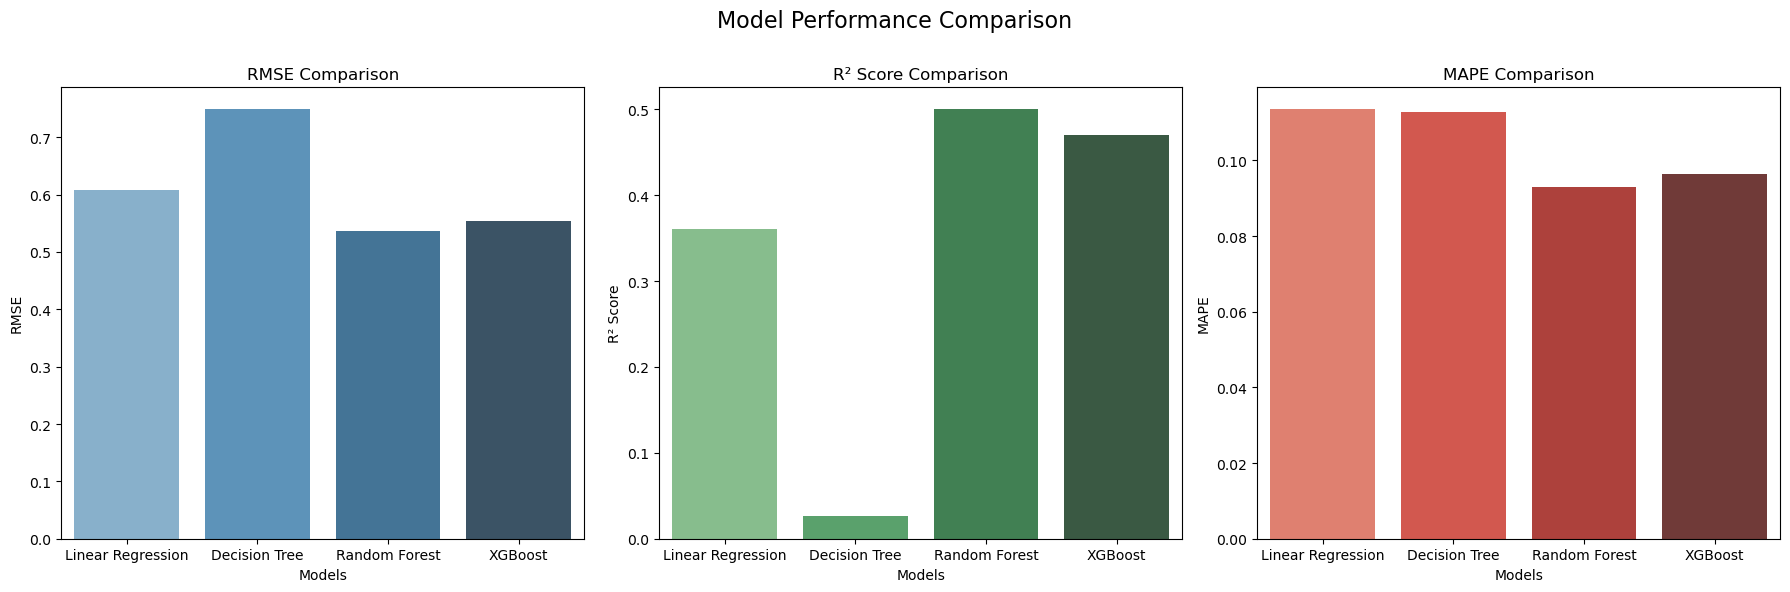

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# RMSE Barplot
sns.barplot(x=results_df.index, y=results_df['RMSE'], hue=results_df.index, palette='Blues_d', ax=axes[0], dodge=False, legend=False)
axes[0].set_title('RMSE Comparison')
axes[0].set_ylabel('RMSE')
axes[0].set_xlabel('Models')

# R² Barplot
sns.barplot(x=results_df.index, y=results_df['R²'], hue=results_df.index, palette='Greens_d', ax=axes[1], dodge=False, legend=False)
axes[1].set_title('R² Score Comparison')
axes[1].set_ylabel('R² Score')
axes[1].set_xlabel('Models')

# MAPE Barplot
sns.barplot(x=results_df.index, y=results_df['MAPE'], hue=results_df.index, palette='Reds_d', ax=axes[2], dodge=False, legend=False)
axes[2].set_title('MAPE Comparison')
axes[2].set_ylabel('MAPE')
axes[2].set_xlabel('Models')

# Add a common title for all three plots
fig.suptitle('Model Performance Comparison', fontsize=16)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust top to make room for the suptitle
plt.show()


Random Forests turned out to be the best model which consistently outperformed other models in all metrics. The low RMSE of 0.5 along with a reasonable MAPE of 0.09 makes sure that the predictions of the model are accurate and acceptable. While R2 suggests only an explainability of 50% of variance, this could be due to the omission of a number of highly collinear and correlated features.

As a next step we use this baseline model and perform hyperparameter tuning using RandomizedSearchCV. We will test 20 random combinations of hyperparameters including *n_estimators*, *max_depth*, *min_sample_split*, *min_samples_leaf* and *bootstrap* with 10-fold cross-validation. After finding the best hyperparameters, it evaluates the model's performance on the test set.

In [59]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(estimator=rf,
                                   param_distributions=param_distributions,
                                   n_iter=20,  # Limit to 20 random combinations
                                   scoring='r2',
                                   cv=10, 
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1)

random_search.fit(X_train, y_train)

best_rf_random = random_search.best_estimator_
print("\nBest Hyperparameters for Random Forest:")
print(random_search.best_params_)

y_pred_best_rf_random = best_rf_random.predict(X_test)
rmse_best_rf_random = np.sqrt(mean_squared_error(y_test, y_pred_best_rf_random))
r2_best_rf_random = r2_score(y_test, y_pred_best_rf_random)
mape_best_rf_random = np.mean(np.abs((y_test - y_pred_best_rf_random)/y_test))

print("\nRandom Forest with Best Hyperparameters (RandomizedSearchCV) Results:")
print(f"  RMSE: {rmse_best_rf_random:.4f}")
print(f"  R² Score: {r2_best_rf_random:.4f}")
print(f"  MAPE: {mape_best_rf_random:.4f}")

Fitting 10 folds for each of 20 candidates, totalling 200 fits

Best Hyperparameters for Random Forest:
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 40, 'bootstrap': True}

Random Forest with Best Hyperparameters (RandomizedSearchCV) Results:
  RMSE: 0.5340
  R² Score: 0.5063
  MAPE: 0.0939


Finally we can use the Random Forestes also to determine the feature importances of various features and their contributions in predicting the target.

In [60]:
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf_random.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importances)

              Feature  Importance
6           room_type    0.224900
2   Cultural Facility    0.148056
7        accommodates    0.093645
1         Residential    0.086920
0     violation_count    0.083020
11  number_of_reviews    0.078179
5       Miscellaneous    0.069220
3     Health Services    0.057495
9            bedrooms    0.051125
4               Water    0.041293
10               beds    0.036006
8           bathrooms    0.030139


Features like *room_type*, *Cultural Facility*, and *accommodates* have the highest impact, meaning these factors are crucial in determining the outcome of the model (likely predicting something like price or demand).
Bathrooms, beds, and water are less important, with a lower contribution to the model's prediction. These features may still be relevant but have less predictive power in this case.

----

## Conclusion

Throughout this assessment, we were able to answer the questions we set out to begin with albeit to an extent. From the evaluation metrics of our chosen model, we were able to determine that the model does an okay job in predicting the prices of AirBnb rentals given the various factors with an acceptable RMSE of 0.5 and a prediction error of 9%. The key factors that influence the prices of Airbnb rentals turned out to be room_type, cultural facilities and number of accommodates.

We could also see that the crime statistics of the area do indeed influence the prices of rentals to an extent as evident by violation_counts in the feature importances. Also, the impact of availability of public transport on the prices could not be established clearly in our analysis but it could be implied that they do have an affect on prices as features pertaining to transportation were weeded out of the dataset due to their high correlation with other features like cultural facilities and services.

## Potential Biases and Limitations

### Bias in the Data

Generally, ratings contain bias, as people tend to rate only when they feel strongly about something. This means in general highly positive and highly negative reviews are more often given than average reviews. As Airbnb offers a 30-day grace for hosts to respond to a bad review and therefore settle the matters with the guest, to remove the bad review, this causes a bias towards highly positive data. This can be seen, as most of the reviews are above 4.0. Besides, the analysis significantly centres around AirBnB data which is only available for 10 months starting from February 2024 to November 2024. Historical data was locked beneath a paywall rendering us unable to acquire it. Given more data, there would have been potential to analyze in even more detail.

The selected points of interests are prone to bias as well, as the tourist points of interest, are those that the city of New York provides, which might not include locations that would actually be interesting or contain not relevant locations as well.

### Limitations and Biases of the Analysis

The analysis puts each of the listings, transport stations and points of interests inside a grid cell to define proximity to the location. While this is accurate for locations in the center of a given grid cell, this is a simplification that ignores the proximity to locations in neighbouring grid cells for locations close to the border of the given grid cell.

Analyzing the AirBnB data also brought forth various challenges that involved dealing with the missing values of important features like prices. Many AirBnB listings do not have price listed directly in the website and some do not have ratings rendering them useless for the analysis. While we tried tackling dealing with such issues by getting reviews and assigning scores based on reviews using simple sentiment analysis, we still had to drop a lot of data.

## Distribution of Work

The workload was divided equally between all the team members. Regular meetings were held to synchronize on the project status and tasks were parallelized where possible (e.g. writing reports, research concerning methodology,...) and for critical sections (e.g. model analysis, choosing approach,...) at least two members of the team worked together.